In [4]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
from os import listdir
from os.path import isfile, join
import sys
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from matplotlib import patches
from matplotlib.collections import PatchCollection
#import matplotlib
from PIL import Image, ImageDraw
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from matplotlib import pyplot
from skimage.color import rgb2gray, gray2rgb
from skimage.filters import threshold_otsu
from skimage.draw import polygon
from shapely.geometry.polygon import Polygon as Polygon_shapley
# from multiprocessing import Pool
import multiprocessing
import time
import random
import pickle
import png
from scipy.spatial import ConvexHull
import bbox_visualizer as bbv
import operator
import fileinput
import re

sys.path.insert(0, os.path.dirname(os.path.abspath('.'))) # to make imports relative to project root work

np.random.seed(0)

# Check Cell Images Malaria Dataset

Get data from https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#malaria-datasets save it in data

In [147]:
path_uninfected = '../data/cell_images/patientid_cellmapping_uninfected.csv'
path_parasitized = '../data/cell_images/patientid_cellmapping_parasitized.csv'
# Read in the file
with open(path_uninfected, 'r') as file :
    filedata = file.read()

# Replace the target string
filedata = filedata.replace('[|]', '')

# Write the file out again
with open(path_uninfected, 'w') as file:
    file.write(filedata)


In [148]:
#read and transform data
uninfected = pd.read_csv('../data/cell_images/patientid_cellmapping_uninfected.csv', header = None)
uninfected = uninfected.set_index(0)
uninfected['imgs'] = uninfected.values.tolist()
uninfected['imgs'] = uninfected['imgs'].apply(lambda mylist: [x for x in mylist if pd.isnull(x) == False])
uninfected_df = pd.DataFrame(uninfected['imgs'], index =uninfected.index)
parasitized = pd.read_csv('../data/cell_images/patientid_cellmapping_parasitized.csv', header = None)
parasitized = parasitized.set_index(0)
parasitized['imgs'] = parasitized.values.tolist()
parasitized['imgs'] = parasitized['imgs'].apply(lambda mylist: [x for x in mylist if pd.isnull(x) == False])
parasitized_df = pd.DataFrame(parasitized['imgs'], index =parasitized.index)

In [149]:
# get additional data
uninfected_df['len_imgs'] = uninfected_df['imgs'].apply(lambda x: len(x))
parasitized_df['len_imgs'] = parasitized_df['imgs'].apply(lambda x: len(x))
uninfected_df

imgs  len_imgs
0                                                                        
C100P61ThinF  [['C100P61ThinF_IMG_20150918_144104_cell_128.p...        68
C101P62ThinF  [['C101P62ThinF_IMG_20150918_151006_cell_17.pn...        71
C102P63ThinF  [['C102P63ThinF_IMG_20150918_161508_cell_101.p...        68
C103P64ThinF  [['C103P64ThinF_IMG_20150918_164250_cell_121.p...        68
C104P65ThinF  [['C104P65ThinF_IMG_20150918_170850_cell_140.p...        72
...                                                         ...       ...
C95P56ThinF   [['C95P56ThinF_IMG_20150821_171242_cell_21.png...        68
C96P57ThinF   [['C96P57ThinF_IMG_20150824_105213_cell_119.pn...        67
C97P58ThinF   [['C97P58ThinF_IMG_20150917_145555_cell_103.pn...        65
C98P59ThinF   [['C98P59ThinF_IMG_20150917_153030_cell_120.pn...        69
C99P60ThinF   [['C99P60ThinF_IMG_20150918_140900_cell_24.png...        68

[201 rows x 2 columns]

In [150]:
parasitized_df

imgs  len_imgs
0                                                                        
C100P61ThinF  [['C100P61ThinF_IMG_20150918_144104_cell_162.p...        57
C101P62ThinF  [['C101P62ThinF_IMG_20150918_151006_cell_61.pn...       314
C102P63ThinF  [['C102P63ThinF_IMG_20150918_161508_cell_190.p...        35
C103P64ThinF  [['C103P64ThinF_IMG_20150918_164250_cell_170.p...        39
C104P65ThinF  [['C104P65ThinF_IMG_20150918_170850_cell_204.p...        10
...                                                         ...       ...
C95P56ThinF   [['C95P56ThinF_IMG_20150821_171242_cell_100.pn...        24
C96P57ThinF   [['C96P57ThinF_IMG_20150824_105213_cell_207.pn...        19
C97P58ThinF   [['C97P58ThinF_IMG_20150917_145555_cell_165.pn...       245
C98P59ThinF   [['C98P59ThinF_IMG_20150917_153030_cell_156.pn...        39
C99P60ThinF   [['C99P60ThinF_IMG_20150918_140900_cell_100.pn...       564

[151 rows x 2 columns]

##### Patient Nr. 8 has two entries.


In [151]:
def get_patient_id(lst):
    for item in lst:
        try:
            return int(re.search('P[0-9]*', item).group(0)[1:])
        except Exception as e:
            print(e)

uninfected_df['patient_n'] = uninfected_df['imgs'].apply(lambda x: get_patient_id(x))
parasitized_df['patient_n'] = parasitized_df['imgs'].apply(lambda x: get_patient_id(x))

'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' 

'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' object has no attribute 'group'
'NoneType' 

In [152]:
parasitized_df['patient_n'].duplicated().value_counts()

False    150
True       1
Name: patient_n, dtype: int64

In [153]:
parasitized_df[parasitized_df['patient_n'].duplicated() == True]

imgs  \
0                                                                             
C47P8thin_Original_Motic  [['C47P8thin_Original_Motic_IMG_20150714_09351...   

                          len_imgs  patient_n  
0                                              
C47P8thin_Original_Motic         8          8

In [154]:
parasitized_df[parasitized_df['patient_n'] == 8]

imgs  \
0                                                                                 
C47P8thinOriginalOlympusCX21  [['C47P8thinOriginalOlympusCX21_IMG_20150717_1...   
C47P8thin_Original_Motic      [['C47P8thin_Original_Motic_IMG_20150714_09351...   

                              len_imgs  patient_n  
0                                                  
C47P8thinOriginalOlympusCX21         2          8  
C47P8thin_Original_Motic             8          8

In [155]:
uninfected_df[uninfected_df['patient_n'].isna()]

imgs  len_imgs  \
0                                                                              
C12NThinF        [['C12NThinF_IMG_20150614_124212_cell_111.png'...        68   
C13NThinF        [['C13NThinF_IMG_20150614_131318_cell_102.png'...        69   
C1_thinF         [['C1_thinF_IMG_20150604_104722_cell_115.png',...        70   
C201ThinF        [['C201ThinF_IMG_20150930_142848_cell_106.png'...        68   
C202ThinF        [['C202ThinF_IMG_20151015_151254_cell_118.png'...        65   
C203ThinF        [['C203ThinF_IMG_20151029_102123_cell_108.png'...        69   
C204ThinF        [['C204ThinF_IMG_20151029_110627_cell_102.png'...        67   
C205ThinF        [['C205ThinF_IMG_20151106_151514_cell_117.png'...        69   
C206ThinF        [['C206ThinF_IMG_20151029_140511_cell_112.png'...        71   
C207ThinF        [['C207ThinF_IMG_20151029_143711_cell_105.png'...        70   
C208ThinF        [['C208ThinF_IMG_20151029_151017_cell_107.png'...        69   
C209ThinF        [['C209ThinF_IMG_20151029_160721_cell_10.png',...        71   
C210ThinF        [['C210ThinF_IMG_20151029_162357_cell_107.png'...        68   
C211ThinF        [['C211ThinF_IMG_20151029_163959_cell_104.png'...        69   
C212ThinF        [['C212ThinF_IMG_20151106_105437_cell_132.png'...        68   
C213ThinF        [['C213ThinF_IMG_20151106_112252_cell_155.png'...        69   
C214ThinF        [['C214ThinF_IMG_20151106_114526_cell_13.png',...        67   
C215ThinF        [['C215ThinF_IMG_20151106_133012_cell_127.png'...        69   
C216ThinF        [['C216ThinF_IMG_20151106_134733_cell_105.png'...        68   
C217ThinF        [['C217ThinF_IMG_20151106_141135_cell_122.png'...        69   
C218ThinF        [['C218ThinF_IMG_20151106_143940_cell_145.png'...        69   
C219ThinF        [['C219ThinF_IMG_20151106_145856_cell_124.png'...        66   
C220ThinF        [['C220ThinF_IMG_20151106_153947_cell_108.png'...        68   
C221ThinF        [['C221ThinF_IMG_20151106_155857_cell_13.png',...        70   
C222ThinF        [['C222ThinF_IMG_20151115_150057_cell_104.png'...        69   
C223ThinF        [['C223ThinF_IMG_20151112_103809_cell_101.png'...        68   
C224ThinF        [['C224ThinF_IMG_20151112_111955_cell_105.png'...        67   
C225ThinF        [['C225ThinF_IMG_20151112_113735_cell_111.png'...        67   
C226ThinF        [['C226ThinF_IMG_20151112_131255_cell_141.png'...        68   
C227ThinF        [['C227ThinF_IMG_20151112_135158_cell_122.png'...        68   
C228ThinF        [['C228ThinF_IMG_20151112_142109_cell_100.png'...        66   
C229ThinF        [['C229ThinF_IMG_20151112_144147_cell_130.png'...        69   
C230ThinF        [['C230ThinF_IMG_20151112_150329_cell_138.png'...        68   
C231ThinF        [['C231ThinF_IMG_20151112_152234_cell_1.png', ...        70   
C232ThinF        [['C232ThinF_IMG_20151112_154211_cell_112.png'...        69   
C233ThinF        [['C233ThinF_IMG_20151112_160059_cell_114.png'...        68   
C234ThinF        [['C234ThinF_IMG_20151112_162759_cell_106.png'...        65   
C235ThinF        [['C235ThinF_IMG_20151112_164625_cell_119.png'...        68   
C236ThinF        [['C236ThinF_IMG_20151127_102115_cell_104.png'...        68   
C237ThinF        [['C237ThinF_IMG_20151127_104748_cell_110.png'...        68   
C238NThinF       [['C238NThinF_IMG_20151207_114038_cell_106.png...        70   
C239ThinF        [['C239ThinF_IMG_20151127_113008_cell_1.png', ...        69   
C240ThinF        [['C240ThinF_IMG_20151127_115223_cell_105.png'...        65   
C241NThinF       [['C241NThinF_IMG_20151207_124030_cell_129.png...        68   
C2NThinF         [['C2NThinF_IMG_20150604_114631_cell_141.png',...        69   
C3thin_original  [['C3thin_original_IMG_20150608_162835_cell_10...        69   
C4thin_original  [['C4thin_original_IMG_20150608_165540_cell_16...        67   
C5NThinF         [['C5NThinF_IMG_20150609_122006_cell_109.png',...        69   
C6NThinF         [['C6NThinF_IMG_20150609_121955_cell_104.png'

In [156]:
len(uninfected_df[uninfected_df['patient_n'].isna()])

50

In [157]:
len(parasitized_df[parasitized_df['patient_n'].isna()])

0

In [158]:
uninfected_df['len_imgs'].sum()

13779

In [159]:
parasitized_df['len_imgs'].sum()

13779

In [160]:
uninfected_df['len_imgs'].sum() + parasitized_df['len_imgs'].sum()

27558

# Check Bounding Boxex NIH

First download files from ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/NIH-NLM-ThinBloodSmearsPf/ to folder (see the terminal comand below) e.g.

NIH_NLM_ThinBloodSmears <br>
└-Point Set <br>
└-Polygon Set <br>
Notebooks <br>
└-IH_bounding_boxes.ipynb <br>

In the Terminal navigate to the folder you want your data in (**cd** then drag and drop the folder) then enter following:

wget -r -np ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/NIH-NLM-ThinBloodSmearsPf/

(you might need to install wget with **brew install wget** and if you do not have brew then install homebrew https://brew.sh/)


In [161]:
def get_txt(path):
    list_txt = []
    # Delimiter
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".txt"):
                txt_path = os.path.join(root, file)
                list_txt.append(txt_path)
    return list_txt


def txt_to_df(path):
    data_file_delimiter = ','
    df = pd.DataFrame(columns = [ 'Patient no - Cell no','cell', 'comment', 'annotation_type','Number of points', 'position', 'filename', 'txt_path', 'img_path'])
    root, file = os.path.split(path)
    filename, file_extension = os.path.splitext(file)
    txt_path = os.path.join(root, file)
    img_path = os.path.join(root.replace("GT", "Img"), filename +'.jpg')
    # Loop the data lines
    with open(txt_path, 'r') as temp_f:
        # Read the lines
        lines = temp_f.readlines()
        lines.pop(0)
        for l in lines:
            # Count the column count for the current line
            columns = l.split(data_file_delimiter)
            list_locations = [int(float(location)) for location in columns[5:]]
            zip_locations = list(zip(list_locations[::2], list_locations[1::2]))
            df = df.append( {'Patient no - Cell no': columns[0], 'cell': columns[1], 'comment': columns[2], 'annotation_type': columns[3], \
                'Number of points': columns[4], 'position': zip_locations, 'filename': filename, 'txt_path': txt_path, 'img_path': img_path}, ignore_index = True)
    return df

def collect_results(df_collected):
    """Uses apply_async's callback to setup up a separate Queue for each process"""
    global df
    df = df.append(df_collected)


In [162]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def draw_points(img, cell, annotation, position, row, rows = 1, columns = 1, i = 1, point_size = 15):
    colour = (0,255,0) if cell == 'Uninfected' \
        else (255,0, 0) if cell == 'Parasitized' \
            else (128,0, 128) if cell == 'Platelet' \
                else (0, 0, 255) if cell == 'White_Blood_Cell' \
                    else (255,215,0)

    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(row['filename'])

    if annotation == 'Point':
        x = position[0][0] 
        y = position[0][1] 
        cv2.circle(img, position[0], 1, colour, point_size)
    
    elif annotation == 'Polygon':
        if len(position) < 3:
            print('row: ', row)
        if not len(position) < 3:
            poly = Polygon_shapley(position)
            x,y = poly.exterior.xy
            ax.plot(x, y, color=rgb_to_hex(colour), alpha=0.7,
                linewidth=3, solid_capstyle='round', zorder=2)


In [163]:
txt_list = get_txt('../data/NIH-NLM-ThinBloodSmearsPf')
print(len(txt_list))

965


**The following operation takes a while lean back and get a coffee**

In [164]:
df = pd.DataFrame(columns = [ 'Patient no - Cell no','cell', 'comment', 'annotation_type','Number of points', 'position', 'filename', 'txt_path', 'img_path'])
start_time = time.time()  

# Repeats the compute intensive operation on all available cores
pool = multiprocessing.Pool(processes = multiprocessing.cpu_count())
pool.map_async(txt_to_df, txt_list, callback = collect_results)
pool.close()
pool.join()

# Converts list of lists to a data frame
print(df.shape)
print("--- %s seconds ---" % (time.time() - start_time))

(196934, 9)
--- 151.12137627601624 seconds ---


In [165]:
def get_bbx(position, annotation_type, bb_pixel):
    if annotation_type == 'Polygon':
        poly_list = np.array([list(ele) for ele in position])
        x_min = np.nanmin(poly_list[:, 0])
        x_max = np.nanmax(poly_list[:, 0])
        y_min = np.nanmin(poly_list[:, 1])
        y_max = np.nanmax(poly_list[:, 1])
        return [x_min, y_min, x_max, y_max]
    if annotation_type == 'Point':
        point_list = np.array(position)
        x_min = int(point_list[:, 0] - 0.5 * bb_pixel)
        x_max = int(point_list[:, 0] + 0.5 * bb_pixel)
        y_min = int(point_list[:, 1] - 0.5 * bb_pixel)
        y_max = int(point_list[:, 1] + 0.5 * bb_pixel)
        return [x_min, y_min, x_max, y_max]

In [166]:
df['bbx'] = df.apply(lambda row: get_bbx(row['position'], row['annotation_type'], 140), axis = 1)
df

Patient no - Cell no        cell     comment annotation_type  \
0                    3-1  Uninfected  No_comment         Polygon   
1                    3-2  Uninfected  No_comment         Polygon   
2                    3-3  Uninfected  No_comment         Polygon   
3                    3-4  Uninfected  No_comment         Polygon   
4                    3-5  Uninfected  No_comment         Polygon   
..                   ...         ...         ...             ...   
199                5-200  Uninfected  No_Comment           Point   
200                5-201  Uninfected  No_Comment           Point   
201                5-202  Uninfected  No_Comment           Point   
202                5-203  Uninfected  No_Comment           Point   
203                5-204  Uninfected  No_Comment           Point   

    Number of points                                           position  \
0                 14  [(2934, 38), (2955, 33), (2992, 35), (3015, 44...   
1                 15  [(3013, 141), (2993, 144), (2972, 157), (2956,...   
2                 14  [(2730, 135), (2704, 144), (2672, 165), (2661,...   
3                 14  [(2379, 137), (2353, 149), (2334, 169), (2332,...   
4                 14  [(2575, 140), (2548, 145), (2522, 161), (2500,...   
..               ...                                                ...   
199                1                                      [(2080, 643)]   
200                1                                      [(1790, 606)]   
201                1                                      [(1757, 756)]   
202                1                                      [(1860, 856)]   
203                1                                      [(1623, 683)]   

                filename                                           txt_path  \
0    IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1    IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2    IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3    IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4    IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
..                   ...                                                ...   
199  IMG_20151115_181859  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
200  IMG_20151115_181859  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
201  IMG_20151115_181859  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
202  IMG_20151115_181859  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
203  IMG_20151115_181859  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   

                                              img_path                     bbx  
0    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   [2905, 33, 3033, 131]  
1    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2951, 141, 3071, 272]  
2    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2658, 135, 2801, 276]  
3    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2332, 137, 2454, 265]  
4    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2499, 140, 2631, 272]  
..                                                 ...                     ...  
199  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...  [2010, 573, 2150, 713]  
200  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...  [1720, 536, 1860, 676]  
201  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...  [1687, 686, 1827, 826]  
202  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...  [1790, 786, 1930, 926]  
203  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...  [1553, 613, 1693, 753]  

[196934 rows x 10 columns]

In [167]:
fake_patient_id = {}
counter = 200
def get_patient_id_path(path):
    '''function takes path to get patient ID,
    when patient ID is not available from path, take fake patient ID'''
    global counter
    try:
        return int(re.search('P[0-9][0-9]*', path).group(0)[1:])
    except Exception as e:
        path_patient_folder = re.search('.*/Img/', path).group(0)
        #print(path_patient_folder)
        try:
            return fake_patient_id[path_patient_folder]
        except:
            counter += 1
            fake_patient_id[path_patient_folder] = counter
            return counter
            

In [168]:
df['patient_n_path'] = df['img_path'].apply(lambda row: get_patient_id_path(row))

In [169]:
fake_patient_id

{'../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/302C210ThinF/Img/': 201,
 '../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/323C231ThinF/Img/': 202,
 '../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/309C216ThinF/Img/': 203,
 '../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/306C213ThinF/Img/': 204,
 '../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/305C212ThinF/Img/': 205,
 '../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/327C235ThinF/Img/': 206,
 '../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/318C226ThinF/Img/': 207,
 '../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/244C7NthinF/Img/': 208,
 '../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/377C238NThinF/Img/': 209,
 '../data/NIH-NLM-ThinBloodSmearsPf/Point Set/328C222ThinF/Img/': 210,
 '../data/NIH-NLM-ThinBloodSmearsPf/Point Set/321C229ThinF/Img/': 211,
 '../data/NIH-NLM-ThinBloodSmearsPf/Point Set/239C12NThinF/Img/': 212,
 '../data/NIH-NLM-ThinBloodSmearsPf/Point Set/300C208ThinF/Img/': 213,
 '../data/NIH-NLM-ThinBloodSmearsPf/Point Set/376C237ThinF/

In [170]:
len(df[df['annotation_type'] == 'Polygon']['patient_n_path'].unique())

33

In [171]:
df.loc[(df['annotation_type'] == 'Polygon')].groupby('filename').count().sort_values(by = 'img_path')

Patient no - Cell no  cell  comment  annotation_type  \
filename                                                                    
IMG_20150813_130849                    79    79       79               79   
IMG_20150813_130510                    94    94       94               94   
IMG_20150813_131022                    97    97       97               97   
IMG_20151005_121656                   107   107      107              107   
IMG_20150728_121151                   115   115      115              115   
...                                   ...   ...      ...              ...   
IMG_20151106_105437                   301   301      301              301   
IMG_20151112_165055                   303   303      303              303   
IMG_20151112_164723                   306   306      306              306   
IMG_20151112_164834                   311   311      311              311   
IMG_20151112_164625                   313   313      313              313   

                     Number of points  position  txt_path  img_path  bbx  \
filename                                                                   
IMG_20150813_130849                79        79        79        79   79   
IMG_20150813_130510                94        94        94        94   94   
IMG_20150813_131022                97        97        97        97   97   
IMG_20151005_121656               107       107       107       107  107   
IMG_20150728_121151               115       115       115       115  115   
...                               ...       ...       ...       ...  ...   
IMG_20151106_105437               301       301       301       301  301   
IMG_20151112_165055               303       303       303       303  303   
IMG_20151112_164723               306       306       306       306  306   
IMG_20151112_164834               311       311       311       311  311   
IMG_20151112_164625               313       313       313       313  313   

                     patient_n_path  
filename                             
IMG_20150813_130849              79  
IMG_20150813_130510              94  
IMG_20150813_131022              97  
IMG_20151005_121656             107  
IMG_20150728_121151             115  
...                             ...  
IMG_20151106_105437             301  
IMG_20151112_165055             303  
IMG_20151112_164723             306  
IMG_20151112_164834             311  
IMG_20151112_164625             313  

[165 rows x 10 columns]

In [172]:
# df = pd.read_csv(gt_path, sep = ',', header = 0, names= [ '?','cell', 'comment', 'annotation_type','??', 'y', 'x'])
df['cell'].value_counts()

Uninfected          188711
Parasitized           7952
White_Blood_Cell       271
Name: cell, dtype: int64

In [173]:
df_points = df[df['annotation_type'] == 'Point']
df_points.groupby(['filename']).count()['cell'].mean()

203.3375

In [174]:
# df['position_len'] = df['position'].apply(lambda x: len(x))
# short_polygon = df.loc[(df['annotation_type'] == 'Polygon') & (df['position_len'] < 3)] 
# short_polygon.to_csv('short_polygon.csv', index = False)

In [175]:
filename =  'IMG_20150621_112043' #'IMG_20150623_134547' 
df_file = df[df['filename'] == filename]
df_file.head()

Patient no - Cell no         cell     comment annotation_type  \
0                  2-1  Parasitized  No_comment         Polygon   
1                  2-2  Parasitized  No_comment         Polygon   
2                  2-3   Uninfected  No_comment         Polygon   
3                  2-4   Uninfected  No_comment         Polygon   
4                  2-5   Uninfected  No_comment         Polygon   

  Number of points                                           position  \
0               14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
1               11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
2               11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
3               12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
4               10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   

              filename                                           txt_path  \
0  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   

                                            img_path  \
0  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   

                        bbx  patient_n_path  
0  [3575, 1304, 3727, 1432]               3  
1  [1441, 1202, 1568, 1307]               3  
2  [2856, 1398, 2960, 1541]               3  
3  [2982, 1460, 3091, 1578]               3  
4  [3043, 1651, 3169, 1788]               3

In [176]:
df_file[df_file['position'].str.len() > 0].head()

Patient no - Cell no         cell     comment annotation_type  \
0                  2-1  Parasitized  No_comment         Polygon   
1                  2-2  Parasitized  No_comment         Polygon   
2                  2-3   Uninfected  No_comment         Polygon   
3                  2-4   Uninfected  No_comment         Polygon   
4                  2-5   Uninfected  No_comment         Polygon   

  Number of points                                           position  \
0               14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
1               11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
2               11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
3               12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
4               10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   

              filename                                           txt_path  \
0  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   

                                            img_path  \
0  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   

                        bbx  patient_n_path  
0  [3575, 1304, 3727, 1432]               3  
1  [1441, 1202, 1568, 1307]               3  
2  [2856, 1398, 2960, 1541]               3  
3  [2982, 1460, 3091, 1578]               3  
4  [3043, 1651, 3169, 1788]               3

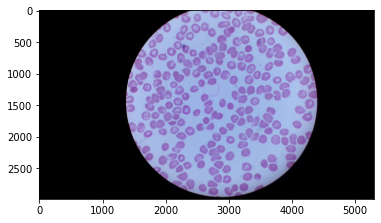

In [177]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
#img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
# img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
#img = cv2.flip(img, 1)
plt.imshow(img)

In [178]:
# cv2.circle(img, df_file['position'][240][0], 1, (0,255,0), 50)
# plt.imshow(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


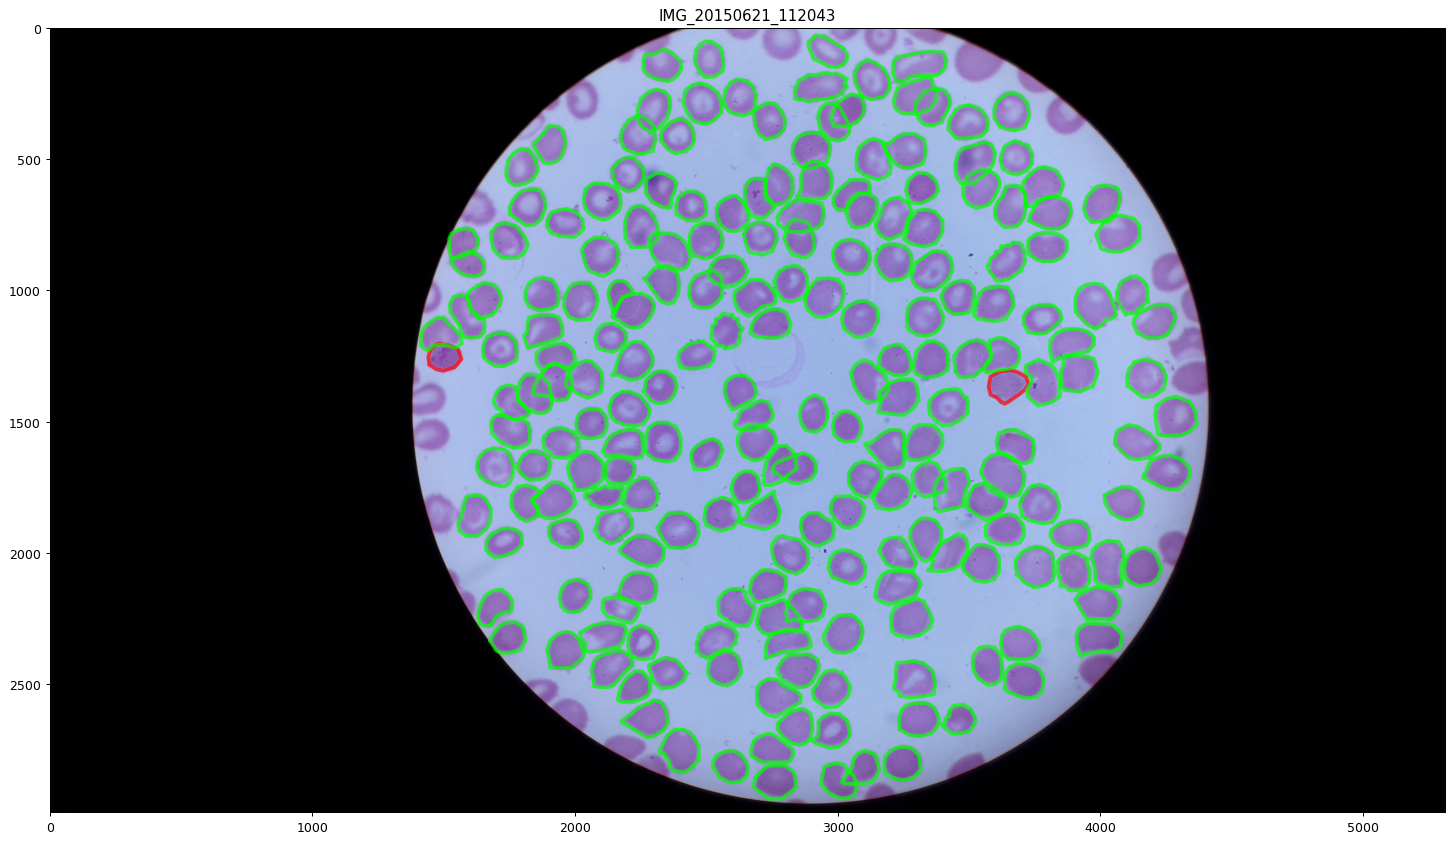

In [179]:
fig = plt.figure(1, figsize=(20,20), dpi=90)
df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position'], row), axis = 1)
plt.imshow(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


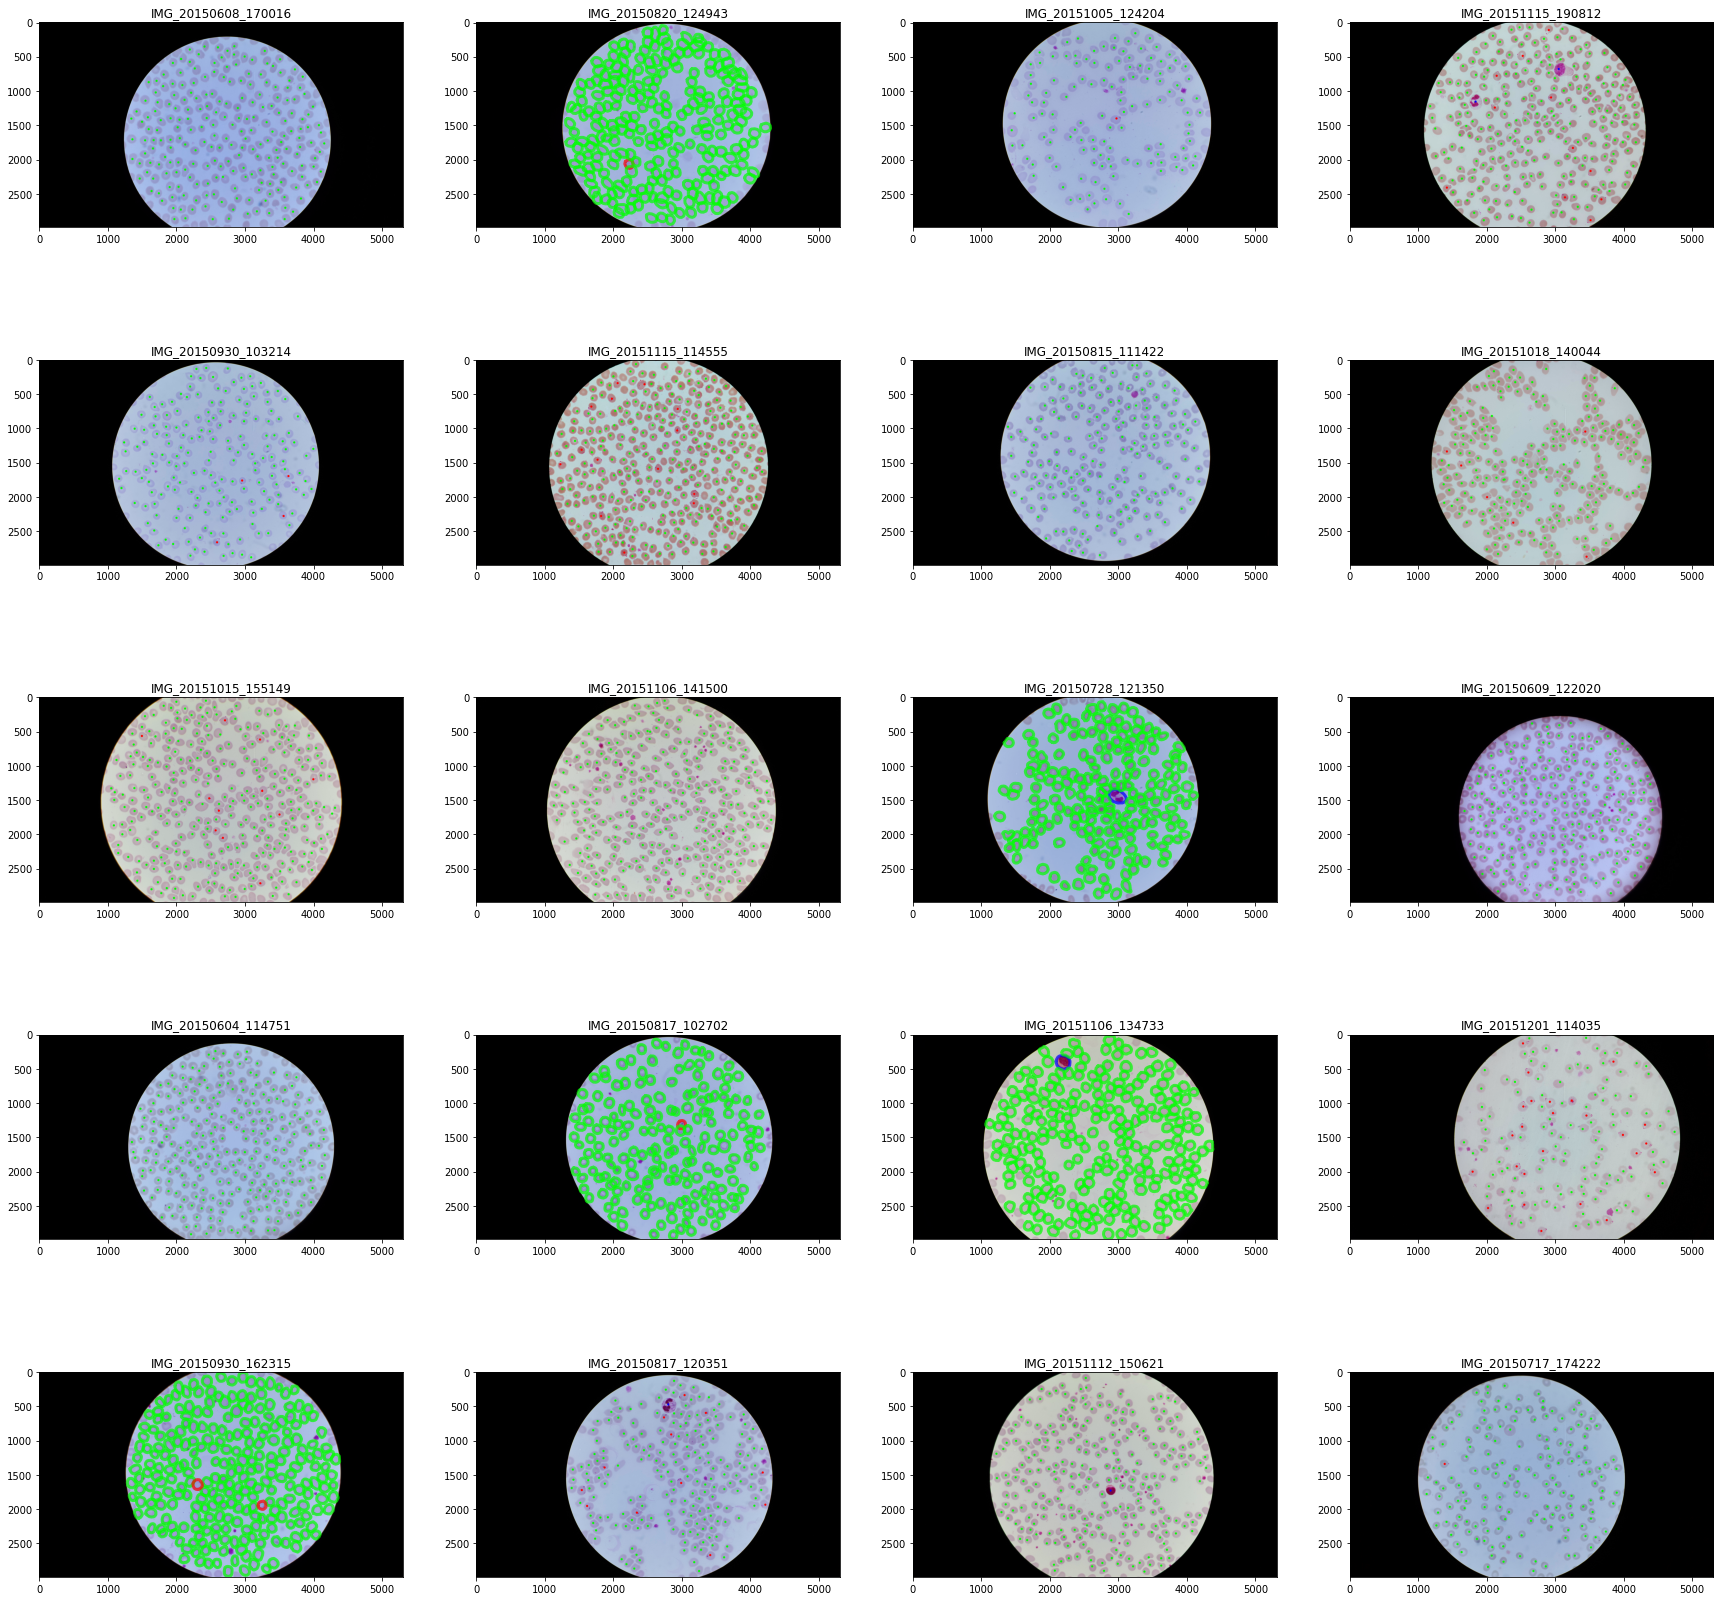

In [180]:
secure_random = random.SystemRandom()

w, h = 10, 10
fig=plt.figure(figsize=(30, 30))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    filename = secure_random.choice(df['filename'].unique())
    df_file = df[df['filename'] == filename]
    #print(filename)
    img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
    df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position'], row = row, rows = rows, columns = columns, i = i, point_size= 30), axis = 1)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Polygons to mask

In [181]:
def poly_mask(row):
    poly = Polygon(row['position'])
    mask = poly.ravel().tolist()

In [182]:
filename =  'IMG_20150820_124943'

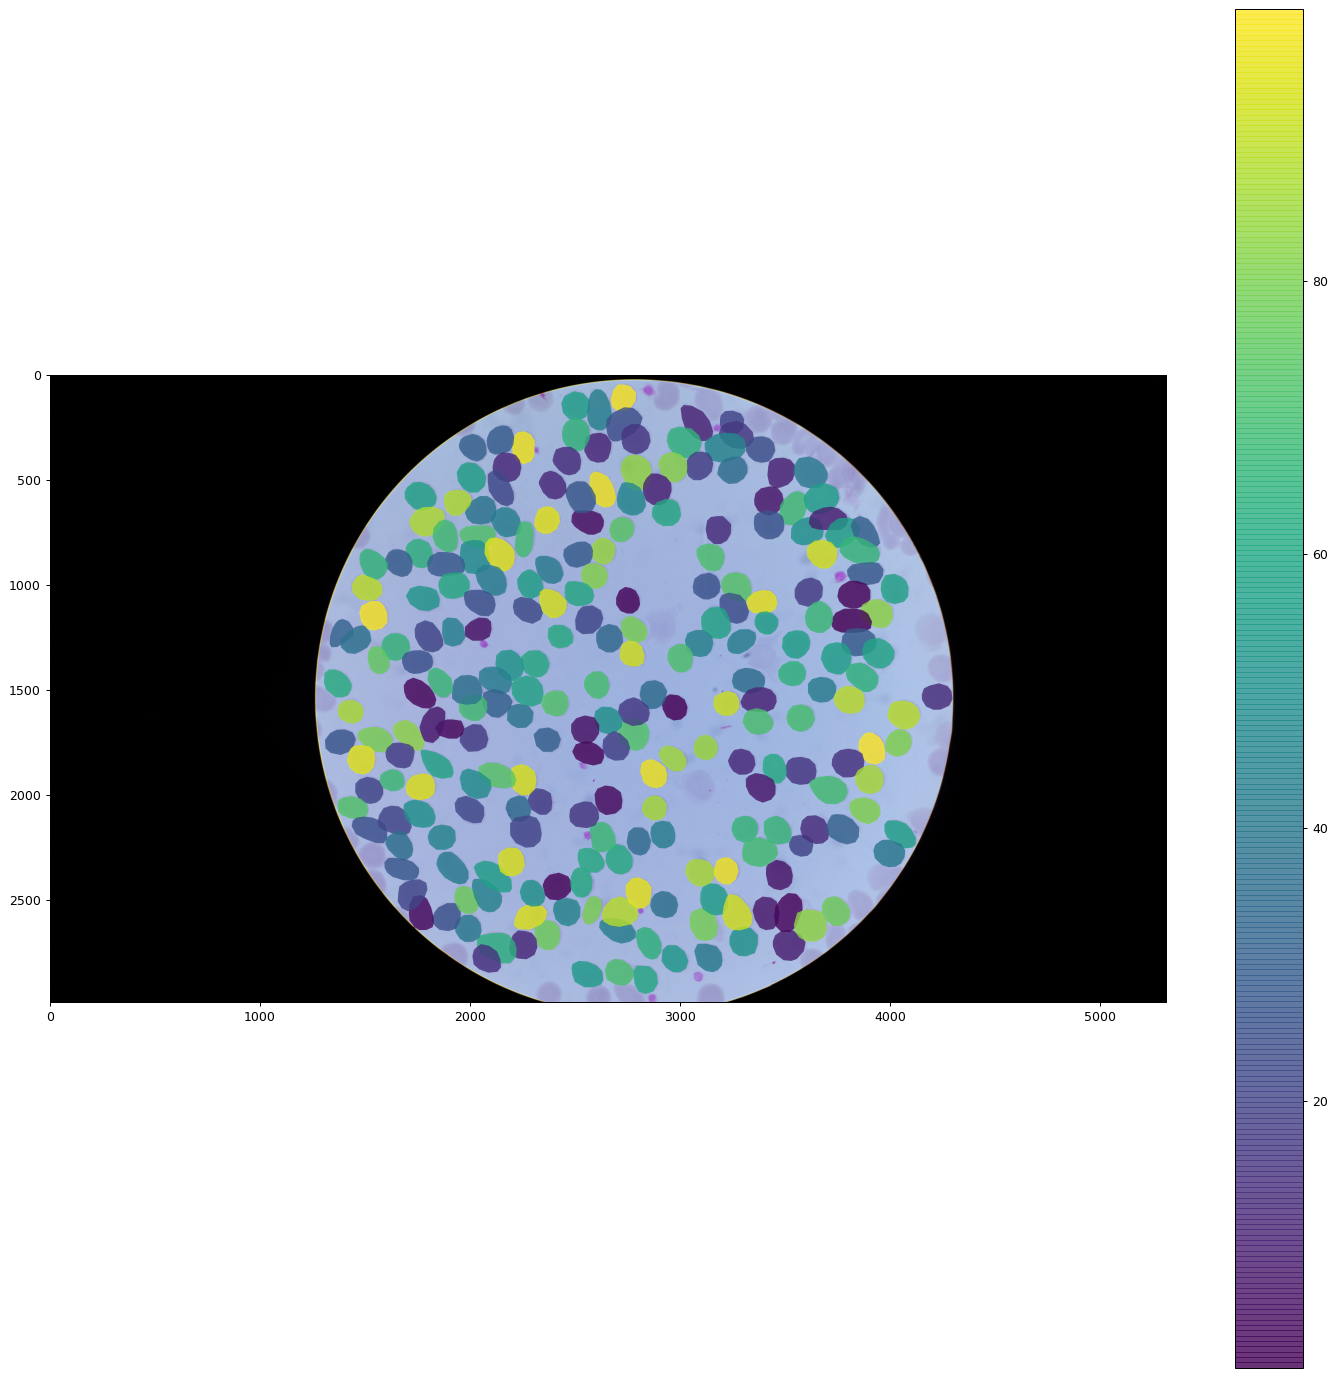

In [183]:
patches = []
patches = [ Polygon(poly) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position'] ]

img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)
empty_img = Image.new("L", [img.shape[1], img.shape[0]], 0)
mask = np.array(empty_img)

fig = plt.figure(1, figsize=(20,20), dpi=90)
ax = fig.add_subplot(111)

colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.8)
p.set_array(np.array(colors))
ax.add_collection(p)
fig.colorbar(p, ax=ax)
plt.imshow(img)

image shape:  <PIL.Image.Image image mode=1 size=5312x2988 at 0x7F02F04F0A20>


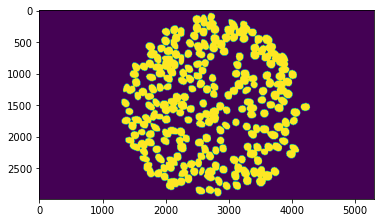

In [184]:
img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)

img = Image.new("L", [img.shape[1], img.shape[0]], 0)
img = img.convert('1')
print('image shape: ', img)
[ ImageDraw.Draw(img).polygon(poly, outline=1, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position']]
mask = np.array(img)

plt.imshow(mask)

img.save('Images/polygon_mask.png')

In [185]:
filename =  'IMG_20150621_112043' #'IMG_20150623_134547' 
df_file = df[df['filename'] == filename]
df_file

Patient no - Cell no         cell     comment annotation_type  \
0                    2-1  Parasitized  No_comment         Polygon   
1                    2-2  Parasitized  No_comment         Polygon   
2                    2-3   Uninfected  No_comment         Polygon   
3                    2-4   Uninfected  No_comment         Polygon   
4                    2-5   Uninfected  No_comment         Polygon   
..                   ...          ...         ...             ...   
204                2-205   Uninfected  No_comment         Polygon   
205                2-206   Uninfected  No_comment         Polygon   
206                2-207   Uninfected  No_comment         Polygon   
207                2-208   Uninfected  No_comment         Polygon   
208                2-209   Uninfected  No_comment         Polygon   

    Number of points                                           position  \
0                 14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
1                 11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
2                 11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
3                 12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
4                 10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   
..               ...                                                ...   
204               12  [(3293, 1312), (3289, 1277), (3303, 1227), (33...   
205               21  [(3351, 1471), (3351, 1454), (3346, 1440), (33...   
206               12  [(3259, 1631), (3259, 1594), (3271, 1552), (32...   
207               18  [(3253, 1587), (3253, 1548), (3241, 1534), (32...   
208               16  [(4166, 1704), (4176, 1688), (4184, 1664), (41...   

                filename                                           txt_path  \
0    IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1    IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2    IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3    IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4    IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
..                   ...                                                ...   
204  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
205  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
206  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
207  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
208  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   

                                              img_path  \
0    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
..                                                 ...   
204  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
205  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
206  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
207  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
208  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   

                          bbx  patient_n_path  
0    [3575, 1304, 3727, 1432]               3  
1    [1441, 1202, 1568, 1307]               3  
2    [2856, 1398, 2960, 1541]               3  
3    [2982, 1460, 3091, 1578]               3  
4    [3043, 1651, 3169, 1788]               3  
..                        ...             ...  
204  [3289, 1194, 3419, 1331]               3  
205  [3346, 1375, 3496, 1515]               3  
206  [3259, 1511, 3400, 1647]               3  
207  [3104, 1532, 3255, 1679]               3  
208  [4162, 1631, 4342, 1758]               3  

[209 rows x 11 columns]

## Connected Components

In [186]:
def connected_component_label(img):
    # https://iq.opengenus.org/connected-component-labeling/
    # https://stackoverflow.com/questions/13572448/replace-values-of-a-numpy-index-array-with-values-of-a-list


    num_labels, labels = cv2.connectedComponents(img)
    
    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    palette = np.arange(1, 179)
    list_rand_nums = np.random.randint(1,179, 179)
    # list_rand_nums gives the new values you wish palette to be mapped to.
    index = np.digitize(label_hue.ravel(), palette, right=True)
    random_hue = np.uint8(list_rand_nums[index].reshape(label_hue.shape))

    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([random_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    
    
    # Showing Original Image
    plt.imshow(mask)
    plt.axis("off")
    plt.title("Orginal Image")
    plt.show()
    
    #Showing Image after Component Labeling
    plt.imshow(cv2.cvtColor(labeled_img, cv2.COLOR_BGRA2RGB))
    plt.axis('off')
    plt.title("Image after Component Labeling")
    plt.show()

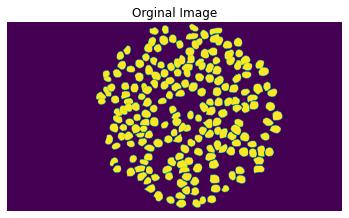

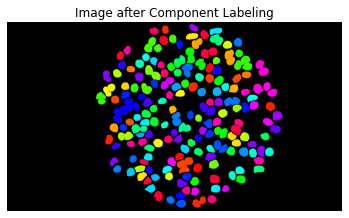

In [187]:
img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)
img = Image.new("L", [img.shape[1], img.shape[0]], 0)
#img = img.convert('1')
[ ImageDraw.Draw(img).polygon(poly, outline=0, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position']]
mask = np.array(img)
connected_component_label(mask)

In [188]:
num_labels, labels = cv2.connectedComponents(mask)
print(len(labels[0]))
print(np.max(labels))

5312
175


In [189]:
df

Patient no - Cell no        cell     comment annotation_type  \
0                    3-1  Uninfected  No_comment         Polygon   
1                    3-2  Uninfected  No_comment         Polygon   
2                    3-3  Uninfected  No_comment         Polygon   
3                    3-4  Uninfected  No_comment         Polygon   
4                    3-5  Uninfected  No_comment         Polygon   
..                   ...         ...         ...             ...   
199                5-200  Uninfected  No_Comment           Point   
200                5-201  Uninfected  No_Comment           Point   
201                5-202  Uninfected  No_Comment           Point   
202                5-203  Uninfected  No_Comment           Point   
203                5-204  Uninfected  No_Comment           Point   

    Number of points                                           position  \
0                 14  [(2934, 38), (2955, 33), (2992, 35), (3015, 44...   
1                 15  [(3013, 141), (2993, 144), (2972, 157), (2956,...   
2                 14  [(2730, 135), (2704, 144), (2672, 165), (2661,...   
3                 14  [(2379, 137), (2353, 149), (2334, 169), (2332,...   
4                 14  [(2575, 140), (2548, 145), (2522, 161), (2500,...   
..               ...                                                ...   
199                1                                      [(2080, 643)]   
200                1                                      [(1790, 606)]   
201                1                                      [(1757, 756)]   
202                1                                      [(1860, 856)]   
203                1                                      [(1623, 683)]   

                filename                                           txt_path  \
0    IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1    IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2    IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3    IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4    IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
..                   ...                                                ...   
199  IMG_20151115_181859  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
200  IMG_20151115_181859  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
201  IMG_20151115_181859  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
202  IMG_20151115_181859  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
203  IMG_20151115_181859  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   

                                              img_path  \
0    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4    ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
..                                                 ...   
199  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
200  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
201  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
202  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
203  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   

                        bbx  patient_n_path  
0     [2905, 33, 3033, 131]              40  
1    [2951, 141, 3071, 272]              40  
2    [2658, 135, 2801, 276]              40  
3    [2332, 137, 2454, 265]              40  
4    [2499, 140, 2631, 272]              40  
..                      ...             ...  
199  [2010, 573, 2150, 713]             119  
200  [1720, 536, 1860, 676]             119  
201  [1687, 686, 1827, 826]             119  
202  [1790, 786, 1930, 926]             119  
203  [1553, 613, 1693, 753]             119  

[196934 rows x 11 columns]

# Cutting and tiling images and labels

(2988, 5312)


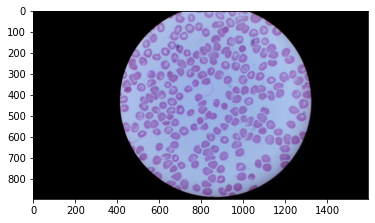

In [190]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
resize_factor = .3
print(img.shape[:2])
resized_img = cv2.resize(img, (int(round(img.shape[1] * resize_factor)), int(round(img.shape[0] * resize_factor))), interpolation=cv2.INTER_AREA)
plt.imshow(resized_img)

In [191]:
df_file.head()

Patient no - Cell no         cell     comment annotation_type  \
0                  2-1  Parasitized  No_comment         Polygon   
1                  2-2  Parasitized  No_comment         Polygon   
2                  2-3   Uninfected  No_comment         Polygon   
3                  2-4   Uninfected  No_comment         Polygon   
4                  2-5   Uninfected  No_comment         Polygon   

  Number of points                                           position  \
0               14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
1               11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
2               11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
3               12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
4               10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   

              filename                                           txt_path  \
0  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4  IMG_20150621_112043  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   

                                            img_path  \
0  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   

                        bbx  patient_n_path  
0  [3575, 1304, 3727, 1432]               3  
1  [1441, 1202, 1568, 1307]               3  
2  [2856, 1398, 2960, 1541]               3  
3  [2982, 1460, 3091, 1578]               3  
4  [3043, 1651, 3169, 1788]               3

## Cut fit to circle

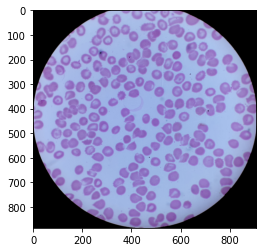

In [192]:
# select circle only
img_gray = rgb2gray(resized_img)
th = threshold_otsu(img_gray)
fg = img_gray>th
# Find the bounding box of those pixels
coords = np.array(np.nonzero(fg))
top_left = np.min(coords, axis=1)
bottom_right = np.max(coords, axis=1)

#set all under threshhold values to zero 
img_circle = resized_img*gray2rgb(fg)

img_cropped = img_circle[top_left[0]:bottom_right[0],
            top_left[1]:bottom_right[1]]

plt.imshow(img_cropped)

In [193]:
def adjust_poly_coord(poly_coords, removed_left, removed_top):
    '''returns a list of polgones with adjusted coordinates'''
    return [(poly[0] - removed_left, poly [1] - removed_top) for poly in poly_coords]
        
def circle_crop(img_path):
    '''returns a cropped image according to the circle as well as the removed top part and removed left part of the image'''
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)

    # select circle only
    img_gray = rgb2gray(img)
    th = threshold_otsu(img_gray)
    fg = img_gray>th
    # Find the bounding box of those pixels
    coords = np.array(np.nonzero(fg))
    min_coords = np.min(coords, axis=1) # [y1, x1]
    max_coords = np.max(coords, axis=1) # [y2, x2]
    
    print('min_coords:', min_coords)
    print('max_coords:', max_coords)
    
    if img_path in dict_poly:
        list_list_tuples_poly = dict_poly[img_path]
        list_tuples_poly = [item for sublist in list_list_tuples_poly for item in sublist]
        list_poly = list(sum(list_tuples_poly, ()))
        x = list_poly[0::2]
        y = list_poly[1::2]
        
        if min(y) < min_coords[0]:
            min_coords[0] = min(y)
        if min(x) < min_coords[1]:
            min_coords[1] = min(x)
        if max(y) > max_coords[0]:
            max_coords[0] = max(y)
        if max(x) > max_coords[1]:
            max_coords[1] = max(x)
            
        print('img_shape: ', img.shape)
        print('new min_coords:', min_coords)
        print('new max_coords:', max_coords)
        print('x min, x max: ', min(x), max(x))
        print('y min, y max: ', min(y), max(y))
    
    #set all under threshhold values to zero 
    img_circle = img*gray2rgb(fg)
    
    ''' image[start_row:end_row, start_column:end_column] e.g. image[30:250, 100:230] or [x1:x2, y1:y2]
    You can see that the waterfall goes vertically starting at about 30px and ending at around 250px.
    You can see that the waterfall goes horizontally from around 100px to around 230px. 
                '''

    img_cropped = img[min_coords[0]:max_coords[0],
                min_coords[1]:max_coords[1]]
    
    return img_cropped, min_coords[0], min_coords[1]

In [194]:
def adjust_coordinates(img_path, position):
    '''returns adjusted coordinates and fitted circle img path '''
    removed_top, removed_left, outname_im = dict_rmv_fit_to_circle[img_path]
    adjusted_polys = adjust_poly_coord(position, removed_left, removed_top)
    return adjusted_polys


In [195]:
def poly2mask(filename, img_path = 'img_path', out_path = '../data/masks', poly_position = 'position'):
    img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), img_path].iloc[-1], cv2.IMREAD_COLOR)
    img = Image.new("L", [img.shape[1], img.shape[0]], 0)
    img = img.convert('1')
    [ ImageDraw.Draw(img).polygon(poly, outline=0, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), poly_position]]

    
    if not os.path.isdir(out_path):
        os.makedirs(out_path)

    mask_path = f'{out_path}/mask_{filename}.png'
    img.save(mask_path)
    return mask_path

def poly2multimask(filename, img_path = 'img_path', out_path = '../data/masks', poly_position = 'adjusted_position', outname_mask = False):
    # fill index number per polygon
    img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), img_path].iloc[-1], cv2.IMREAD_COLOR)
    np_img = np.zeros(shape=[img.shape[0], img.shape[1], 1], dtype=np.uint16)

    # This gets polygons filled with an index number
    for index, poly in enumerate(df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), poly_position]):
        poly = np.array(poly)
        rr, cc = polygon(poly[::,1], poly[::,0])
        np_img[rr, cc] = index
    
    #np_img = np_img.astype(np.uint16) if np_img.max()<2**16-1 else np_img.astype(np.uint32)
        
    if not os.path.isdir(out_path):
        os.makedirs(out_path)    
    
    if outname_mask:
        cv2.imwrite(outname_mask, np_img)
    else:    
        outname_mask = f'{outname_mask}/mask_{filename}.png'
        cv2.imwrite(outname_mask, np_img)
    return outname_mask

In [196]:
check_if_outdir_im_circle = os.path.isdir('../data/fit_to_circle')

if not check_if_outdir_im_circle:
    os.makedirs('../data/fit_to_circle')

In [197]:
 # we want to save all images and also create a dictionary with the pixels removed at the top and bottom
dict_rmv_fit_to_circle = {}
dict_patient_n = dict(zip(df['img_path'], df['patient_n_path']))
dict_filename = dict(zip(df['img_path'], df['filename']))
dict_poly = {}

for img_path in df['img_path'].unique():
    if not df.loc[(df['annotation_type'] == 'Polygon') & (df['img_path'] == img_path), 'img_path'].empty:
        print('poly: ', img_path)
        dict_poly[img_path] = [poly for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['img_path'] == img_path), 'position']]
        
    img_cropped, removed_top, removed_left = circle_crop(img_path)  
    patient_n_path = dict_patient_n[img_path]
    filename = dict_filename[img_path]
    outname_im = os.path.join('../data/fit_to_circle/cropped_P' + str(patient_n_path) + '_' + filename + '.png')
    
    print('saving: ', outname_im)
    cv2.imwrite(outname_im, img_cropped)
    
    dict_rmv_fit_to_circle[img_path] = [removed_top, removed_left, outname_im]
    

poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/221C79P40ThinF/Img/IMG_20150817_103139.jpg
min_coords: [   9 1282]
max_coords: [2987 4352]
img_shape:  (2988, 5312, 3)
new min_coords: [   9 1282]
new max_coords: [2987 4352]
x min, x max:  1398 4332
y min, y max:  33 2952
saving:  ../data/fit_to_circle/cropped_P40_IMG_20150817_103139.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/221C79P40ThinF/Img/IMG_20150817_103303.jpg
min_coords: [  65 1326]
max_coords: [2987 4300]
img_shape:  (2988, 5312, 3)
new min_coords: [  65 1326]
new max_coords: [2987 4300]
x min, x max:  1379 4289
y min, y max:  72 2921
saving:  ../data/fit_to_circle/cropped_P40_IMG_20150817_103303.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/221C79P40ThinF/Img/IMG_20150817_102702.jpg
min_coords: [  43 1313]
max_coords: [2987 4324]
img_shape:  (2988, 5312, 3)
new min_coords: [  43 1313]
new max_coords: [2987 4324]
x min, x max:  1370 4207
y min, y max:  65 2983
saving:  ../data/fit_to_circle/cropped

poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/323C231ThinF/Img/IMG_20151112_152234.jpg
min_coords: [   0 1047]
max_coords: [2987 4443]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1047]
new max_coords: [2987 4443]
x min, x max:  1067 4425
y min, y max:  21 2984
saving:  ../data/fit_to_circle/cropped_P202_IMG_20151112_152234.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/228C86P47ThinF/Img/IMG_20150820_124943.jpg
min_coords: [  25 1261]
max_coords: [2987 4295]
img_shape:  (2988, 5312, 3)
new min_coords: [  25 1261]
new max_coords: [2987 4297]
x min, x max:  1305 4297
y min, y max:  46 2948
saving:  ../data/fit_to_circle/cropped_P47_IMG_20150820_124943.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/228C86P47ThinF/Img/IMG_20150820_125057.jpg
min_coords: [  24 1259]
max_coords: [2987 4296]
img_shape:  (2988, 5312, 3)
new min_coords: [  24 1259]
new max_coords: [2987 4296]
x min, x max:  1273 4249
y min, y max:  62 2980
saving:  ../data/fit_to_circle/cropped_

poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/309C216ThinF/Img/IMG_20151106_135653.jpg
min_coords: [   0 1035]
max_coords: [2987 4375]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1035]
new max_coords: [2987 4375]
x min, x max:  1099 4330
y min, y max:  1 2981
saving:  ../data/fit_to_circle/cropped_P203_IMG_20151106_135653.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/309C216ThinF/Img/IMG_20151106_134733.jpg
min_coords: [   0 1029]
max_coords: [2987 4382]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1029]
new max_coords: [2987 4382]
x min, x max:  1063 4379
y min, y max:  13 2987
saving:  ../data/fit_to_circle/cropped_P203_IMG_20151106_134733.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/343C160P121ThinF/Img/IMG_20151116_093109.jpg
min_coords: [   0 1115]
max_coords: [2987 4264]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1115]
new max_coords: [2987 4264]
x min, x max:  1178 4258
y min, y max:  21 2980
saving:  ../data/fit_to_circle/cropped_

poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/306C213ThinF/Img/IMG_20151106_112853.jpg
min_coords: [   0 1037]
max_coords: [2987 4383]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1037]
new max_coords: [2987 4383]
x min, x max:  1060 4346
y min, y max:  31 2971
saving:  ../data/fit_to_circle/cropped_P204_IMG_20151106_112853.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/306C213ThinF/Img/IMG_20151106_112252.jpg
min_coords: [   0 1005]
max_coords: [2987 4409]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1005]
new max_coords: [2987 4409]
x min, x max:  1011 4393
y min, y max:  1 2986
saving:  ../data/fit_to_circle/cropped_P204_IMG_20151106_112252.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/306C213ThinF/Img/IMG_20151106_112759.jpg
min_coords: [  35 1086]
max_coords: [2987 4346]
img_shape:  (2988, 5312, 3)
new min_coords: [  35 1086]
new max_coords: [2987 4346]
x min, x max:  1154 4290
y min, y max:  99 2948
saving:  ../data/fit_to_circle/cropped_P204

poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/270C122P83ThinF/Img/IMG_20151002_144341.jpg
min_coords: [   0 1277]
max_coords: [2987 4379]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1277]
new max_coords: [2987 4379]
x min, x max:  1334 4295
y min, y max:  10 2972
saving:  ../data/fit_to_circle/cropped_P83_IMG_20151002_144341.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/270C122P83ThinF/Img/IMG_20151002_144855.jpg
min_coords: [   0 1296]
max_coords: [2987 4364]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1296]
new max_coords: [2987 4364]
x min, x max:  1317 4288
y min, y max:  30 2964
saving:  ../data/fit_to_circle/cropped_P83_IMG_20151002_144855.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/270C122P83ThinF/Img/IMG_20151002_145014.jpg
min_coords: [   0 1285]
max_coords: [2987 4378]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1285]
new max_coords: [2987 4378]
x min, x max:  1350 4346
y min, y max:  16 2966
saving:  ../data/fit_to_circle/crop

poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/208C67P28N_ThinF/Img/IMG_20150819_121456.jpg
min_coords: [  32 1036]
max_coords: [2987 4131]
img_shape:  (2988, 5312, 3)
new min_coords: [  32 1036]
new max_coords: [2987 4131]
x min, x max:  1149 4038
y min, y max:  55 2946
saving:  ../data/fit_to_circle/cropped_P28_IMG_20150819_121456.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/208C67P28N_ThinF/Img/IMG_20150819_115417.jpg
min_coords: [  73 1090]
max_coords: [2987 4082]
img_shape:  (2988, 5312, 3)
new min_coords: [  73 1090]
new max_coords: [2987 4082]
x min, x max:  1108 3998
y min, y max:  101 2986
saving:  ../data/fit_to_circle/cropped_P28_IMG_20150819_115417.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/208C67P28N_ThinF/Img/IMG_20150819_121240.jpg
min_coords: [  48 1058]
max_coords: [2987 4113]
img_shape:  (2988, 5312, 3)
new min_coords: [  48 1058]
new max_coords: [2987 4113]
x min, x max:  1176 3987
y min, y max:  53 2983
saving:  ../data/fit_to_circle/

poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/211C70P31_ThinF/Img/IMG_20150813_131022.jpg
min_coords: [  26 1089]
max_coords: [2987 4079]
img_shape:  (2988, 5312, 3)
new min_coords: [  26 1089]
new max_coords: [2987 4079]
x min, x max:  1301 4007
y min, y max:  130 2907
saving:  ../data/fit_to_circle/cropped_P31_IMG_20150813_131022.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/236C94P55ThinF/Img/IMG_20150821_165118.jpg
min_coords: [   0 1230]
max_coords: [2909 4172]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1230]
new max_coords: [2909 4172]
x min, x max:  1231 4145
y min, y max:  1 2895
saving:  ../data/fit_to_circle/cropped_P55_IMG_20150821_165118.png
poly:  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/236C94P55ThinF/Img/IMG_20150821_170403.jpg
min_coords: [   0 1232]
max_coords: [2907 4174]
img_shape:  (2988, 5312, 3)
new min_coords: [   0 1232]
new max_coords: [2907 4174]
x min, x max:  1267 4141
y min, y max:  59 2861
saving:  ../data/fit_to_circle/croppe

min_coords: [   0 1073]
max_coords: [2987 4421]
saving:  ../data/fit_to_circle/cropped_P211_IMG_20151112_144613.png
min_coords: [   0 1289]
max_coords: [2982 4395]
saving:  ../data/fit_to_circle/cropped_P64_IMG_20150918_165125.png
min_coords: [   0 1314]
max_coords: [2949 4337]
saving:  ../data/fit_to_circle/cropped_P64_IMG_20150918_164250.png
min_coords: [   0 1331]
max_coords: [2934 4318]
saving:  ../data/fit_to_circle/cropped_P64_IMG_20150918_164331.png
min_coords: [   0 1321]
max_coords: [2943 4330]
saving:  ../data/fit_to_circle/cropped_P64_IMG_20150918_165016.png
min_coords: [   0 1308]
max_coords: [2959 4361]
saving:  ../data/fit_to_circle/cropped_P64_IMG_20150918_164553.png
min_coords: [  0 998]
max_coords: [2987 4327]
saving:  ../data/fit_to_circle/cropped_P111_IMG_20151115_115805.png
min_coords: [  0 984]
max_coords: [2987 4341]
saving:  ../data/fit_to_circle/cropped_P111_IMG_20151115_115950.png
min_coords: [   0 1026]
max_coords: [2987 4299]
saving:  ../data/fit_to_circle/cr

min_coords: [   0 1072]
max_coords: [2987 4422]
saving:  ../data/fit_to_circle/cropped_P217_IMG_20151112_162940.png
min_coords: [   0 1090]
max_coords: [2987 4410]
saving:  ../data/fit_to_circle/cropped_P217_IMG_20151112_162759.png
min_coords: [   0 1079]
max_coords: [2987 4417]
saving:  ../data/fit_to_circle/cropped_P217_IMG_20151112_162909.png
min_coords: [   0 1110]
max_coords: [2987 4394]
saving:  ../data/fit_to_circle/cropped_P217_IMG_20151112_162843.png
min_coords: [   0 1087]
max_coords: [2987 4411]
saving:  ../data/fit_to_circle/cropped_P217_IMG_20151112_163036.png
min_coords: [   0 1088]
max_coords: [2987 4404]
saving:  ../data/fit_to_circle/cropped_P218_IMG_20151112_113915.png
min_coords: [   0 1087]
max_coords: [2987 4405]
saving:  ../data/fit_to_circle/cropped_P218_IMG_20151112_113953.png
min_coords: [   0 1044]
max_coords: [2987 4439]
saving:  ../data/fit_to_circle/cropped_P218_IMG_20151112_113735.png
min_coords: [   0 1039]
max_coords: [2987 4444]
saving:  ../data/fit_to_

min_coords: [   0 1299]
max_coords: [2987 4365]
saving:  ../data/fit_to_circle/cropped_P97_IMG_20151005_141803.png
min_coords: [   0 1319]
max_coords: [2986 4340]
saving:  ../data/fit_to_circle/cropped_P97_IMG_20151005_140538.png
min_coords: [   0 1295]
max_coords: [2987 4369]
saving:  ../data/fit_to_circle/cropped_P97_IMG_20151005_140646.png
min_coords: [   0 1324]
max_coords: [2985 4352]
saving:  ../data/fit_to_circle/cropped_P97_IMG_20151005_141321.png
min_coords: [   0 1324]
max_coords: [2941 4327]
saving:  ../data/fit_to_circle/cropped_P65_IMG_20150918_170850.png
min_coords: [   0 1328]
max_coords: [2937 4324]
saving:  ../data/fit_to_circle/cropped_P65_IMG_20150918_172214.png
min_coords: [   0 1344]
max_coords: [2923 4304]
saving:  ../data/fit_to_circle/cropped_P65_IMG_20150918_171751.png
min_coords: [   0 1328]
max_coords: [2939 4331]
saving:  ../data/fit_to_circle/cropped_P65_IMG_20150918_172053.png
min_coords: [   0 1300]
max_coords: [2970 4374]
saving:  ../data/fit_to_circle/c

min_coords: [  13 1051]
max_coords: [2987 4096]
saving:  ../data/fit_to_circle/cropped_P20_IMG_20150803_112733.png
min_coords: [   2 1020]
max_coords: [2987 4096]
saving:  ../data/fit_to_circle/cropped_P20_IMG_20150803_112858.png
min_coords: [   1 1022]
max_coords: [2987 4101]
saving:  ../data/fit_to_circle/cropped_P20_IMG_20150803_111333.png
min_coords: [   0 1031]
max_coords: [2987 4388]
saving:  ../data/fit_to_circle/cropped_P225_IMG_20151106_115440.png
min_coords: [   0 1025]
max_coords: [2987 4393]
saving:  ../data/fit_to_circle/cropped_P225_IMG_20151106_114526.png
min_coords: [  0 959]
max_coords: [2987 4446]
saving:  ../data/fit_to_circle/cropped_P225_IMG_20151106_114611.png
min_coords: [  28 1083]
max_coords: [2987 4349]
saving:  ../data/fit_to_circle/cropped_P225_IMG_20151106_114910.png
min_coords: [   0 1063]
max_coords: [2987 4367]
saving:  ../data/fit_to_circle/cropped_P225_IMG_20151106_131748.png
min_coords: [   0 1000]
max_coords: [2987 4408]
saving:  ../data/fit_to_circl

min_coords: [  37 1070]
max_coords: [2987 4074]
saving:  ../data/fit_to_circle/cropped_P71_IMG_20150930_110052.png
min_coords: [  36 1086]
max_coords: [2987 4337]
saving:  ../data/fit_to_circle/cropped_P228_IMG_20151106_154533.png
min_coords: [  41 1089]
max_coords: [2987 4335]
saving:  ../data/fit_to_circle/cropped_P228_IMG_20151106_154510.png
min_coords: [   0 1043]
max_coords: [2987 4374]
saving:  ../data/fit_to_circle/cropped_P228_IMG_20151106_153947.png
min_coords: [   7 1061]
max_coords: [2987 4360]
saving:  ../data/fit_to_circle/cropped_P228_IMG_20151106_154339.png
min_coords: [   7 1062]
max_coords: [2987 4360]
saving:  ../data/fit_to_circle/cropped_P228_IMG_20151106_154016.png
min_coords: [  77 1263]
max_coords: [2987 4219]
saving:  ../data/fit_to_circle/cropped_P52_IMG_20150821_123116.png
min_coords: [  72 1458]
max_coords: [2987 4464]
saving:  ../data/fit_to_circle/cropped_P52_IMG_20150821_124504.png
min_coords: [  78 1263]
max_coords: [2987 4219]
saving:  ../data/fit_to_cir

min_coords: [  73 1096]
max_coords: [2987 4087]
saving:  ../data/fit_to_circle/cropped_P30_IMG_20150819_140143.png
min_coords: [  68 1100]
max_coords: [2987 4095]
saving:  ../data/fit_to_circle/cropped_P30_IMG_20150819_135613.png
min_coords: [  42 1052]
max_coords: [2987 4123]
saving:  ../data/fit_to_circle/cropped_P30_IMG_20150819_135421.png
min_coords: [  67 1094]
max_coords: [2987 4094]
saving:  ../data/fit_to_circle/cropped_P30_IMG_20150819_135705.png
min_coords: [  72 1093]
max_coords: [2987 4088]
saving:  ../data/fit_to_circle/cropped_P30_IMG_20150819_140652.png
min_coords: [   0 1025]
max_coords: [2987 4386]
saving:  ../data/fit_to_circle/cropped_P230_IMG_20151106_133247.png
min_coords: [   0 1013]
max_coords: [2987 4398]
saving:  ../data/fit_to_circle/cropped_P230_IMG_20151106_133012.png
min_coords: [   0 1012]
max_coords: [2987 4398]
saving:  ../data/fit_to_circle/cropped_P230_IMG_20151106_133043.png
min_coords: [  0 980]
max_coords: [2987 4425]
saving:  ../data/fit_to_circle/

min_coords: [   0 1025]
max_coords: [2987 4119]
saving:  ../data/fit_to_circle/cropped_P74_IMG_20150930_134751.png
min_coords: [  29 1057]
max_coords: [2987 4079]
saving:  ../data/fit_to_circle/cropped_P74_IMG_20150930_134355.png
min_coords: [   0 1031]
max_coords: [2987 4109]
saving:  ../data/fit_to_circle/cropped_P74_IMG_20150930_134949.png
min_coords: [  45 1072]
max_coords: [2987 4064]
saving:  ../data/fit_to_circle/cropped_P74_IMG_20150930_134429.png
min_coords: [   0 1552]
max_coords: [2987 4784]
saving:  ../data/fit_to_circle/cropped_P139_IMG_20151201_153246.png
min_coords: [   0 1554]
max_coords: [2987 4777]
saving:  ../data/fit_to_circle/cropped_P139_IMG_20151201_153846.png
min_coords: [   0 1555]
max_coords: [2987 4778]
saving:  ../data/fit_to_circle/cropped_P139_IMG_20151201_151903.png
min_coords: [   0 1555]
max_coords: [2987 4776]
saving:  ../data/fit_to_circle/cropped_P139_IMG_20151201_154337.png
min_coords: [   0 1554]
max_coords: [2987 4786]
saving:  ../data/fit_to_circ

min_coords: [   0 1082]
max_coords: [2987 4410]
saving:  ../data/fit_to_circle/cropped_P236_IMG_20151112_113157.png
min_coords: [   0 1061]
max_coords: [2987 4428]
saving:  ../data/fit_to_circle/cropped_P236_IMG_20151112_111955.png
min_coords: [ 103 1191]
max_coords: [2987 4455]
saving:  ../data/fit_to_circle/cropped_P237_IMG_20151127_115247.png
min_coords: [  69 1157]
max_coords: [2987 4496]
saving:  ../data/fit_to_circle/cropped_P237_IMG_20151127_115545.png
min_coords: [  85 1173]
max_coords: [2987 4477]
saving:  ../data/fit_to_circle/cropped_P237_IMG_20151127_115328.png
min_coords: [  89 1178]
max_coords: [2987 4473]
saving:  ../data/fit_to_circle/cropped_P237_IMG_20151127_115223.png
min_coords: [  89 1176]
max_coords: [2987 4472]
saving:  ../data/fit_to_circle/cropped_P237_IMG_20151127_115306.png
min_coords: [  85 1486]
max_coords: [2987 4496]
saving:  ../data/fit_to_circle/cropped_P53_IMG_20150821_150718.png
min_coords: [ 109 1489]
max_coords: [2987 4453]
saving:  ../data/fit_to_c

min_coords: [   0 1354]
max_coords: [2987 4565]
saving:  ../data/fit_to_circle/cropped_P129_IMG_20151118_153739.png
min_coords: [ 108 1402]
max_coords: [2987 4390]
saving:  ../data/fit_to_circle/cropped_P9_IMG_20150721_161412.png
min_coords: [ 113 1408]
max_coords: [2987 4386]
saving:  ../data/fit_to_circle/cropped_P9_IMG_20150721_161055.png
min_coords: [  89 1390]
max_coords: [2987 4418]
saving:  ../data/fit_to_circle/cropped_P9_IMG_20150721_160944.png
min_coords: [ 108 1403]
max_coords: [2987 4390]
saving:  ../data/fit_to_circle/cropped_P9_IMG_20150721_161243.png
min_coords: [ 107 1452]
max_coords: [2987 4483]
saving:  ../data/fit_to_circle/cropped_P9_IMG_20150721_160406.png
min_coords: [   0 1521]
max_coords: [2987 4815]
saving:  ../data/fit_to_circle/cropped_P137_IMG_20151201_114035.png
min_coords: [   0 1559]
max_coords: [2987 4782]
saving:  ../data/fit_to_circle/cropped_P137_IMG_20151201_120845.png
min_coords: [   0 1560]
max_coords: [2987 4783]
saving:  ../data/fit_to_circle/cro

min_coords: [   0 1310]
max_coords: [2987 4350]
saving:  ../data/fit_to_circle/cropped_P96_IMG_20151005_123857.png
min_coords: [   0 1299]
max_coords: [2987 4363]
saving:  ../data/fit_to_circle/cropped_P96_IMG_20151005_123715.png
min_coords: [   0 1304]
max_coords: [2987 4351]
saving:  ../data/fit_to_circle/cropped_P96_IMG_20151005_124031.png
min_coords: [   0 1313]
max_coords: [2987 4345]
saving:  ../data/fit_to_circle/cropped_P96_IMG_20151005_123441.png
min_coords: [   0 1380]
max_coords: [2987 4568]
saving:  ../data/fit_to_circle/cropped_P133_IMG_20151119_154936.png
min_coords: [   0 1373]
max_coords: [2987 4585]
saving:  ../data/fit_to_circle/cropped_P133_IMG_20151119_155343.png
min_coords: [   0 1378]
max_coords: [2987 4576]
saving:  ../data/fit_to_circle/cropped_P133_IMG_20151119_155156.png
min_coords: [   0 1376]
max_coords: [2987 4577]
saving:  ../data/fit_to_circle/cropped_P133_IMG_20151119_155019.png
min_coords: [   0 1381]
max_coords: [2987 4569]
saving:  ../data/fit_to_circ

min_coords: [   0 1322]
max_coords: [2978 4328]
saving:  ../data/fit_to_circle/cropped_P79_IMG_20151002_104831.png
min_coords: [   1 1334]
max_coords: [2976 4319]
saving:  ../data/fit_to_circle/cropped_P79_IMG_20151002_105018.png
min_coords: [   0 1315]
max_coords: [2987 4336]
saving:  ../data/fit_to_circle/cropped_P84_IMG_20151002_151851.png
min_coords: [   0 1304]
max_coords: [2987 4354]
saving:  ../data/fit_to_circle/cropped_P84_IMG_20151002_152144.png
min_coords: [   0 1319]
max_coords: [2986 4333]
saving:  ../data/fit_to_circle/cropped_P84_IMG_20151002_150931.png
min_coords: [   0 1315]
max_coords: [2987 4341]
saving:  ../data/fit_to_circle/cropped_P84_IMG_20151002_151143.png
min_coords: [   0 1315]
max_coords: [2987 4341]
saving:  ../data/fit_to_circle/cropped_P84_IMG_20151002_151432.png
min_coords: [   0 1313]
max_coords: [2987 4339]
saving:  ../data/fit_to_circle/cropped_P91_IMG_20151004_135449.png
min_coords: [   0 1315]
max_coords: [2987 4349]
saving:  ../data/fit_to_circle/c

min_coords: [   0 1102]
max_coords: [2987 4289]
saving:  ../data/fit_to_circle/cropped_P119_IMG_20151115_181436.png
min_coords: [   0 1093]
max_coords: [2987 4299]
saving:  ../data/fit_to_circle/cropped_P119_IMG_20151115_181558.png
min_coords: [   0 1080]
max_coords: [2987 4312]
saving:  ../data/fit_to_circle/cropped_P119_IMG_20151115_181136.png
min_coords: [   0 1067]
max_coords: [2987 4332]
saving:  ../data/fit_to_circle/cropped_P119_IMG_20151115_181035.png
min_coords: [   0 1071]
max_coords: [2987 4329]
saving:  ../data/fit_to_circle/cropped_P119_IMG_20151115_181859.png


In [198]:
df['adjusted_position'] = df.apply(lambda row: adjust_coordinates(row.img_path, row.position), axis = 1) 
df['img_path_fit2circle'] = df['img_path'].apply(lambda x: dict_rmv_fit_to_circle[x][2])

In [199]:
# creating masks for Polygon set
dict_mask = {}

for img_path in df.loc[(df['annotation_type'] == 'Polygon'), 'img_path'].unique():
    patient_n_path = dict_patient_n[img_path]
    filename = dict_filename[img_path]
    outname_mask = os.path.join('../data/fit_to_circle/masks_cropped_P' + str(patient_n_path) + '_' + filename + '_masks''.png')
    
    print('saving: ', outname_mask)
    outname_mask = poly2multimask(filename, 'img_path_fit2circle',  out_path = '../data/masks_fit2cricle', poly_position = 'adjusted_position', outname_mask = outname_mask)
    
    dict_mask[img_path] = outname_mask

saving:  ../data/fit_to_circle/masks_cropped_P40_IMG_20150817_103139_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P40_IMG_20150817_103303_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P40_IMG_20150817_102702_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P40_IMG_20150817_102823_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P40_IMG_20150817_103901_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P13_IMG_20150725_123938_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P13_IMG_20150725_125213_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P13_IMG_20150725_125847_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P13_IMG_20150725_124606_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P13_IMG_20150725_124830_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P89_IMG_20151004_130810_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P89_IMG_20151004_130408_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P89_IMG

saving:  ../data/fit_to_circle/masks_cropped_P207_IMG_20151112_131731_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P95_IMG_20151005_121656_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P95_IMG_20151005_121425_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P95_IMG_20151005_121554_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P95_IMG_20151005_121343_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P95_IMG_20151005_121048_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P29_IMG_20150819_133447_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P29_IMG_20150819_134326_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P29_IMG_20150819_133236_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P29_IMG_20150819_133350_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P29_IMG_20150819_134112_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P76_IMG_20150930_162315_masks.png
saving:  ../data/fit_to_circle/masks_cropped_P76_IM

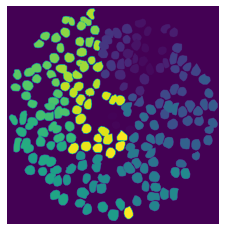

In [201]:
filename = 'IMG_20150621_112043'
img_path = 'img_path_fit2circle'
img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), img_path].iloc[-1], cv2.IMREAD_COLOR)
img = np.zeros(shape=[img.shape[1], img.shape[0], 1], dtype=np.uint8)

for index, poly in enumerate(df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'adjusted_position']):
    poly = np.array(poly)
    rr, cc = polygon(poly[::,0], poly[::,1])
    img[rr, cc] = index
    
plt.imshow(img)
plt.axis('off')
plt.show()

In [202]:
df.loc[(df['annotation_type'] == 'Polygon'), 'mask_path_fit2circle'] = df.loc[(df['annotation_type'] == 'Polygon'), 'img_path'].apply(lambda x: dict_mask[x])
df.head()

Patient no - Cell no        cell     comment annotation_type  \
0                  3-1  Uninfected  No_comment         Polygon   
1                  3-2  Uninfected  No_comment         Polygon   
2                  3-3  Uninfected  No_comment         Polygon   
3                  3-4  Uninfected  No_comment         Polygon   
4                  3-5  Uninfected  No_comment         Polygon   

  Number of points                                           position  \
0               14  [(2934, 38), (2955, 33), (2992, 35), (3015, 44...   
1               15  [(3013, 141), (2993, 144), (2972, 157), (2956,...   
2               14  [(2730, 135), (2704, 144), (2672, 165), (2661,...   
3               14  [(2379, 137), (2353, 149), (2334, 169), (2332,...   
4               14  [(2575, 140), (2548, 145), (2522, 161), (2500,...   

              filename                                           txt_path  \
0  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   

                                            img_path                     bbx  \
0  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   [2905, 33, 3033, 131]   
1  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2951, 141, 3071, 272]   
2  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2658, 135, 2801, 276]   
3  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2332, 137, 2454, 265]   
4  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2499, 140, 2631, 272]   

   patient_n_path                                  adjusted_position  \
0              40  [(1652, 29), (1673, 24), (1710, 26), (1733, 35...   
1              40  [(1731, 132), (1711, 135), (1690, 148), (1674,...   
2              40  [(1448, 126), (1422, 135), (1390, 156), (1379,...   
3              40  [(1097, 128), (1071, 140), (1052, 160), (1050,...   
4              40  [(1293, 131), (1266, 136), (1240, 152), (1218,...   

                                 img_path_fit2circle  \
0  ../data/fit_to_circle/cropped_P40_IMG_20150817...   
1  ../data/fit_to_circle/cropped_P40_IMG_20150817...   
2  ../data/fit_to_circle/cropped_P40_IMG_20150817...   
3  ../data/fit_to_circle/cropped_P40_IMG_20150817...   
4  ../data/fit_to_circle/cropped_P40_IMG_20150817...   

                                mask_path_fit2circle  
0  ../data/fit_to_circle/masks_cropped_P40_IMG_20...  
1  ../data/fit_to_circle/masks_cropped_P40_IMG_20...  
2  ../data/fit_to_circle/masks_cropped_P40_IMG_20...  
3  ../data/fit_to_circle/masks_cropped_P40_IMG_20...  
4  ../data/fit_to_circle/masks_cropped_P40_IMG_20...

In [204]:
def get_bbx(position, annotation_type, bb_pixel):
    if annotation_type == 'Polygon':
        poly_list = np.array([list(ele) for ele in position])
        x_min = np.nanmin(poly_list[:, 0])
        x_max = np.nanmax(poly_list[:, 0])
        y_min = np.nanmin(poly_list[:, 1])
        y_max = np.nanmax(poly_list[:, 1])
        return [x_min, y_min, x_max, y_max]
    if annotation_type == 'Point':
        point_list = np.array(position)
        x_min = int(point_list[:, 0] - 0.5 * bb_pixel)
        x_max = int(point_list[:, 0] + 0.5 * bb_pixel)
        y_min = int(point_list[:, 1] - 0.5 * bb_pixel)
        y_max = int(point_list[:, 1] + 0.5 * bb_pixel)
        return [x_min, y_min, x_max, y_max]

In [205]:
df['adjusted_bbx'] = df.apply(lambda row: get_bbx(row['adjusted_position'], row['annotation_type'], 150), axis = 1)

In [206]:
filename =  'IMG_20150623_134547' 
df_file = df[df['filename'] == filename]
df_file.head()

Patient no - Cell no         cell     comment annotation_type  \
0                  2-1  Parasitized  No_Comment           Point   
1                  2-2   Uninfected  No_Comment           Point   
2                  2-3   Uninfected  No_Comment           Point   
3                  2-4   Uninfected  No_Comment           Point   
4                  2-5   Uninfected  No_Comment           Point   

  Number of points        position             filename  \
0                1  [(1131, 1205)]  IMG_20150623_134547   
1                1  [(3804, 1277)]  IMG_20150623_134547   
2                1  [(1898, 1277)]  IMG_20150623_134547   
3                1  [(1818, 1350)]  IMG_20150623_134547   
4                1  [(1828, 1481)]  IMG_20150623_134547   

                                            txt_path  \
0  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/14...   
1  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/14...   
2  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/14...   
3  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/14...   
4  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/14...   

                                            img_path  \
0  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/14...   
1  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/14...   
2  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/14...   
3  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/14...   
4  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/14...   

                        bbx  patient_n_path adjusted_position  \
0  [1061, 1135, 1201, 1275]               5     [(131, 1171)]   
1  [3734, 1207, 3874, 1347]               5    [(2804, 1243)]   
2  [1828, 1207, 1968, 1347]               5     [(898, 1243)]   
3  [1748, 1280, 1888, 1420]               5     [(818, 1316)]   
4  [1758, 1411, 1898, 1551]               5     [(828, 1447)]   

                                 img_path_fit2circle mask_path_fit2circle  \
0  ../data/fit_to_circle/cropped_P5_IMG_20150623_...                  NaN   
1  ../data/fit_to_circle/cropped_P5_IMG_20150623_...                  NaN   
2  ../data/fit_to_circle/cropped_P5_IMG_20150623_...                  NaN   
3  ../data/fit_to_circle/cropped_P5_IMG_20150623_...                  NaN   
4  ../data/fit_to_circle/cropped_P5_IMG_20150623_...                  NaN   

               adjusted_bbx  
0     [56, 1096, 206, 1246]  
1  [2729, 1168, 2879, 1318]  
2    [823, 1168, 973, 1318]  
3    [743, 1241, 893, 1391]  
4    [753, 1372, 903, 1522]

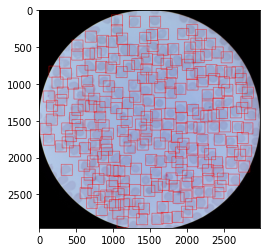

In [207]:
img = cv2.imread(df_file['img_path_fit2circle'].iloc[-1], cv2.IMREAD_COLOR)
img_with_box = bbv.draw_multiple_rectangles(img, df_file['adjusted_bbx'].tolist(), bbox_color = (255, 0, 0), thickness=3)
plt.imshow(img_with_box)

## Crop tiles

In [208]:
def plot_tiles(img, tile_w, tile_h):
    img_shape = img.shape
    tile_size = (tile_w, tile_h)
    offset = (tile_w, tile_h)

    for x in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
        #print(i)
        for y in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
            #print(j)
            #print((offset[1]*i, min(offset[1]*i+tile_size[1], img_shape[0])), (offset[0]*j, min(offset[0]*j+tile_size[0], img_shape[1])))
            x_min = min(offset[1] * x + tile_size[1], img_shape[0])
            x_max = offset[1] * x
            y_min = min(offset[0] * y + tile_size[0], img_shape[1])
            y_max = offset[0]*y
            cv2.rectangle(img, (x_max, x_min), (y_max, y_min), (0, 0, 255), 3)
            #cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
            # Debugging the tiles
            #cv2.imwrite("debug_" + str(i) + "_" + str(j) + ".png", cropped_img)
    plt.imshow(crop_img)

def crop_tiles(img, tile_w, tile_h):
    img_shape = img.shape
    tile_size = (tile_w, tile_h)
    offset = (tile_w, tile_h)
    for x in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
        for y in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
            x_min = offset[1] * x
            x_max = min(offset[1] * x + tile_size[1], img_shape[0])
            y_min = offset[0]*y
            y_max = min(offset[0] * y + tile_size[0], img_shape[1])
            crop_image = img[x_min : x_min + tile_w, y_min: y_min + tile_h]
            cv2.imwrite(f'../cropped/{x_min}_{x_max}_{y_min}_{y_max}.png', crop_image) 
    #plt.imshow(crop_image)


In [209]:
crop_tiles(img_cropped, 256, 256)

In [210]:
def convert_labels(path, x1, y1, x2, y2):
    """
    Definition: Parses label files to extract label and bounding box
        coordinates.  Converts (x1, y1, x1, y2) KITTI format to
        (x, y, width, height) normalized YOLO format.
    """
    def sorting(l1, l2):
        if l1 > l2:
            lmax, lmin = l1, l2
            return lmax, lmin
        else:
            lmax, lmin = l2, l1
            return lmax, lmin
    size = get_img_shape(path)
    xmax, xmin = sorting(x1, x2)
    ymax, ymin = sorting(y1, y2)
    dw = 1./size[1]
    dh = 1./size[0]
    x = (xmin + xmax)/2.0
    y = (ymin + ymax)/2.0
    w = xmax - xmin
    h = ymax - ymin
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

In [211]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : list
        order: [x1, y1, x2, y2] 
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : list
        order: [x1, y1, x2, y2]
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [212]:
def get_intersection_percent(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : list
        order: [x1, y1, x2, y2] 
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : list
        order: [x1, y1, x2, y2]
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [213]:
get_intersection_percent( [0, 0, 10, 10], [0, 0, 20, 20])

1.0

In [214]:
###############################################################################
def slice_img(input_im, input_mask, 
                     filename,
                    outdir_im, 
                     outdir_mask,
                     outdir_label,
                      classes_dic, 
                     category, 
                     box_coords, resize_factor = 1,
                  sliceHeight=256, sliceWidth=256,
                  zero_frac_thresh=0, overlap=0, pad=0, verbose = False,
                  box_coords_dir='', yolt_coords_dir='', create_mask = False):
    '''
    ADAPTED FROM YOLT/SCRIPTS/SLICE_IM.PY
    Assume input_im is rgb
    Slice large image into smaller pieces,
    ignore slices with a percentage null greater then zero_fract_thresh'''
    
    if verbose == True:
        print('############# slice_img #############')
    img = cv2.imread(input_im, 1)  # color
    if create_mask:
        mask = cv2.imread(input_mask, 0)
    category_num = [classes_dic[k] for k in category] 

    resized_img = cv2.resize(img, (int(round(img.shape[1] * resize_factor)), int(round(img.shape[0] * resize_factor))))
    if create_mask == True:
        resized_mask = cv2.resize(mask, (int(round(mask.shape[1] * resize_factor)), int(round(mask.shape[0] * resize_factor))))
    resized_box_coords = np.array(np.round(np.array(box_coords) * np.array(resize_factor)).astype(int))


    im_h, im_w = resized_img.shape[:2]
    if verbose:
        print('im_h', im_h)
        print('im_w', im_w)

    win_size = sliceHeight*sliceWidth

    # if slice sizes are large than image, pad the edges
    if sliceHeight > im_h:
        pad = sliceHeight - im_h
    if sliceWidth > im_w:
        pad = max(pad, sliceWidth - im_w)
    # pad the edge of the image with black pixels
    if pad > 0:
        border_color = (0, 0, 0)
        resized_img = cv2.copyMakeBorder(resized_img, pad, pad, pad, pad,
                                   cv2.BORDER_CONSTANT, value=border_color)
        if create_mask == True:
            resized_mask = cv2.copyMakeBorder(resized_img, pad, pad, pad, pad,
                                cv2.BORDER_CONSTANT, value=border_color)

    t0 = time.time()
    n_ims = 0
    n_ims_nonull = 0
    dx = int((1. - overlap) * sliceWidth)
    dy = int((1. - overlap) * sliceHeight)
    if verbose:
        print('dx', dx)
        print('dy', dy)
    dict_yolo = {}
    dict_bbx = {}
    max_annot = 0

    for y in range(0, im_h, dy):  # sliceHeight:
        for x in range(0, im_w, dx):  # sliceWidth:
            n_ims += 1
            # extract image
            # make sure we don't go past the edge of the image
            if y + sliceHeight > im_h:
                y0 = im_h - sliceHeight
            else:
                y0 = y
            if x + sliceWidth > im_w:
                x0 = im_w - sliceWidth
            else:
                x0 = x

            window_c = resized_img[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
            if create_mask == True:
                window_mask = resized_mask[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
##           gt_c = gt_image[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
#             gt_c = image[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
            win_h, win_w = window_c.shape[:2]
    
            outname_part = 'slice_' + filename + \
            '_' + str(y0) + '_' + str(x0) + \
            '_' + str(win_h) + '_' + str(win_w) + \
            '_' + str(pad)

            if create_mask == True:
                outname_mask_part = 'slice_mask_' + filename + \
                    '_' + str(y0) + '_' + str(x0) + \
                    '_' + str(win_h) + '_' + str(win_w) + \
                    '_' + str(pad)
        

            # get black and white image
            window = cv2.cvtColor(window_c, cv2.COLOR_BGR2GRAY)

            # find threshold of image that's not black
            # https://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html?highlight=threshold
            ret, thresh1 = cv2.threshold(window, 2, 255, cv2.THRESH_BINARY)
            non_zero_counts = cv2.countNonZero(thresh1)
            zero_counts = win_size - non_zero_counts
            zero_frac = float(zero_counts) / win_size
            # skip if image is mostly empty
            if zero_frac >= zero_frac_thresh:
                if verbose:
                    print("Zero frac too high at:", zero_frac)
                continue
                
            new_box_coords = []
            yolt_coords = []
            annot_count = 0

            for box, cat in zip(resized_box_coords, category_num):
                cut_box = 0
                percent_in_cut_img = get_intersection_percent(box, [x0, y0, x0 + sliceWidth, y0 + sliceHeight])

                if percent_in_cut_img > 0.75:   
                    resized_box_cat = np.asarray([box[0] - x0, box[1] - y0, box[2] - x0, box[3] - y0, cat])
                    new_box_coords.append(resized_box_cat)
                    annot_count += 1
                    # Input to convert: image size: (w,h), box: [x0, x1, y0, y1]
                    #print(box)
                    yolt_co_i = convert((win_w, win_h), box)
                    yolt_coords.append(yolt_co_i)

                    
            if annot_count > max_annot:
                max_annot = annot_count

            #  save
            outname_im = os.path.join(outdir_im, outname_part + '.png')
            if create_mask == True:
                outname_mask = os.path.join(outdir_mask, outname_mask_part + '.png')
            txt_outpath = os.path.join(outdir_label, outname_part + '.txt')

            dict_yolo[outname_im] = yolt_coords
            dict_bbx[outname_im] = new_box_coords
          

            # save yolt ims
            if verbose:
                print("image output:", outname_im)
            cv2.imwrite(outname_im, window_c)
            if create_mask == True:
                cv2.imwrite(outname_mask, window_mask)

            # save yolt labels
            txt_outfile = open(txt_outpath, "w+")
            if verbose:
                print("txt output:" + txt_outpath)
            for bb in yolt_coords:
                outstring = str(category_num) + " " + \
                    " ".join([str(a) for a in bb]) + '\n'
                if verbose:
                    print("outstring:", outstring)
                txt_outfile.write(outstring)
            txt_outfile.close()

            # if desired, save coords files
            # save box coords dictionary so that yolt_eval.py can read it
            if len(box_coords_dir) > 0:
                coords_dic = gt_dic_from_box_coords(box_coords)
                outname_pkl = os.path.join(
                    box_coords_dir, outname_part + '_' + category + '.pkl')
                pickle.dump(coords_dic, open(outname_pkl, 'wb'), protocol=2)
            if len(yolt_coords_dir) > 0:
                outname_pkl = os.path.join(
                    yolt_coords_dir, outname_part + '_' + category + '.pkl')
                pickle.dump(yolt_coords, open(outname_pkl, 'wb'), protocol=2)

            n_ims_nonull += 1

    if verbose:
        print("Num slices:", n_ims, "Num non-null slices:", n_ims_nonull,
              "sliceHeight", sliceHeight, "sliceWidth", sliceWidth)
        print("Time to slice", input_im, time.time()-t0, "seconds")

    return dict_yolo, dict_bbx, max_annot

def convert(size, box):
    '''Input = image size: (w,h), box: [x0, x1, y0, y1]'''
    dw = 1./size[0]
    dh = 1./size[1]
    xmid = (box[0] + box[1])/2.0
    ymid = (box[2] + box[3])/2.0
    w0 = box[1] - box[0]
    h0 = box[3] - box[2]
    x = xmid*dw
    y = ymid*dh
    w = w0*dw
    h = h0*dh
    return (x, y, w, h)

In [215]:
def cut_images(df,
                slice_height = 256,
                slice_width = 256,
                resize_factor = 0.3,
                classes_dic = {'Uninfected': 0, 'Parasitized': 1, 'White_Blood_Cell': 2},
                zero_frac_thresh = 0.9, 
                overlap = 0, 
                pad = 0,
                verbose=False):
    
    
    dict_mask = {}
    dict_bbxs = {}
    total_max_annot = 0
    mask_path = ''
    outdir_mask = ''

    for filename in df['filename'].unique():
        create_mask = False
        if df.loc[(df['filename'] == filename),'annotation_type'].iloc[-1] ==  'Polygon':
            # first we create a black and white mask where the polygons are white
            mask_path = poly2mask(filename)
            dict_mask[filename] = mask_path
            # now lets slice the images (and bbx although we will proabaly not use them)
            filename = df.loc[(df['filename'] == filename),'filename'].iloc[-1]
            img_path = df.loc[(df['filename'] == filename),'img_path'].iloc[-1]

            if not os.path.isdir('../data/cropped'):
                os.makedirs('../data/cropped')

            outdir_im = f'../data/cropped/{filename}/img'
            outdir_mask = f'../data/cropped/{filename}/mask'
            outdir_label = f'../data/cropped/{filename}/labels'
            check_if_outdir_im = os.path.isdir(outdir_im)
            check_if_outdir_mask = os.path.isdir(outdir_mask)
            check_if_outdir_label = os.path.isdir(outdir_label)

            if not check_if_outdir_im:
                os.makedirs(outdir_im)
            if not check_if_outdir_mask:
                os.makedirs(outdir_mask)
            if not check_if_outdir_label:
                os.makedirs(outdir_label)
            create_mask = True

        else: 
            # now lets slice the images (and bbx although we will proabaly not use them)
            filename = df.loc[(df['filename'] == filename),'filename'].iloc[-1]
            img_path = df.loc[(df['filename'] == filename),'img_path'].iloc[-1]

            if not os.path.isdir('../data/cropped'):
                os.makedirs('../data/cropped')

            outdir_im = f'../data/cropped/{filename}/img'
            outdir_label = f'../data/cropped/{filename}/labels'
            check_if_outdir_im = os.path.isdir(outdir_im)
            check_if_outdir_label = os.path.isdir(outdir_label)

            if not check_if_outdir_im:
                os.makedirs(outdir_im)
            if not check_if_outdir_label:
                os.makedirs(outdir_label)


        box_coords = df.loc[(df['filename'] == filename),'bbx'].tolist()
        category = df.loc[(df['filename'] == filename),'cell'].tolist()

        dict_yolo, dict_bbx, \
            max_annot = slice_img(img_path, mask_path, 
                                filename,
                                outdir_im, 
                                outdir_mask, 
                                outdir_label,
                                classes_dic, 
                                category, 
                                box_coords, 
                            sliceHeight= slice_height, sliceWidth=slice_width,
                            resize_factor = resize_factor,
                            zero_frac_thresh = zero_frac_thresh, overlap = overlap, pad = pad, verbose=False,
                            box_coords_dir='', yolt_coords_dir='', create_mask = create_mask)

        if max_annot > total_max_annot:
            total_max_annot = max_annot
            
        dict_bbxs.update(dict_bbx)
            
        print('filename: ', filename, ', len dict_bbx: ', len(dict_bbxs))

    return dict_yolo, dict_bbxs, dict_mask, total_max_annot

In [216]:
#df_para = df.loc[(df['cell'] == 'Parasitized')].reset_index(drop=True)
df_para = df

In [217]:
df.loc[(df['cell'] == 'Parasitized') & (df['filename'] == 'IMG_20151116_110921')]

Patient no - Cell no         cell     comment annotation_type  \
0                    2-1  Parasitized  No_Comment           Point   
111                2-112  Parasitized  No_Comment           Point   

    Number of points        position             filename  \
0                  1  [(3338, 2542)]  IMG_20151116_110921   
111                1  [(2416, 2038)]  IMG_20151116_110921   

                                              txt_path  \
0    ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
111  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   

                                              img_path  \
0    ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
111  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   

                          bbx  patient_n_path adjusted_position  \
0    [3268, 2472, 3408, 2612]             124    [(1991, 2542)]   
111  [2346, 1968, 2486, 2108]             124    [(1069, 2038)]   

                                   img_path_fit2circle mask_path_fit2circle  \
0    ../data/fit_to_circle/cropped_P124_IMG_2015111...                  NaN   
111  ../data/fit_to_circle/cropped_P124_IMG_2015111...                  NaN   

                 adjusted_bbx  
0    [1916, 2467, 2066, 2617]  
111   [994, 1963, 1144, 2113]

In [218]:
#dict_yolo, dict_bbxs, dict_mask, total_max_annot = cut_images(df_para, classes_dic = {'Parasitized': 1})
dict_yolo, dict_bbxs, dict_mask, total_max_annot = cut_images(df)

filename:  IMG_20150817_103139 , len dict_bbx:  15
filename:  IMG_20150817_103303 , len dict_bbx:  29
filename:  IMG_20150817_102702 , len dict_bbx:  43
filename:  IMG_20150817_102823 , len dict_bbx:  58
filename:  IMG_20150817_103901 , len dict_bbx:  73
filename:  IMG_20150725_123938 , len dict_bbx:  89
filename:  IMG_20150725_125213 , len dict_bbx:  105
filename:  IMG_20150725_125847 , len dict_bbx:  121
filename:  IMG_20150725_124606 , len dict_bbx:  137
filename:  IMG_20150725_124830 , len dict_bbx:  153
filename:  IMG_20151004_130810 , len dict_bbx:  167
filename:  IMG_20151004_130408 , len dict_bbx:  181
filename:  IMG_20151004_130549 , len dict_bbx:  195
filename:  IMG_20151004_131030 , len dict_bbx:  209
filename:  IMG_20151004_131129 , len dict_bbx:  223
filename:  IMG_20151029_162934 , len dict_bbx:  240
filename:  IMG_20151029_162357 , len dict_bbx:  257
filename:  IMG_20151029_162605 , len dict_bbx:  274
filename:  IMG_20151029_162439 , len dict_bbx:  291
filename:  IMG_201

filename:  IMG_20150813_163120 , len dict_bbx:  2491
filename:  IMG_20150813_161634 , len dict_bbx:  2506
filename:  IMG_20150813_162554 , len dict_bbx:  2521
filename:  IMG_20150813_162146 , len dict_bbx:  2536
filename:  IMG_20151119_143039 , len dict_bbx:  2553
filename:  IMG_20151118_163539 , len dict_bbx:  2569
filename:  IMG_20151119_143212 , len dict_bbx:  2585
filename:  IMG_20151118_172913 , len dict_bbx:  2601
filename:  IMG_20151118_173039 , len dict_bbx:  2619
filename:  IMG_20151115_151211 , len dict_bbx:  2635
filename:  IMG_20151115_150057 , len dict_bbx:  2652
filename:  IMG_20151115_151015 , len dict_bbx:  2668
filename:  IMG_20151115_150925 , len dict_bbx:  2684
filename:  IMG_20151115_150728 , len dict_bbx:  2700
filename:  IMG_20151112_144652 , len dict_bbx:  2717
filename:  IMG_20151112_144147 , len dict_bbx:  2733
filename:  IMG_20151112_144222 , len dict_bbx:  2750
filename:  IMG_20151112_144534 , len dict_bbx:  2767
filename:  IMG_20151112_144613 , len dict_bbx:

filename:  IMG_20151002_133540 , len dict_bbx:  5024
filename:  IMG_20151002_133427 , len dict_bbx:  5038
filename:  IMG_20151002_133158 , len dict_bbx:  5052
filename:  IMG_20151002_132926 , len dict_bbx:  5066
filename:  IMG_20151005_141946 , len dict_bbx:  5080
filename:  IMG_20151005_141803 , len dict_bbx:  5094
filename:  IMG_20151005_140538 , len dict_bbx:  5108
filename:  IMG_20151005_140646 , len dict_bbx:  5122
filename:  IMG_20151005_141321 , len dict_bbx:  5136
filename:  IMG_20150918_170850 , len dict_bbx:  5150
filename:  IMG_20150918_172214 , len dict_bbx:  5164
filename:  IMG_20150918_171751 , len dict_bbx:  5178
filename:  IMG_20150918_172053 , len dict_bbx:  5192
filename:  IMG_20150918_171154 , len dict_bbx:  5208
filename:  IMG_20150609_122034 , len dict_bbx:  5223
filename:  IMG_20150609_122227 , len dict_bbx:  5242
filename:  IMG_20150609_122108 , len dict_bbx:  5257
filename:  IMG_20150609_122006 , len dict_bbx:  5272
filename:  IMG_20150609_122020 , len dict_bbx:

filename:  IMG_20150821_124504 , len dict_bbx:  7476
filename:  IMG_20150821_123314 , len dict_bbx:  7491
filename:  IMG_20150821_124937 , len dict_bbx:  7506
filename:  IMG_20150821_124739 , len dict_bbx:  7521
filename:  IMG_20151005_183338 , len dict_bbx:  7535
filename:  IMG_20151005_182257 , len dict_bbx:  7551
filename:  IMG_20151005_182822 , len dict_bbx:  7565
filename:  IMG_20151005_182410 , len dict_bbx:  7579
filename:  IMG_20151005_182527 , len dict_bbx:  7593
filename:  IMG_20150609_122547 , len dict_bbx:  7608
filename:  IMG_20150609_122327 , len dict_bbx:  7627
filename:  IMG_20150609_121955 , len dict_bbx:  7646
filename:  IMG_20150609_122421 , len dict_bbx:  7661
filename:  IMG_20150609_122725 , len dict_bbx:  7678
filename:  IMG_20151119_120111 , len dict_bbx:  7695
filename:  IMG_20151119_120019 , len dict_bbx:  7712
filename:  IMG_20151119_120150 , len dict_bbx:  7729
filename:  IMG_20151119_115918 , len dict_bbx:  7746
filename:  IMG_20151119_120233 , len dict_bbx:

filename:  IMG_20151116_102655 , len dict_bbx:  9977
filename:  IMG_20151116_104451 , len dict_bbx:  9993
filename:  IMG_20151116_104342 , len dict_bbx:  10009
filename:  IMG_20151116_102751 , len dict_bbx:  10025
filename:  IMG_20150821_115846 , len dict_bbx:  10040
filename:  IMG_20150821_115310 , len dict_bbx:  10055
filename:  IMG_20150821_120044 , len dict_bbx:  10070
filename:  IMG_20150821_115700 , len dict_bbx:  10085
filename:  IMG_20150821_115056 , len dict_bbx:  10100
filename:  IMG_20150818_164008 , len dict_bbx:  10116
filename:  IMG_20150818_163551 , len dict_bbx:  10132
filename:  IMG_20150818_164702 , len dict_bbx:  10148
filename:  IMG_20150818_163419 , len dict_bbx:  10164
filename:  IMG_20150818_164408 , len dict_bbx:  10180
filename:  IMG_20151203_150222 , len dict_bbx:  10199
filename:  IMG_20151203_150322 , len dict_bbx:  10218
filename:  IMG_20151203_150132 , len dict_bbx:  10237
filename:  IMG_20151203_150408 , len dict_bbx:  10256
filename:  IMG_20151203_150557

filename:  IMG_20150930_102716 , len dict_bbx:  12424
filename:  IMG_20150930_103214 , len dict_bbx:  12440
filename:  IMG_20150815_163225 , len dict_bbx:  12456
filename:  IMG_20150815_162935 , len dict_bbx:  12472
filename:  IMG_20150815_163147 , len dict_bbx:  12488
filename:  IMG_20150815_163015 , len dict_bbx:  12504
filename:  IMG_20150815_163059 , len dict_bbx:  12520
filename:  IMG_20151015_155149 , len dict_bbx:  12537
filename:  IMG_20151015_163142 , len dict_bbx:  12553
filename:  IMG_20151015_155004 , len dict_bbx:  12569
filename:  IMG_20151015_160529 , len dict_bbx:  12586
filename:  IMG_20151015_160908 , len dict_bbx:  12603
filename:  IMG_20150724_153313 , len dict_bbx:  12618
filename:  IMG_20150724_155046 , len dict_bbx:  12633
filename:  IMG_20150724_155557 , len dict_bbx:  12648
filename:  IMG_20150724_154330 , len dict_bbx:  12663
filename:  IMG_20150724_154243 , len dict_bbx:  12678
filename:  IMG_20151115_190642 , len dict_bbx:  12694
filename:  IMG_20151115_1855

filename:  IMG_20151115_153831 , len dict_bbx:  14765
filename:  IMG_20151115_154022 , len dict_bbx:  14781
filename:  IMG_20151115_155104 , len dict_bbx:  14797
filename:  IMG_20151115_154435 , len dict_bbx:  14813
filename:  IMG_20151115_154313 , len dict_bbx:  14829
filename:  IMG_20150614_131553 , len dict_bbx:  14844
filename:  IMG_20150614_131417 , len dict_bbx:  14859
filename:  IMG_20150614_131529 , len dict_bbx:  14875
filename:  IMG_20150614_131457 , len dict_bbx:  14890
filename:  IMG_20150614_131318 , len dict_bbx:  14905
filename:  IMG_20150918_145422 , len dict_bbx:  14919
filename:  IMG_20150918_144823 , len dict_bbx:  14933
filename:  IMG_20150918_144348 , len dict_bbx:  14947
filename:  IMG_20150918_145042 , len dict_bbx:  14961
filename:  IMG_20150918_144104 , len dict_bbx:  14975
filename:  IMG_20150817_124418 , len dict_bbx:  14990
filename:  IMG_20150817_123824 , len dict_bbx:  15005
filename:  IMG_20150817_123500 , len dict_bbx:  15019
filename:  IMG_20150817_1236

In [219]:
df['mask_path'] = df['filename'].map(dict_mask)

In [220]:
len(dict_bbxs.keys())

15381

In [221]:
# same as above however this time checking for image slice with most parasites

imgs_name = keys = np.array(list(dict_bbxs.keys()))
true_boxes = np.zeros((imgs_name.shape[0], total_max_annot, 5))
print('imgs_name.shape: ', imgs_name.shape)
print('max_annot: ', total_max_annot)
print('true_boxes shape: ', true_boxes.shape)

max_parasitized = {}
            
for key, boxes in dict_bbxs.items():
    count_para = 0
    boxes = np.asarray(boxes)
    idx = int(np.where(imgs_name == key)[0])
    print('boxes shape: ', boxes.shape)
    print('key: ', key)
    print('index in list: ', idx)

    if len(boxes) != 0:
        for box in boxes:
            if box[4] == 1:
                count_para += 1
    max_parasitized[idx] = count_para
    
    if len(boxes) == 0:
        boxes = np.asarray([[0,0,0,0,0]])
    true_boxes[idx, :boxes.shape[0], :5] = boxes

imgs_name.shape:  (15381,)
max_annot:  35
true_boxes shape:  (15381, 35, 5)
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_0_512_256_256_0.png
index in list:  0
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_0_768_256_256_0.png
index in list:  1
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_0_1024_256_256_0.png
index in list:  2
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_256_256_256_256_0.png
index in list:  3
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_256_512_256_256_0.png
index in list:  4
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_256_768_256_256_0.png
index in list:  5
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150817_103139/img/slice_IMG_20150817_103139_256_1024_256_256_0.png
index in l

boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150725_125847/img/slice_IMG_20150725_125847_512_512_256_256_0.png
index in list:  114
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150725_125847/img/slice_IMG_20150725_125847_512_768_256_256_0.png
index in list:  115
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150725_125847/img/slice_IMG_20150725_125847_512_1024_256_256_0.png
index in list:  116
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150725_125847/img/slice_IMG_20150725_125847_640_256_256_256_0.png
index in list:  117
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150725_125847/img/slice_IMG_20150725_125847_640_512_256_256_0.png
index in list:  118
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150725_125847/img/slice_IMG_20150725_125847_640_768_256_256_0.png
index in list:  119
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150725_125847/img/slice_IMG_20150725_125847_640_1024_256_256_0.png
index in list:  120
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151029_162439/img/slice_IMG_20151029_162439_256_1280_256_256_0.png
index in list:  282
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151029_162439/img/slice_IMG_20151029_162439_512_256_256_256_0.png
index in list:  283
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151029_162439/img/slice_IMG_20151029_162439_512_512_256_256_0.png
index in list:  284
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151029_162439/img/slice_IMG_20151029_162439_512_768_256_256_0.png
index in list:  285
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151029_162439/img/slice_IMG_20151029_162439_512_1024_256_256_0.png
index in list:  286
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151029_162439/img/slice_IMG_20151029_162439_640_256_256_256_0.png
index in list:  287
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151029_162439/img/slice_IMG_20151029_162439_640_512_256_256_0.png
index in list:  288
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (0,)
key:  ../data/cropped/IMG_20150820_123717/img/slice_IMG_20150820_123717_640_256_256_256_0.png
index in list:  449
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150820_123717/img/slice_IMG_20150820_123717_640_512_256_256_0.png
index in list:  450
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150820_123717/img/slice_IMG_20150820_123717_640_768_256_256_0.png
index in list:  451
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150820_123717/img/slice_IMG_20150820_123717_640_1024_256_256_0.png
index in list:  452
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150820_124259/img/slice_IMG_20150820_124259_0_512_256_256_0.png
index in list:  453
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20150820_124259/img/slice_IMG_20150820_124259_0_768_256_256_0.png
index in list:  454
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150820_124259/img/slice_IMG_20150820_124259_0_1024_256_256_0.png
index in list:  455
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150820_1

boxes shape:  (0,)
key:  ../data/cropped/IMG_20150728_123510/img/slice_IMG_20150728_123510_0_256_256_256_0.png
index in list:  625
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150728_123510/img/slice_IMG_20150728_123510_0_512_256_256_0.png
index in list:  626
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150728_123510/img/slice_IMG_20150728_123510_0_768_256_256_0.png
index in list:  627
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150728_123510/img/slice_IMG_20150728_123510_0_1024_256_256_0.png
index in list:  628
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150728_123510/img/slice_IMG_20150728_123510_256_256_256_256_0.png
index in list:  629
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150728_123510/img/slice_IMG_20150728_123510_256_512_256_256_0.png
index in list:  630
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150728_123510/img/slice_IMG_20150728_123510_256_768_256_256_0.png
index in list:  631
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150728_123

key:  ../data/cropped/IMG_20151116_093109/img/slice_IMG_20151116_093109_256_256_256_256_0.png
index in list:  797
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151116_093109/img/slice_IMG_20151116_093109_256_512_256_256_0.png
index in list:  798
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151116_093109/img/slice_IMG_20151116_093109_256_768_256_256_0.png
index in list:  799
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151116_093109/img/slice_IMG_20151116_093109_256_1024_256_256_0.png
index in list:  800
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151116_093109/img/slice_IMG_20151116_093109_512_256_256_256_0.png
index in list:  801
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151116_093109/img/slice_IMG_20151116_093109_512_512_256_256_0.png
index in list:  802
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151116_093109/img/slice_IMG_20151116_093109_512_768_256_256_0.png
index in list:  803
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151116_093109/img/sli

key:  ../data/cropped/IMG_20151201_142942/img/slice_IMG_20151201_142942_640_1280_256_256_0.png
index in list:  966
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151201_143025/img/slice_IMG_20151201_143025_0_512_256_256_0.png
index in list:  967
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151201_143025/img/slice_IMG_20151201_143025_0_768_256_256_0.png
index in list:  968
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151201_143025/img/slice_IMG_20151201_143025_0_1024_256_256_0.png
index in list:  969
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151201_143025/img/slice_IMG_20151201_143025_0_1280_256_256_0.png
index in list:  970
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151201_143025/img/slice_IMG_20151201_143025_256_256_256_256_0.png
index in list:  971
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151201_143025/img/slice_IMG_20151201_143025_256_512_256_256_0.png
index in list:  972
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151201_143025/img/slice_IMG_2015

boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151106_112422/img/slice_IMG_20151106_112422_512_768_256_256_0.png
index in list:  1127
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151106_112422/img/slice_IMG_20151106_112422_512_1024_256_256_0.png
index in list:  1128
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151106_112422/img/slice_IMG_20151106_112422_640_256_256_256_0.png
index in list:  1129
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151106_112422/img/slice_IMG_20151106_112422_640_512_256_256_0.png
index in list:  1130
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151106_112422/img/slice_IMG_20151106_112422_640_768_256_256_0.png
index in list:  1131
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151106_112422/img/slice_IMG_20151106_112422_640_1024_256_256_0.png
index in list:  1132
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151106_112603/img/slice_IMG_20151106_112603_0_256_256_256_0.png
index in list:  1133
boxes shape:  (18, 5)
key:  ../data/cropped

boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150724_103233/img/slice_IMG_20150724_103233_640_256_256_256_0.png
index in list:  1299
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150724_103233/img/slice_IMG_20150724_103233_640_512_256_256_0.png
index in list:  1300
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150724_103233/img/slice_IMG_20150724_103233_640_768_256_256_0.png
index in list:  1301
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150724_103233/img/slice_IMG_20150724_103233_640_1024_256_256_0.png
index in list:  1302
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150724_102843/img/slice_IMG_20150724_102843_0_512_256_256_0.png
index in list:  1303
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150724_102843/img/slice_IMG_20150724_102843_0_768_256_256_0.png
index in list:  1304
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150724_102843/img/slice_IMG_20150724_102843_0_1024_256_256_0.png
index in list:  1305
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151112_164834/img/slice_IMG_20151112_164834_512_512_256_256_0.png
index in list:  1472
boxes shape:  (30, 5)
key:  ../data/cropped/IMG_20151112_164834/img/slice_IMG_20151112_164834_512_768_256_256_0.png
index in list:  1473
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_164834/img/slice_IMG_20151112_164834_512_1024_256_256_0.png
index in list:  1474
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151112_164834/img/slice_IMG_20151112_164834_640_256_256_256_0.png
index in list:  1475
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151112_164834/img/slice_IMG_20151112_164834_640_512_256_256_0.png
index in list:  1476
boxes shape:  (28, 5)
key:  ../data/cropped/IMG_20151112_164834/img/slice_IMG_20151112_164834_640_768_256_256_0.png
index in list:  1477
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151112_164834/img/slice_IMG_20151112_164834_640_1024_256_256_0.png
index in list:  1478
boxes shape:  (5, 5)
key:  ../data/cropp

boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151112_131408/img/slice_IMG_20151112_131408_256_512_256_256_0.png
index in list:  1642
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20151112_131408/img/slice_IMG_20151112_131408_256_768_256_256_0.png
index in list:  1643
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151112_131408/img/slice_IMG_20151112_131408_256_1024_256_256_0.png
index in list:  1644
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151112_131408/img/slice_IMG_20151112_131408_256_1280_256_256_0.png
index in list:  1645
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151112_131408/img/slice_IMG_20151112_131408_512_256_256_256_0.png
index in list:  1646
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151112_131408/img/slice_IMG_20151112_131408_512_512_256_256_0.png
index in list:  1647
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20151112_131408/img/slice_IMG_20151112_131408_512_768_256_256_0.png
index in list:  1648
boxes shape:  (18, 5)
key:  ../data/cropped

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150819_134112/img/slice_IMG_20150819_134112_640_1024_256_256_0.png
index in list:  1820
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150930_162315/img/slice_IMG_20150930_162315_0_256_256_256_0.png
index in list:  1821
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150930_162315/img/slice_IMG_20150930_162315_0_512_256_256_0.png
index in list:  1822
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150930_162315/img/slice_IMG_20150930_162315_0_768_256_256_0.png
index in list:  1823
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150930_162315/img/slice_IMG_20150930_162315_0_1024_256_256_0.png
index in list:  1824
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150930_162315/img/slice_IMG_20150930_162315_256_256_256_256_0.png
index in list:  1825
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20150930_162315/img/slice_IMG_20150930_162315_256_512_256_256_0.png
index in list:  1826
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150611_104510/img/slice_IMG_20150611_104510_512_768_256_256_0.png
index in list:  1998
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150611_104510/img/slice_IMG_20150611_104510_512_1024_256_256_0.png
index in list:  1999
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150611_104510/img/slice_IMG_20150611_104510_640_256_256_256_0.png
index in list:  2000
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150611_104510/img/slice_IMG_20150611_104510_640_512_256_256_0.png
index in list:  2001
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150611_104510/img/slice_IMG_20150611_104510_640_768_256_256_0.png
index in list:  2002
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150611_104510/img/slice_IMG_20150611_104510_640_1024_256_256_0.png
index in list:  2003
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150611_104404/img/slice_IMG_20150611_104404_0_512_256_256_0.png
index in list:  2004
boxes shape:  (11, 5)
key:  ../data/cropped

boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150714_093806/img/slice_IMG_20150714_093806_512_1280_256_256_0.png
index in list:  2181
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150714_093806/img/slice_IMG_20150714_093806_640_256_256_256_0.png
index in list:  2182
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150714_093806/img/slice_IMG_20150714_093806_640_512_256_256_0.png
index in list:  2183
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150714_093806/img/slice_IMG_20150714_093806_640_768_256_256_0.png
index in list:  2184
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150714_093806/img/slice_IMG_20150714_093806_640_1024_256_256_0.png
index in list:  2185
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150714_093715/img/slice_IMG_20150714_093715_0_256_256_256_0.png
index in list:  2186
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150714_093715/img/slice_IMG_20150714_093715_0_512_256_256_0.png
index in list:  2187
boxes shape:  (13, 5)
key:  ../data/cropped/IM

boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150821_170249/img/slice_IMG_20150821_170249_512_1024_256_256_0.png
index in list:  2361
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150821_170249/img/slice_IMG_20150821_170249_640_512_256_256_0.png
index in list:  2362
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150821_170249/img/slice_IMG_20150821_170249_640_768_256_256_0.png
index in list:  2363
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150821_170249/img/slice_IMG_20150821_170249_640_1024_256_256_0.png
index in list:  2364
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150821_165519/img/slice_IMG_20150821_165519_0_256_256_256_0.png
index in list:  2365
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20150821_165519/img/slice_IMG_20150821_165519_0_512_256_256_0.png
index in list:  2366
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20150821_165519/img/slice_IMG_20150821_165519_0_768_256_256_0.png
index in list:  2367
boxes shape:  (11, 5)
key:  ../data/cropped/IMG

boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151119_143039/img/slice_IMG_20151119_143039_0_1024_256_256_0.png
index in list:  2538
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151119_143039/img/slice_IMG_20151119_143039_256_256_256_256_0.png
index in list:  2539
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151119_143039/img/slice_IMG_20151119_143039_256_512_256_256_0.png
index in list:  2540
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151119_143039/img/slice_IMG_20151119_143039_256_768_256_256_0.png
index in list:  2541
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151119_143039/img/slice_IMG_20151119_143039_256_1024_256_256_0.png
index in list:  2542
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151119_143039/img/slice_IMG_20151119_143039_256_1280_256_256_0.png
index in list:  2543
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151119_143039/img/slice_IMG_20151119_143039_256_1338_256_256_0.png
index in list:  2544
boxes shape:  (4, 5)
key:  ../data/cropped/

boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151112_144652/img/slice_IMG_20151112_144652_512_256_256_256_0.png
index in list:  2709
boxes shape:  (27, 5)
key:  ../data/cropped/IMG_20151112_144652/img/slice_IMG_20151112_144652_512_512_256_256_0.png
index in list:  2710
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20151112_144652/img/slice_IMG_20151112_144652_512_768_256_256_0.png
index in list:  2711
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151112_144652/img/slice_IMG_20151112_144652_512_1024_256_256_0.png
index in list:  2712
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151112_144652/img/slice_IMG_20151112_144652_640_256_256_256_0.png
index in list:  2713
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151112_144652/img/slice_IMG_20151112_144652_640_512_256_256_0.png
index in list:  2714
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151112_144652/img/slice_IMG_20151112_144652_640_768_256_256_0.png
index in list:  2715
boxes shape:  (11, 5)
key:  ../data/croppe

boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151115_120029/img/slice_IMG_20151115_120029_256_512_256_256_0.png
index in list:  2894
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151115_120029/img/slice_IMG_20151115_120029_256_768_256_256_0.png
index in list:  2895
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151115_120029/img/slice_IMG_20151115_120029_256_1024_256_256_0.png
index in list:  2896
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151115_120029/img/slice_IMG_20151115_120029_512_256_256_256_0.png
index in list:  2897
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151115_120029/img/slice_IMG_20151115_120029_512_512_256_256_0.png
index in list:  2898
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151115_120029/img/slice_IMG_20151115_120029_512_768_256_256_0.png
index in list:  2899
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151115_120029/img/slice_IMG_20151115_120029_512_1024_256_256_0.png
index in list:  2900
boxes shape:  (5, 5)
key:  ../data/crop

boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150917_151512/img/slice_IMG_20150917_151512_512_1024_256_256_0.png
index in list:  3069
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150917_151512/img/slice_IMG_20150917_151512_640_512_256_256_0.png
index in list:  3070
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150917_151512/img/slice_IMG_20150917_151512_640_768_256_256_0.png
index in list:  3071
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150917_151512/img/slice_IMG_20150917_151512_640_1024_256_256_0.png
index in list:  3072
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150917_150838/img/slice_IMG_20150917_150838_0_512_256_256_0.png
index in list:  3073
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150917_150838/img/slice_IMG_20150917_150838_0_768_256_256_0.png
index in list:  3074
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150917_150838/img/slice_IMG_20150917_150838_0_1024_256_256_0.png
index in list:  3075
boxes shape:  (2, 5)
key:  ../data/cropped/IMG

boxes shape:  (0,)
key:  ../data/cropped/IMG_20151029_155827/img/slice_IMG_20151029_155827_256_1280_256_256_0.png
index in list:  3239
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151029_155827/img/slice_IMG_20151029_155827_512_256_256_256_0.png
index in list:  3240
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151029_155827/img/slice_IMG_20151029_155827_512_512_256_256_0.png
index in list:  3241
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151029_155827/img/slice_IMG_20151029_155827_512_768_256_256_0.png
index in list:  3242
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151029_155827/img/slice_IMG_20151029_155827_512_1024_256_256_0.png
index in list:  3243
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151029_155827/img/slice_IMG_20151029_155827_640_256_256_256_0.png
index in list:  3244
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151029_155827/img/slice_IMG_20151029_155827_640_512_256_256_0.png
index in list:  3245
boxes shape:  (16, 5)
key:  ../data/cropped/

boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151127_105345/img/slice_IMG_20151127_105345_512_256_256_256_0.png
index in list:  3414
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151127_105345/img/slice_IMG_20151127_105345_512_512_256_256_0.png
index in list:  3415
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151127_105345/img/slice_IMG_20151127_105345_512_768_256_256_0.png
index in list:  3416
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151127_105345/img/slice_IMG_20151127_105345_512_1024_256_256_0.png
index in list:  3417
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151127_105345/img/slice_IMG_20151127_105345_512_1280_256_256_0.png
index in list:  3418
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151127_105345/img/slice_IMG_20151127_105345_640_256_256_256_0.png
index in list:  3419
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151127_105345/img/slice_IMG_20151127_105345_640_512_256_256_0.png
index in list:  3420
boxes shape:  (15, 5)
key:  ../data/cropp

boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151207_124208/img/slice_IMG_20151207_124208_640_768_256_256_0.png
index in list:  3585
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151207_124208/img/slice_IMG_20151207_124208_640_1024_256_256_0.png
index in list:  3586
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151207_124358/img/slice_IMG_20151207_124358_0_256_256_256_0.png
index in list:  3587
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151207_124358/img/slice_IMG_20151207_124358_0_512_256_256_0.png
index in list:  3588
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151207_124358/img/slice_IMG_20151207_124358_0_768_256_256_0.png
index in list:  3589
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151207_124358/img/slice_IMG_20151207_124358_0_1024_256_256_0.png
index in list:  3590
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151207_124358/img/slice_IMG_20151207_124358_256_0_256_256_0.png
index in list:  3591
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_2015120

boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151029_164033/img/slice_IMG_20151029_164033_640_1024_256_256_0.png
index in list:  3762
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151029_164248/img/slice_IMG_20151029_164248_0_256_256_256_0.png
index in list:  3763
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151029_164248/img/slice_IMG_20151029_164248_0_512_256_256_0.png
index in list:  3764
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151029_164248/img/slice_IMG_20151029_164248_0_768_256_256_0.png
index in list:  3765
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151029_164248/img/slice_IMG_20151029_164248_0_1024_256_256_0.png
index in list:  3766
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151029_164248/img/slice_IMG_20151029_164248_256_256_256_256_0.png
index in list:  3767
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151029_164248/img/slice_IMG_20151029_164248_256_512_256_256_0.png
index in list:  3768
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_2

boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151112_162759/img/slice_IMG_20151112_162759_256_768_256_256_0.png
index in list:  3932
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151112_162759/img/slice_IMG_20151112_162759_256_1024_256_256_0.png
index in list:  3933
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151112_162759/img/slice_IMG_20151112_162759_256_1280_256_256_0.png
index in list:  3934
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151112_162759/img/slice_IMG_20151112_162759_512_256_256_256_0.png
index in list:  3935
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20151112_162759/img/slice_IMG_20151112_162759_512_512_256_256_0.png
index in list:  3936
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151112_162759/img/slice_IMG_20151112_162759_512_768_256_256_0.png
index in list:  3937
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151112_162759/img/slice_IMG_20151112_162759_512_1024_256_256_0.png
index in list:  3938
boxes shape:  (3, 5)
key:  ../data/cropped

boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151119_153425/img/slice_IMG_20151119_153425_256_768_256_256_0.png
index in list:  4101
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151119_153425/img/slice_IMG_20151119_153425_256_1024_256_256_0.png
index in list:  4102
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151119_153425/img/slice_IMG_20151119_153425_256_1280_256_256_0.png
index in list:  4103
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151119_153425/img/slice_IMG_20151119_153425_512_256_256_256_0.png
index in list:  4104
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151119_153425/img/slice_IMG_20151119_153425_512_512_256_256_0.png
index in list:  4105
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151119_153425/img/slice_IMG_20151119_153425_512_768_256_256_0.png
index in list:  4106
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151119_153425/img/slice_IMG_20151119_153425_512_1024_256_256_0.png
index in list:  4107
boxes shape:  (0,)
key:  ../data/cropped

boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151004_152045/img/slice_IMG_20151004_152045_256_768_256_256_0.png
index in list:  4267
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151004_152045/img/slice_IMG_20151004_152045_256_1024_256_256_0.png
index in list:  4268
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151004_152045/img/slice_IMG_20151004_152045_256_1280_256_256_0.png
index in list:  4269
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151004_152045/img/slice_IMG_20151004_152045_512_256_256_256_0.png
index in list:  4270
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151004_152045/img/slice_IMG_20151004_152045_512_512_256_256_0.png
index in list:  4271
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151004_152045/img/slice_IMG_20151004_152045_512_768_256_256_0.png
index in list:  4272
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151004_152045/img/slice_IMG_20151004_152045_512_1024_256_256_0.png
index in list:  4273
boxes shape:  (12, 5)
key:  ../data/croppe

boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150804_105034/img/slice_IMG_20150804_105034_256_1024_256_256_0.png
index in list:  4438
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150804_105034/img/slice_IMG_20150804_105034_512_256_256_256_0.png
index in list:  4439
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150804_105034/img/slice_IMG_20150804_105034_512_512_256_256_0.png
index in list:  4440
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150804_105034/img/slice_IMG_20150804_105034_512_768_256_256_0.png
index in list:  4441
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150804_105034/img/slice_IMG_20150804_105034_512_1024_256_256_0.png
index in list:  4442
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150804_105034/img/slice_IMG_20150804_105034_640_256_256_256_0.png
index in list:  4443
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150804_105034/img/slice_IMG_20150804_105034_640_512_256_256_0.png
index in list:  4444
boxes shape:  (14, 5)
key:  ../data/croppe

boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151106_151800/img/slice_IMG_20151106_151800_640_512_256_256_0.png
index in list:  4610
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151106_151800/img/slice_IMG_20151106_151800_640_768_256_256_0.png
index in list:  4611
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151106_151800/img/slice_IMG_20151106_151800_640_1024_256_256_0.png
index in list:  4612
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151106_151711/img/slice_IMG_20151106_151711_0_256_256_256_0.png
index in list:  4613
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151106_151711/img/slice_IMG_20151106_151711_0_512_256_256_0.png
index in list:  4614
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151106_151711/img/slice_IMG_20151106_151711_0_768_256_256_0.png
index in list:  4615
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151106_151711/img/slice_IMG_20151106_151711_0_1024_256_256_0.png
index in list:  4616
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_

boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151117_194147/img/slice_IMG_20151117_194147_640_768_256_256_0.png
index in list:  4783
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151117_194147/img/slice_IMG_20151117_194147_640_1024_256_256_0.png
index in list:  4784
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151117_194410/img/slice_IMG_20151117_194410_0_512_256_256_0.png
index in list:  4785
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151117_194410/img/slice_IMG_20151117_194410_0_768_256_256_0.png
index in list:  4786
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151117_194410/img/slice_IMG_20151117_194410_0_1024_256_256_0.png
index in list:  4787
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151117_194410/img/slice_IMG_20151117_194410_256_256_256_256_0.png
index in list:  4788
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151117_194410/img/slice_IMG_20151117_194410_256_512_256_256_0.png
index in list:  4789
boxes shape:  (15, 5)
key:  ../data/cropped/IM

boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150622_105803/img/slice_IMG_20150622_105803_256_768_256_256_0.png
index in list:  4953
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150622_105803/img/slice_IMG_20150622_105803_256_1024_256_256_0.png
index in list:  4954
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150622_105803/img/slice_IMG_20150622_105803_256_1280_256_256_0.png
index in list:  4955
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150622_105803/img/slice_IMG_20150622_105803_512_256_256_256_0.png
index in list:  4956
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150622_105803/img/slice_IMG_20150622_105803_512_512_256_256_0.png
index in list:  4957
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150622_105803/img/slice_IMG_20150622_105803_512_768_256_256_0.png
index in list:  4958
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150622_105803/img/slice_IMG_20150622_105803_512_1024_256_256_0.png
index in list:  4959
boxes shape:  (1, 5)
key:  ../data/cropped

boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151005_141321/img/slice_IMG_20151005_141321_640_1024_256_256_0.png
index in list:  5135
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150918_170850/img/slice_IMG_20150918_170850_0_512_256_256_0.png
index in list:  5136
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150918_170850/img/slice_IMG_20150918_170850_0_768_256_256_0.png
index in list:  5137
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150918_170850/img/slice_IMG_20150918_170850_0_1024_256_256_0.png
index in list:  5138
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150918_170850/img/slice_IMG_20150918_170850_256_256_256_256_0.png
index in list:  5139
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150918_170850/img/slice_IMG_20150918_170850_256_512_256_256_0.png
index in list:  5140
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150918_170850/img/slice_IMG_20150918_170850_256_768_256_256_0.png
index in list:  5141
boxes shape:  (19, 5)
key:  ../data/cropped/IMG

boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151115_143051/img/slice_IMG_20151115_143051_0_768_256_256_0.png
index in list:  5305
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151115_143051/img/slice_IMG_20151115_143051_0_1024_256_256_0.png
index in list:  5306
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151115_143051/img/slice_IMG_20151115_143051_256_256_256_256_0.png
index in list:  5307
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151115_143051/img/slice_IMG_20151115_143051_256_512_256_256_0.png
index in list:  5308
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151115_143051/img/slice_IMG_20151115_143051_256_768_256_256_0.png
index in list:  5309
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151115_143051/img/slice_IMG_20151115_143051_256_1024_256_256_0.png
index in list:  5310
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151115_143051/img/slice_IMG_20151115_143051_512_256_256_256_0.png
index in list:  5311
boxes shape:  (15, 5)
key:  ../data/cropped/IM

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151016_154756/img/slice_IMG_20151016_154756_256_256_256_256_0.png
index in list:  5485
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151016_154756/img/slice_IMG_20151016_154756_256_512_256_256_0.png
index in list:  5486
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151016_154756/img/slice_IMG_20151016_154756_256_768_256_256_0.png
index in list:  5487
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151016_154756/img/slice_IMG_20151016_154756_256_1024_256_256_0.png
index in list:  5488
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151016_154756/img/slice_IMG_20151016_154756_256_1280_256_256_0.png
index in list:  5489
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151016_154756/img/slice_IMG_20151016_154756_512_256_256_256_0.png
index in list:  5490
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151016_154756/img/slice_IMG_20151016_154756_512_512_256_256_0.png
index in list:  5491
boxes shape:  (8, 5)
key:  ../data/cropped/IM

boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151005_225528/img/slice_IMG_20151005_225528_256_256_256_256_0.png
index in list:  5659
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151005_225528/img/slice_IMG_20151005_225528_256_512_256_256_0.png
index in list:  5660
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151005_225528/img/slice_IMG_20151005_225528_256_768_256_256_0.png
index in list:  5661
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151005_225528/img/slice_IMG_20151005_225528_256_1024_256_256_0.png
index in list:  5662
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151005_225528/img/slice_IMG_20151005_225528_512_256_256_256_0.png
index in list:  5663
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151005_225528/img/slice_IMG_20151005_225528_512_512_256_256_0.png
index in list:  5664
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151005_225528/img/slice_IMG_20151005_225528_512_768_256_256_0.png
index in list:  5665
boxes shape:  (17, 5)
key:  ../data/croppe

boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151201_171950/img/slice_IMG_20151201_171950_512_1024_256_256_0.png
index in list:  5833
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151201_171950/img/slice_IMG_20151201_171950_512_1280_256_256_0.png
index in list:  5834
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151201_171950/img/slice_IMG_20151201_171950_512_1338_256_256_0.png
index in list:  5835
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151201_171950/img/slice_IMG_20151201_171950_640_512_256_256_0.png
index in list:  5836
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151201_171950/img/slice_IMG_20151201_171950_640_768_256_256_0.png
index in list:  5837
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151201_171950/img/slice_IMG_20151201_171950_640_1024_256_256_0.png
index in list:  5838
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151201_171950/img/slice_IMG_20151201_171950_640_1280_256_256_0.png
index in list:  5839
boxes shape:  (8, 5)
key:  ../data/cropp

boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151127_155914/img/slice_IMG_20151127_155914_512_512_256_256_0.png
index in list:  5999
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151127_155914/img/slice_IMG_20151127_155914_512_768_256_256_0.png
index in list:  6000
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151127_155914/img/slice_IMG_20151127_155914_512_1024_256_256_0.png
index in list:  6001
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151127_155914/img/slice_IMG_20151127_155914_512_1280_256_256_0.png
index in list:  6002
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151127_155914/img/slice_IMG_20151127_155914_640_256_256_256_0.png
index in list:  6003
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151127_155914/img/slice_IMG_20151127_155914_640_512_256_256_0.png
index in list:  6004
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151127_155914/img/slice_IMG_20151127_155914_640_768_256_256_0.png
index in list:  6005
boxes shape:  (9, 5)
key:  ../data/cropped

boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150918_151335/img/slice_IMG_20150918_151335_640_768_256_256_0.png
index in list:  6178
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150918_151335/img/slice_IMG_20150918_151335_640_1024_256_256_0.png
index in list:  6179
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150803_112802/img/slice_IMG_20150803_112802_0_256_256_256_0.png
index in list:  6180
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150803_112802/img/slice_IMG_20150803_112802_0_512_256_256_0.png
index in list:  6181
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150803_112802/img/slice_IMG_20150803_112802_0_768_256_256_0.png
index in list:  6182
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150803_112802/img/slice_IMG_20150803_112802_0_1024_256_256_0.png
index in list:  6183
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150803_112802/img/slice_IMG_20150803_112802_256_256_256_256_0.png
index in list:  6184
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_2015

boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151106_144001/img/slice_IMG_20151106_144001_512_1024_256_256_0.png
index in list:  6354
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151106_144001/img/slice_IMG_20151106_144001_512_1280_256_256_0.png
index in list:  6355
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151106_144001/img/slice_IMG_20151106_144001_640_256_256_256_0.png
index in list:  6356
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151106_144001/img/slice_IMG_20151106_144001_640_512_256_256_0.png
index in list:  6357
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151106_144001/img/slice_IMG_20151106_144001_640_768_256_256_0.png
index in list:  6358
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151106_144001/img/slice_IMG_20151106_144001_640_1024_256_256_0.png
index in list:  6359
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151106_144337/img/slice_IMG_20151106_144337_0_256_256_256_0.png
index in list:  6360
boxes shape:  (15, 5)
key:  ../data/cropped/I

boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150717_172748/img/slice_IMG_20150717_172748_256_768_256_256_0.png
index in list:  6534
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150717_172748/img/slice_IMG_20150717_172748_256_1024_256_256_0.png
index in list:  6535
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150717_172748/img/slice_IMG_20150717_172748_512_256_256_256_0.png
index in list:  6536
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150717_172748/img/slice_IMG_20150717_172748_512_512_256_256_0.png
index in list:  6537
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150717_172748/img/slice_IMG_20150717_172748_512_768_256_256_0.png
index in list:  6538
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150717_172748/img/slice_IMG_20150717_172748_512_1024_256_256_0.png
index in list:  6539
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150717_172748/img/slice_IMG_20150717_172748_640_256_256_256_0.png
index in list:  6540
boxes shape:  (19, 5)
key:  ../data/cropped

boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151116_100724/img/slice_IMG_20151116_100724_0_768_256_256_0.png
index in list:  6707
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151116_100724/img/slice_IMG_20151116_100724_0_1024_256_256_0.png
index in list:  6708
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151116_100724/img/slice_IMG_20151116_100724_256_256_256_256_0.png
index in list:  6709
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151116_100724/img/slice_IMG_20151116_100724_256_512_256_256_0.png
index in list:  6710
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151116_100724/img/slice_IMG_20151116_100724_256_768_256_256_0.png
index in list:  6711
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151116_100724/img/slice_IMG_20151116_100724_256_1024_256_256_0.png
index in list:  6712
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151116_100724/img/slice_IMG_20151116_100724_512_256_256_256_0.png
index in list:  6713
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_

boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150726_114404/img/slice_IMG_20150726_114404_256_1280_256_256_0.png
index in list:  6873
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150726_114404/img/slice_IMG_20150726_114404_512_256_256_256_0.png
index in list:  6874
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150726_114404/img/slice_IMG_20150726_114404_512_512_256_256_0.png
index in list:  6875
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150726_114404/img/slice_IMG_20150726_114404_512_768_256_256_0.png
index in list:  6876
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150726_114404/img/slice_IMG_20150726_114404_512_1024_256_256_0.png
index in list:  6877
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150726_114404/img/slice_IMG_20150726_114404_512_1280_256_256_0.png
index in list:  6878
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150726_114404/img/slice_IMG_20150726_114404_640_512_256_256_0.png
index in list:  6879
boxes shape:  (16, 5)
key:  ../data/cropped

boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150924_221632/img/slice_IMG_20150924_221632_0_768_256_256_0.png
index in list:  7043
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150924_221632/img/slice_IMG_20150924_221632_0_1024_256_256_0.png
index in list:  7044
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150924_221632/img/slice_IMG_20150924_221632_256_256_256_256_0.png
index in list:  7045
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150924_221632/img/slice_IMG_20150924_221632_256_512_256_256_0.png
index in list:  7046
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150924_221632/img/slice_IMG_20150924_221632_256_768_256_256_0.png
index in list:  7047
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150924_221632/img/slice_IMG_20150924_221632_256_1024_256_256_0.png
index in list:  7048
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150924_221632/img/slice_IMG_20150924_221632_512_256_256_256_0.png
index in list:  7049
boxes shape:  (16, 5)
key:  ../data/cropped/I

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151005_172643/img/slice_IMG_20151005_172643_512_256_256_256_0.png
index in list:  7222
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151005_172643/img/slice_IMG_20151005_172643_512_512_256_256_0.png
index in list:  7223
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151005_172643/img/slice_IMG_20151005_172643_512_768_256_256_0.png
index in list:  7224
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151005_172643/img/slice_IMG_20151005_172643_512_1024_256_256_0.png
index in list:  7225
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151005_172643/img/slice_IMG_20151005_172643_640_512_256_256_0.png
index in list:  7226
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151005_172643/img/slice_IMG_20151005_172643_640_768_256_256_0.png
index in list:  7227
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151005_172643/img/slice_IMG_20151005_172643_640_1024_256_256_0.png
index in list:  7228
boxes shape:  (11, 5)
key:  ../data/cropp

boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151106_154510/img/slice_IMG_20151106_154510_512_768_256_256_0.png
index in list:  7391
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151106_154510/img/slice_IMG_20151106_154510_512_1024_256_256_0.png
index in list:  7392
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151106_154510/img/slice_IMG_20151106_154510_640_256_256_256_0.png
index in list:  7393
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151106_154510/img/slice_IMG_20151106_154510_640_512_256_256_0.png
index in list:  7394
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151106_154510/img/slice_IMG_20151106_154510_640_768_256_256_0.png
index in list:  7395
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151106_154510/img/slice_IMG_20151106_154510_640_1024_256_256_0.png
index in list:  7396
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151106_153947/img/slice_IMG_20151106_153947_0_256_256_256_0.png
index in list:  7397
boxes shape:  (19, 5)
key:  ../data/cropped

boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151005_182822/img/slice_IMG_20151005_182822_256_768_256_256_0.png
index in list:  7556
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151005_182822/img/slice_IMG_20151005_182822_256_1024_256_256_0.png
index in list:  7557
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151005_182822/img/slice_IMG_20151005_182822_512_256_256_256_0.png
index in list:  7558
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151005_182822/img/slice_IMG_20151005_182822_512_512_256_256_0.png
index in list:  7559
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151005_182822/img/slice_IMG_20151005_182822_512_768_256_256_0.png
index in list:  7560
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151005_182822/img/slice_IMG_20151005_182822_512_1024_256_256_0.png
index in list:  7561
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151005_182822/img/slice_IMG_20151005_182822_640_512_256_256_0.png
index in list:  7562
boxes shape:  (16, 5)
key:  ../data/crop

boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151119_115918/img/slice_IMG_20151119_115918_0_512_256_256_0.png
index in list:  7729
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151119_115918/img/slice_IMG_20151119_115918_0_768_256_256_0.png
index in list:  7730
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151119_115918/img/slice_IMG_20151119_115918_0_1024_256_256_0.png
index in list:  7731
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151119_115918/img/slice_IMG_20151119_115918_256_256_256_256_0.png
index in list:  7732
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20151119_115918/img/slice_IMG_20151119_115918_256_512_256_256_0.png
index in list:  7733
boxes shape:  (27, 5)
key:  ../data/cropped/IMG_20151119_115918/img/slice_IMG_20151119_115918_256_768_256_256_0.png
index in list:  7734
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20151119_115918/img/slice_IMG_20151119_115918_256_1024_256_256_0.png
index in list:  7735
boxes shape:  (5, 5)
key:  ../data/cropped/IMG

boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150924_102826/img/slice_IMG_20150924_102826_256_768_256_256_0.png
index in list:  7898
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150924_102826/img/slice_IMG_20150924_102826_256_1024_256_256_0.png
index in list:  7899
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150924_102826/img/slice_IMG_20150924_102826_512_256_256_256_0.png
index in list:  7900
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150924_102826/img/slice_IMG_20150924_102826_512_512_256_256_0.png
index in list:  7901
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150924_102826/img/slice_IMG_20150924_102826_512_768_256_256_0.png
index in list:  7902
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150924_102826/img/slice_IMG_20150924_102826_512_1024_256_256_0.png
index in list:  7903
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150924_102826/img/slice_IMG_20150924_102826_640_256_256_256_0.png
index in list:  7904
boxes shape:  (7, 5)
key:  ../data/cropped/I

boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151116_114404/img/slice_IMG_20151116_114404_0_1024_256_256_0.png
index in list:  7959
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151116_114404/img/slice_IMG_20151116_114404_256_256_256_256_0.png
index in list:  7960
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151116_114404/img/slice_IMG_20151116_114404_256_512_256_256_0.png
index in list:  7961
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151116_114404/img/slice_IMG_20151116_114404_256_768_256_256_0.png
index in list:  7962
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151116_114404/img/slice_IMG_20151116_114404_256_1024_256_256_0.png
index in list:  7963
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151116_114404/img/slice_IMG_20151116_114404_256_1280_256_256_0.png
index in list:  7964
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151116_114404/img/slice_IMG_20151116_114404_512_256_256_256_0.png
index in list:  7965
boxes shape:  (12, 5)
key:  ../data/cropped

boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150821_162641/img/slice_IMG_20150821_162641_256_1024_256_256_0.png
index in list:  8078
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150821_162641/img/slice_IMG_20150821_162641_512_256_256_256_0.png
index in list:  8079
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150821_162641/img/slice_IMG_20150821_162641_512_512_256_256_0.png
index in list:  8080
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150821_162641/img/slice_IMG_20150821_162641_512_768_256_256_0.png
index in list:  8081
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150821_162641/img/slice_IMG_20150821_162641_512_1024_256_256_0.png
index in list:  8082
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150821_162641/img/slice_IMG_20150821_162641_640_256_256_256_0.png
index in list:  8083
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150821_162641/img/slice_IMG_20150821_162641_640_512_256_256_0.png
index in list:  8084
boxes shape:  (23, 5)
key:  ../data/cropped

boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150818_153401/img/slice_IMG_20150818_153401_256_256_256_256_0.png
index in list:  8248
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20150818_153401/img/slice_IMG_20150818_153401_256_512_256_256_0.png
index in list:  8249
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150818_153401/img/slice_IMG_20150818_153401_256_768_256_256_0.png
index in list:  8250
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150818_153401/img/slice_IMG_20150818_153401_256_1024_256_256_0.png
index in list:  8251
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150818_153401/img/slice_IMG_20150818_153401_256_1280_256_256_0.png
index in list:  8252
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150818_153401/img/slice_IMG_20150818_153401_512_256_256_256_0.png
index in list:  8253
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150818_153401/img/slice_IMG_20150818_153401_512_512_256_256_0.png
index in list:  8254
boxes shape:  (24, 5)
key:  ../data/cropped/

boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151117_164432/img/slice_IMG_20151117_164432_256_256_256_256_0.png
index in list:  8427
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151117_164432/img/slice_IMG_20151117_164432_256_512_256_256_0.png
index in list:  8428
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151117_164432/img/slice_IMG_20151117_164432_256_768_256_256_0.png
index in list:  8429
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151117_164432/img/slice_IMG_20151117_164432_256_1024_256_256_0.png
index in list:  8430
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151117_164432/img/slice_IMG_20151117_164432_256_1280_256_256_0.png
index in list:  8431
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151117_164432/img/slice_IMG_20151117_164432_512_256_256_256_0.png
index in list:  8432
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151117_164432/img/slice_IMG_20151117_164432_512_512_256_256_0.png
index in list:  8433
boxes shape:  (19, 5)
key:  ../data/croppe

boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150819_140652/img/slice_IMG_20150819_140652_512_256_256_256_0.png
index in list:  8597
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150819_140652/img/slice_IMG_20150819_140652_512_512_256_256_0.png
index in list:  8598
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150819_140652/img/slice_IMG_20150819_140652_512_768_256_256_0.png
index in list:  8599
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150819_140652/img/slice_IMG_20150819_140652_512_1024_256_256_0.png
index in list:  8600
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150819_140652/img/slice_IMG_20150819_140652_640_256_256_256_0.png
index in list:  8601
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150819_140652/img/slice_IMG_20150819_140652_640_512_256_256_0.png
index in list:  8602
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150819_140652/img/slice_IMG_20150819_140652_640_768_256_256_0.png
index in list:  8603
boxes shape:  (4, 5)
key:  ../data/croppe

boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151106_133116/img/slice_IMG_20151106_133116_0_768_256_256_0.png
index in list:  8658
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151106_133116/img/slice_IMG_20151106_133116_0_1024_256_256_0.png
index in list:  8659
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151106_133116/img/slice_IMG_20151106_133116_256_256_256_256_0.png
index in list:  8660
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151106_133116/img/slice_IMG_20151106_133116_256_512_256_256_0.png
index in list:  8661
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151106_133116/img/slice_IMG_20151106_133116_256_768_256_256_0.png
index in list:  8662
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151106_133116/img/slice_IMG_20151106_133116_256_1024_256_256_0.png
index in list:  8663
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151106_133116/img/slice_IMG_20151106_133116_256_1280_256_256_0.png
index in list:  8664
boxes shape:  (11, 5)
key:  ../data/cropped/IM

boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151203_134229/img/slice_IMG_20151203_134229_640_768_256_256_0.png
index in list:  8779
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151203_134229/img/slice_IMG_20151203_134229_640_1024_256_256_0.png
index in list:  8780
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151203_134229/img/slice_IMG_20151203_134229_640_1280_256_256_0.png
index in list:  8781
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151203_134319/img/slice_IMG_20151203_134319_0_512_256_256_0.png
index in list:  8782
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151203_134319/img/slice_IMG_20151203_134319_0_768_256_256_0.png
index in list:  8783
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151203_134319/img/slice_IMG_20151203_134319_0_1024_256_256_0.png
index in list:  8784
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151203_134319/img/slice_IMG_20151203_134319_256_256_256_256_0.png
index in list:  8785
boxes shape:  (19, 5)
key:  ../data/cropped/IMG

boxes shape:  (30, 5)
key:  ../data/cropped/IMG_20151112_135818/img/slice_IMG_20151112_135818_512_768_256_256_0.png
index in list:  8953
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151112_135818/img/slice_IMG_20151112_135818_512_1024_256_256_0.png
index in list:  8954
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151112_135818/img/slice_IMG_20151112_135818_640_256_256_256_0.png
index in list:  8955
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151112_135818/img/slice_IMG_20151112_135818_640_512_256_256_0.png
index in list:  8956
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20151112_135818/img/slice_IMG_20151112_135818_640_768_256_256_0.png
index in list:  8957
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151112_135818/img/slice_IMG_20151112_135818_640_1024_256_256_0.png
index in list:  8958
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151112_135158/img/slice_IMG_20151112_135158_0_256_256_256_0.png
index in list:  8959
boxes shape:  (18, 5)
key:  ../data/cropped/

boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150604_114730/img/slice_IMG_20150604_114730_256_256_256_256_0.png
index in list:  9127
boxes shape:  (31, 5)
key:  ../data/cropped/IMG_20150604_114730/img/slice_IMG_20150604_114730_256_512_256_256_0.png
index in list:  9128
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150604_114730/img/slice_IMG_20150604_114730_256_768_256_256_0.png
index in list:  9129
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150604_114730/img/slice_IMG_20150604_114730_256_1024_256_256_0.png
index in list:  9130
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150604_114730/img/slice_IMG_20150604_114730_512_256_256_256_0.png
index in list:  9131
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150604_114730/img/slice_IMG_20150604_114730_512_512_256_256_0.png
index in list:  9132
boxes shape:  (27, 5)
key:  ../data/cropped/IMG_20150604_114730/img/slice_IMG_20150604_114730_512_768_256_256_0.png
index in list:  9133
boxes shape:  (20, 5)
key:  ../data/croppe

boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151005_221115/img/slice_IMG_20151005_221115_0_768_256_256_0.png
index in list:  9301
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151005_221115/img/slice_IMG_20151005_221115_0_1024_256_256_0.png
index in list:  9302
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151005_221115/img/slice_IMG_20151005_221115_256_256_256_256_0.png
index in list:  9303
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151005_221115/img/slice_IMG_20151005_221115_256_512_256_256_0.png
index in list:  9304
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151005_221115/img/slice_IMG_20151005_221115_256_768_256_256_0.png
index in list:  9305
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151005_221115/img/slice_IMG_20151005_221115_256_1024_256_256_0.png
index in list:  9306
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151005_221115/img/slice_IMG_20151005_221115_512_256_256_256_0.png
index in list:  9307
boxes shape:  (16, 5)
key:  ../data/cropped/IM

boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151127_142326/img/slice_IMG_20151127_142326_256_256_256_256_0.png
index in list:  9467
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151127_142326/img/slice_IMG_20151127_142326_256_512_256_256_0.png
index in list:  9468
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151127_142326/img/slice_IMG_20151127_142326_256_768_256_256_0.png
index in list:  9469
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151127_142326/img/slice_IMG_20151127_142326_256_1024_256_256_0.png
index in list:  9470
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151127_142326/img/slice_IMG_20151127_142326_256_1280_256_256_0.png
index in list:  9471
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151127_142326/img/slice_IMG_20151127_142326_512_256_256_256_0.png
index in list:  9472
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151127_142326/img/slice_IMG_20151127_142326_512_512_256_256_0.png
index in list:  9473
boxes shape:  (20, 5)
key:  ../data/cropp

boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150930_134751/img/slice_IMG_20150930_134751_256_256_256_256_0.png
index in list:  9644
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150930_134751/img/slice_IMG_20150930_134751_256_512_256_256_0.png
index in list:  9645
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150930_134751/img/slice_IMG_20150930_134751_256_768_256_256_0.png
index in list:  9646
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150930_134751/img/slice_IMG_20150930_134751_256_1024_256_256_0.png
index in list:  9647
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150930_134751/img/slice_IMG_20150930_134751_512_256_256_256_0.png
index in list:  9648
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150930_134751/img/slice_IMG_20150930_134751_512_512_256_256_0.png
index in list:  9649
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150930_134751/img/slice_IMG_20150930_134751_512_768_256_256_0.png
index in list:  9650
boxes shape:  (11, 5)
key:  ../data/cropp

boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150608_162922/img/slice_IMG_20150608_162922_256_768_256_256_0.png
index in list:  9819
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150608_162922/img/slice_IMG_20150608_162922_256_1024_256_256_0.png
index in list:  9820
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150608_162922/img/slice_IMG_20150608_162922_512_256_256_256_0.png
index in list:  9821
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150608_162922/img/slice_IMG_20150608_162922_512_512_256_256_0.png
index in list:  9822
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150608_162922/img/slice_IMG_20150608_162922_512_768_256_256_0.png
index in list:  9823
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150608_162922/img/slice_IMG_20150608_162922_512_1024_256_256_0.png
index in list:  9824
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150608_162922/img/slice_IMG_20150608_162922_640_256_256_256_0.png
index in list:  9825
boxes shape:  (20, 5)
key:  ../data/cropp

key:  ../data/cropped/IMG_20151116_104451/img/slice_IMG_20151116_104451_512_768_256_256_0.png
index in list:  9987
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151116_104451/img/slice_IMG_20151116_104451_512_1024_256_256_0.png
index in list:  9988
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151116_104451/img/slice_IMG_20151116_104451_512_1280_256_256_0.png
index in list:  9989
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151116_104451/img/slice_IMG_20151116_104451_640_512_256_256_0.png
index in list:  9990
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151116_104451/img/slice_IMG_20151116_104451_640_768_256_256_0.png
index in list:  9991
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151116_104451/img/slice_IMG_20151116_104451_640_1024_256_256_0.png
index in list:  9992
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151116_104342/img/slice_IMG_20151116_104342_0_512_256_256_0.png
index in list:  9993
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151116_104342/img

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150818_163419/img/slice_IMG_20150818_163419_256_1280_256_256_0.png
index in list:  10155
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150818_163419/img/slice_IMG_20150818_163419_512_256_256_256_0.png
index in list:  10156
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150818_163419/img/slice_IMG_20150818_163419_512_512_256_256_0.png
index in list:  10157
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20150818_163419/img/slice_IMG_20150818_163419_512_768_256_256_0.png
index in list:  10158
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150818_163419/img/slice_IMG_20150818_163419_512_1024_256_256_0.png
index in list:  10159
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150818_163419/img/slice_IMG_20150818_163419_512_1280_256_256_0.png
index in list:  10160
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150818_163419/img/slice_IMG_20150818_163419_640_512_256_256_0.png
index in list:  10161
boxes shape:  (20, 5)
key:  ../dat

boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151203_150322/img/slice_IMG_20151203_150322_640_768_256_256_0.png
index in list:  10215
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151203_150322/img/slice_IMG_20151203_150322_640_1024_256_256_0.png
index in list:  10216
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151203_150322/img/slice_IMG_20151203_150322_640_1280_256_256_0.png
index in list:  10217
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151203_150132/img/slice_IMG_20151203_150132_0_512_256_256_0.png
index in list:  10218
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151203_150132/img/slice_IMG_20151203_150132_0_768_256_256_0.png
index in list:  10219
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151203_150132/img/slice_IMG_20151203_150132_0_1024_256_256_0.png
index in list:  10220
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151203_150132/img/slice_IMG_20151203_150132_256_256_256_256_0.png
index in list:  10221
boxes shape:  (17, 5)
key:  ../data/crop

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150818_101226/img/slice_IMG_20150818_101226_640_512_256_256_0.png
index in list:  10336
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150818_101226/img/slice_IMG_20150818_101226_640_768_256_256_0.png
index in list:  10337
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150818_101226/img/slice_IMG_20150818_101226_640_1024_256_256_0.png
index in list:  10338
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150818_101056/img/slice_IMG_20150818_101056_0_512_256_256_0.png
index in list:  10339
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150818_101056/img/slice_IMG_20150818_101056_0_768_256_256_0.png
index in list:  10340
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150818_101056/img/slice_IMG_20150818_101056_0_1024_256_256_0.png
index in list:  10341
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150818_101056/img/slice_IMG_20150818_101056_256_256_256_256_0.png
index in list:  10342
boxes shape:  (13, 5)
key:  ../data/cropped

boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151130_205719/img/slice_IMG_20151130_205719_0_1024_256_256_0.png
index in list:  10511
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151130_205719/img/slice_IMG_20151130_205719_0_1280_256_256_0.png
index in list:  10512
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151130_205719/img/slice_IMG_20151130_205719_256_256_256_256_0.png
index in list:  10513
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151130_205719/img/slice_IMG_20151130_205719_256_512_256_256_0.png
index in list:  10514
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151130_205719/img/slice_IMG_20151130_205719_256_768_256_256_0.png
index in list:  10515
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151130_205719/img/slice_IMG_20151130_205719_256_1024_256_256_0.png
index in list:  10516
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151130_205719/img/slice_IMG_20151130_205719_256_1280_256_256_0.png
index in list:  10517
boxes shape:  (3, 5)
key:  ../data/cropp

boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151005_160256/img/slice_IMG_20151005_160256_0_768_256_256_0.png
index in list:  10687
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151005_160256/img/slice_IMG_20151005_160256_0_1024_256_256_0.png
index in list:  10688
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151005_160256/img/slice_IMG_20151005_160256_256_256_256_256_0.png
index in list:  10689
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151005_160256/img/slice_IMG_20151005_160256_256_512_256_256_0.png
index in list:  10690
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151005_160256/img/slice_IMG_20151005_160256_256_768_256_256_0.png
index in list:  10691
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151005_160256/img/slice_IMG_20151005_160256_256_1024_256_256_0.png
index in list:  10692
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151005_160256/img/slice_IMG_20151005_160256_512_256_256_256_0.png
index in list:  10693
boxes shape:  (6, 5)
key:  ../data/cropped

boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151005_160122/img/slice_IMG_20151005_160122_256_256_256_256_0.png
index in list:  10747
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151005_160122/img/slice_IMG_20151005_160122_256_512_256_256_0.png
index in list:  10748
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151005_160122/img/slice_IMG_20151005_160122_256_768_256_256_0.png
index in list:  10749
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20151005_160122/img/slice_IMG_20151005_160122_256_1024_256_256_0.png
index in list:  10750
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151005_160122/img/slice_IMG_20151005_160122_512_256_256_256_0.png
index in list:  10751
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151005_160122/img/slice_IMG_20151005_160122_512_512_256_256_0.png
index in list:  10752
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151005_160122/img/slice_IMG_20151005_160122_512_768_256_256_0.png
index in list:  10753
boxes shape:  (7, 5)
key:  ../data/cro

boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151127_115545/img/slice_IMG_20151127_115545_0_1024_256_256_0.png
index in list:  10861
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151127_115545/img/slice_IMG_20151127_115545_256_256_256_256_0.png
index in list:  10862
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151127_115545/img/slice_IMG_20151127_115545_256_512_256_256_0.png
index in list:  10863
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151127_115545/img/slice_IMG_20151127_115545_256_768_256_256_0.png
index in list:  10864
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151127_115545/img/slice_IMG_20151127_115545_256_1024_256_256_0.png
index in list:  10865
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151127_115545/img/slice_IMG_20151127_115545_256_1280_256_256_0.png
index in list:  10866
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151127_115545/img/slice_IMG_20151127_115545_512_256_256_256_0.png
index in list:  10867
boxes shape:  (15, 5)
key:  ../data/c

boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150930_171635/img/slice_IMG_20150930_171635_256_768_256_256_0.png
index in list:  11038
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150930_171635/img/slice_IMG_20150930_171635_256_1024_256_256_0.png
index in list:  11039
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150930_171635/img/slice_IMG_20150930_171635_512_256_256_256_0.png
index in list:  11040
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150930_171635/img/slice_IMG_20150930_171635_512_512_256_256_0.png
index in list:  11041
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150930_171635/img/slice_IMG_20150930_171635_512_768_256_256_0.png
index in list:  11042
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150930_171635/img/slice_IMG_20150930_171635_512_1024_256_256_0.png
index in list:  11043
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150930_171635/img/slice_IMG_20150930_171635_640_512_256_256_0.png
index in list:  11044
boxes shape:  (10, 5)
key:  ../data

boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151116_111925/img/slice_IMG_20151116_111925_0_512_256_256_0.png
index in list:  11205
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20151116_111925/img/slice_IMG_20151116_111925_0_768_256_256_0.png
index in list:  11206
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151116_111925/img/slice_IMG_20151116_111925_0_1024_256_256_0.png
index in list:  11207
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151116_111925/img/slice_IMG_20151116_111925_256_256_256_256_0.png
index in list:  11208
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151116_111925/img/slice_IMG_20151116_111925_256_512_256_256_0.png
index in list:  11209
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151116_111925/img/slice_IMG_20151116_111925_256_768_256_256_0.png
index in list:  11210
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151116_111925/img/slice_IMG_20151116_111925_256_1024_256_256_0.png
index in list:  11211
boxes shape:  (6, 5)
key:  ../data/crop

boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151201_223357/img/slice_IMG_20151201_223357_512_1024_256_256_0.png
index in list:  11377
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151201_223357/img/slice_IMG_20151201_223357_512_1280_256_256_0.png
index in list:  11378
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151201_223357/img/slice_IMG_20151201_223357_512_1338_256_256_0.png
index in list:  11379
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151201_223357/img/slice_IMG_20151201_223357_640_512_256_256_0.png
index in list:  11380
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151201_223357/img/slice_IMG_20151201_223357_640_768_256_256_0.png
index in list:  11381
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151201_223357/img/slice_IMG_20151201_223357_640_1024_256_256_0.png
index in list:  11382
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151201_223357/img/slice_IMG_20151201_223357_640_1280_256_256_0.png
index in list:  11383
boxes shape:  (6, 5)
key:  ../dat

boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150820_110040/img/slice_IMG_20150820_110040_0_768_256_256_0.png
index in list:  11548
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150820_110040/img/slice_IMG_20150820_110040_0_1024_256_256_0.png
index in list:  11549
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150820_110040/img/slice_IMG_20150820_110040_256_256_256_256_0.png
index in list:  11550
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20150820_110040/img/slice_IMG_20150820_110040_256_512_256_256_0.png
index in list:  11551
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20150820_110040/img/slice_IMG_20150820_110040_256_768_256_256_0.png
index in list:  11552
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150820_110040/img/slice_IMG_20150820_110040_256_1024_256_256_0.png
index in list:  11553
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20150820_110040/img/slice_IMG_20150820_110040_512_256_256_256_0.png
index in list:  11554
boxes shape:  (26, 5)
key:  ../data/cro

boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151005_213930/img/slice_IMG_20151005_213930_512_512_256_256_0.png
index in list:  11725
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151005_213930/img/slice_IMG_20151005_213930_512_768_256_256_0.png
index in list:  11726
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151005_213930/img/slice_IMG_20151005_213930_512_1024_256_256_0.png
index in list:  11727
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151005_213930/img/slice_IMG_20151005_213930_640_512_256_256_0.png
index in list:  11728
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151005_213930/img/slice_IMG_20151005_213930_640_768_256_256_0.png
index in list:  11729
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151005_213930/img/slice_IMG_20151005_213930_640_1024_256_256_0.png
index in list:  11730
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20151005_214033/img/slice_IMG_20151005_214033_0_512_256_256_0.png
index in list:  11731
boxes shape:  (11, 5)
key:  ../data/cr

boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151118_154651/img/slice_IMG_20151118_154651_512_512_256_256_0.png
index in list:  11902
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151118_154651/img/slice_IMG_20151118_154651_512_768_256_256_0.png
index in list:  11903
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151118_154651/img/slice_IMG_20151118_154651_512_1024_256_256_0.png
index in list:  11904
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151118_154651/img/slice_IMG_20151118_154651_512_1280_256_256_0.png
index in list:  11905
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151118_154651/img/slice_IMG_20151118_154651_640_512_256_256_0.png
index in list:  11906
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151118_154651/img/slice_IMG_20151118_154651_640_768_256_256_0.png
index in list:  11907
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151118_154651/img/slice_IMG_20151118_154651_640_1024_256_256_0.png
index in list:  11908
boxes shape:  (11, 5)
key:  ../da

boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150721_161412/img/slice_IMG_20150721_161412_256_768_256_256_0.png
index in list:  11962
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150721_161412/img/slice_IMG_20150721_161412_256_1024_256_256_0.png
index in list:  11963
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150721_161412/img/slice_IMG_20150721_161412_512_256_256_256_0.png
index in list:  11964
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150721_161412/img/slice_IMG_20150721_161412_512_512_256_256_0.png
index in list:  11965
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150721_161412/img/slice_IMG_20150721_161412_512_768_256_256_0.png
index in list:  11966
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150721_161412/img/slice_IMG_20150721_161412_512_1024_256_256_0.png
index in list:  11967
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150721_161412/img/slice_IMG_20150721_161412_640_512_256_256_0.png
index in list:  11968
boxes shape:  (20, 5)
key:  ../da

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151201_121303/img/slice_IMG_20151201_121303_512_1024_256_256_0.png
index in list:  12080
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151201_121303/img/slice_IMG_20151201_121303_512_1280_256_256_0.png
index in list:  12081
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151201_121303/img/slice_IMG_20151201_121303_512_1338_256_256_0.png
index in list:  12082
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151201_121303/img/slice_IMG_20151201_121303_640_512_256_256_0.png
index in list:  12083
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151201_121303/img/slice_IMG_20151201_121303_640_768_256_256_0.png
index in list:  12084
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151201_121303/img/slice_IMG_20151201_121303_640_1024_256_256_0.png
index in list:  12085
boxes shape:  (0,)
key:  ../data/cropped/IMG_20151201_121303/img/slice_IMG_20151201_121303_640_1280_256_256_0.png
index in list:  12086
boxes shape:  (8, 5)
key:  ../data/cro

boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150924_095633/img/slice_IMG_20150924_095633_0_512_256_256_0.png
index in list:  12255
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150924_095633/img/slice_IMG_20150924_095633_0_768_256_256_0.png
index in list:  12256
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150924_095633/img/slice_IMG_20150924_095633_0_1024_256_256_0.png
index in list:  12257
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150924_095633/img/slice_IMG_20150924_095633_256_256_256_256_0.png
index in list:  12258
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150924_095633/img/slice_IMG_20150924_095633_256_512_256_256_0.png
index in list:  12259
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150924_095633/img/slice_IMG_20150924_095633_256_768_256_256_0.png
index in list:  12260
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150924_095633/img/slice_IMG_20150924_095633_256_1024_256_256_0.png
index in list:  12261
boxes shape:  (4, 5)
key:  ../data/cropp

boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150930_103214/img/slice_IMG_20150930_103214_640_512_256_256_0.png
index in list:  12437
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150930_103214/img/slice_IMG_20150930_103214_640_768_256_256_0.png
index in list:  12438
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150930_103214/img/slice_IMG_20150930_103214_640_1024_256_256_0.png
index in list:  12439
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150815_163225/img/slice_IMG_20150815_163225_0_256_256_256_0.png
index in list:  12440
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150815_163225/img/slice_IMG_20150815_163225_0_512_256_256_0.png
index in list:  12441
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150815_163225/img/slice_IMG_20150815_163225_0_768_256_256_0.png
index in list:  12442
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150815_163225/img/slice_IMG_20150815_163225_0_1024_256_256_0.png
index in list:  12443
boxes shape:  (6, 5)
key:  ../data/cropped/IM

boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150724_153313/img/slice_IMG_20150724_153313_256_768_256_256_0.png
index in list:  12608
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150724_153313/img/slice_IMG_20150724_153313_256_1024_256_256_0.png
index in list:  12609
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150724_153313/img/slice_IMG_20150724_153313_512_256_256_256_0.png
index in list:  12610
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150724_153313/img/slice_IMG_20150724_153313_512_512_256_256_0.png
index in list:  12611
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150724_153313/img/slice_IMG_20150724_153313_512_768_256_256_0.png
index in list:  12612
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150724_153313/img/slice_IMG_20150724_153313_512_1024_256_256_0.png
index in list:  12613
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150724_153313/img/slice_IMG_20150724_153313_640_256_256_256_0.png
index in list:  12614
boxes shape:  (10, 5)
key:  ../data/cr

boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150724_154243/img/slice_IMG_20150724_154243_256_1024_256_256_0.png
index in list:  12669
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150724_154243/img/slice_IMG_20150724_154243_512_256_256_256_0.png
index in list:  12670
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150724_154243/img/slice_IMG_20150724_154243_512_512_256_256_0.png
index in list:  12671
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150724_154243/img/slice_IMG_20150724_154243_512_768_256_256_0.png
index in list:  12672
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20150724_154243/img/slice_IMG_20150724_154243_512_1024_256_256_0.png
index in list:  12673
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150724_154243/img/slice_IMG_20150724_154243_640_256_256_256_0.png
index in list:  12674
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150724_154243/img/slice_IMG_20150724_154243_640_512_256_256_0.png
index in list:  12675
boxes shape:  (13, 5)
key:  ../dat

boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151005_205922/img/slice_IMG_20151005_205922_256_256_256_256_0.png
index in list:  12789
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151005_205922/img/slice_IMG_20151005_205922_256_512_256_256_0.png
index in list:  12790
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151005_205922/img/slice_IMG_20151005_205922_256_768_256_256_0.png
index in list:  12791
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151005_205922/img/slice_IMG_20151005_205922_256_1024_256_256_0.png
index in list:  12792
boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151005_205922/img/slice_IMG_20151005_205922_512_256_256_256_0.png
index in list:  12793
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20151005_205922/img/slice_IMG_20151005_205922_512_512_256_256_0.png
index in list:  12794
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151005_205922/img/slice_IMG_20151005_205922_512_768_256_256_0.png
index in list:  12795
boxes shape:  (14, 5)
key:  ../data

boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151002_130407/img/slice_IMG_20151002_130407_512_512_256_256_0.png
index in list:  12961
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151002_130407/img/slice_IMG_20151002_130407_512_768_256_256_0.png
index in list:  12962
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151002_130407/img/slice_IMG_20151002_130407_512_1024_256_256_0.png
index in list:  12963
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151002_130407/img/slice_IMG_20151002_130407_640_512_256_256_0.png
index in list:  12964
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151002_130407/img/slice_IMG_20151002_130407_640_768_256_256_0.png
index in list:  12965
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151002_130407/img/slice_IMG_20151002_130407_640_1024_256_256_0.png
index in list:  12966
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151002_125443/img/slice_IMG_20151002_125443_0_512_256_256_0.png
index in list:  12967
boxes shape:  (14, 5)
key:  ../data

boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151005_124031/img/slice_IMG_20151005_124031_256_768_256_256_0.png
index in list:  13122
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151005_124031/img/slice_IMG_20151005_124031_256_1024_256_256_0.png
index in list:  13123
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151005_124031/img/slice_IMG_20151005_124031_512_256_256_256_0.png
index in list:  13124
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151005_124031/img/slice_IMG_20151005_124031_512_512_256_256_0.png
index in list:  13125
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151005_124031/img/slice_IMG_20151005_124031_512_768_256_256_0.png
index in list:  13126
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151005_124031/img/slice_IMG_20151005_124031_512_1024_256_256_0.png
index in list:  13127
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151005_124031/img/slice_IMG_20151005_124031_640_512_256_256_0.png
index in list:  13128
boxes shape:  (11, 5)
key:  ../da

boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150930_131254/img/slice_IMG_20150930_131254_256_256_256_256_0.png
index in list:  13294
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150930_131254/img/slice_IMG_20150930_131254_256_512_256_256_0.png
index in list:  13295
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150930_131254/img/slice_IMG_20150930_131254_256_768_256_256_0.png
index in list:  13296
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150930_131254/img/slice_IMG_20150930_131254_256_1024_256_256_0.png
index in list:  13297
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150930_131254/img/slice_IMG_20150930_131254_512_256_256_256_0.png
index in list:  13298
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150930_131254/img/slice_IMG_20150930_131254_512_512_256_256_0.png
index in list:  13299
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150930_131254/img/slice_IMG_20150930_131254_512_768_256_256_0.png
index in list:  13300
boxes shape:  (9, 5)
key:  ../data

boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150608_165540/img/slice_IMG_20150608_165540_512_1024_256_256_0.png
index in list:  13460
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150608_165540/img/slice_IMG_20150608_165540_640_256_256_256_0.png
index in list:  13461
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20150608_165540/img/slice_IMG_20150608_165540_640_512_256_256_0.png
index in list:  13462
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150608_165540/img/slice_IMG_20150608_165540_640_768_256_256_0.png
index in list:  13463
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20150608_165540/img/slice_IMG_20150608_165540_640_1024_256_256_0.png
index in list:  13464
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20151002_123608/img/slice_IMG_20151002_123608_0_512_256_256_0.png
index in list:  13465
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151002_123608/img/slice_IMG_20151002_123608_0_768_256_256_0.png
index in list:  13466
boxes shape:  (5, 5)
key:  ../data/cr

boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151004_101929/img/slice_IMG_20151004_101929_0_1024_256_256_0.png
index in list:  13624
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151004_101929/img/slice_IMG_20151004_101929_256_256_256_256_0.png
index in list:  13625
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151004_101929/img/slice_IMG_20151004_101929_256_512_256_256_0.png
index in list:  13626
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151004_101929/img/slice_IMG_20151004_101929_256_768_256_256_0.png
index in list:  13627
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151004_101929/img/slice_IMG_20151004_101929_256_1024_256_256_0.png
index in list:  13628
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151004_101929/img/slice_IMG_20151004_101929_256_1280_256_256_0.png
index in list:  13629
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151004_101929/img/slice_IMG_20151004_101929_512_256_256_256_0.png
index in list:  13630
boxes shape:  (17, 5)
key:  ../data/c

boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151112_142216/img/slice_IMG_20151112_142216_512_512_256_256_0.png
index in list:  13790
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151112_142216/img/slice_IMG_20151112_142216_512_768_256_256_0.png
index in list:  13791
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151112_142216/img/slice_IMG_20151112_142216_512_1024_256_256_0.png
index in list:  13792
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151112_142216/img/slice_IMG_20151112_142216_640_256_256_256_0.png
index in list:  13793
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151112_142216/img/slice_IMG_20151112_142216_640_512_256_256_0.png
index in list:  13794
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20151112_142216/img/slice_IMG_20151112_142216_640_768_256_256_0.png
index in list:  13795
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151112_142216/img/slice_IMG_20151112_142216_640_1024_256_256_0.png
index in list:  13796
boxes shape:  (3, 5)
key:  ../dat

boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150917_153311/img/slice_IMG_20150917_153311_0_1024_256_256_0.png
index in list:  13960
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150917_153311/img/slice_IMG_20150917_153311_256_256_256_256_0.png
index in list:  13961
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20150917_153311/img/slice_IMG_20150917_153311_256_512_256_256_0.png
index in list:  13962
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150917_153311/img/slice_IMG_20150917_153311_256_768_256_256_0.png
index in list:  13963
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150917_153311/img/slice_IMG_20150917_153311_256_1024_256_256_0.png
index in list:  13964
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20150917_153311/img/slice_IMG_20150917_153311_512_256_256_256_0.png
index in list:  13965
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20150917_153311/img/slice_IMG_20150917_153311_512_512_256_256_0.png
index in list:  13966
boxes shape:  (17, 5)
key:  ../data/cr

boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150802_122648/img/slice_IMG_20150802_122648_512_768_256_256_0.png
index in list:  14127
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150802_122648/img/slice_IMG_20150802_122648_512_1024_256_256_0.png
index in list:  14128
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20150802_122648/img/slice_IMG_20150802_122648_640_512_256_256_0.png
index in list:  14129
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150802_122648/img/slice_IMG_20150802_122648_640_768_256_256_0.png
index in list:  14130
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20150802_122648/img/slice_IMG_20150802_122648_640_1024_256_256_0.png
index in list:  14131
boxes shape:  (11, 5)
key:  ../data/cropped/IMG_20150802_122520/img/slice_IMG_20150802_122520_0_512_256_256_0.png
index in list:  14132
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20150802_122520/img/slice_IMG_20150802_122520_0_768_256_256_0.png
index in list:  14133
boxes shape:  (6, 5)
key:  ../data/cr

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20151004_141341/img/slice_IMG_20151004_141341_256_256_256_256_0.png
index in list:  14305
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151004_141341/img/slice_IMG_20151004_141341_256_512_256_256_0.png
index in list:  14306
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151004_141341/img/slice_IMG_20151004_141341_256_768_256_256_0.png
index in list:  14307
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20151004_141341/img/slice_IMG_20151004_141341_256_1024_256_256_0.png
index in list:  14308
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151004_141341/img/slice_IMG_20151004_141341_512_256_256_256_0.png
index in list:  14309
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151004_141341/img/slice_IMG_20151004_141341_512_512_256_256_0.png
index in list:  14310
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151004_141341/img/slice_IMG_20151004_141341_512_768_256_256_0.png
index in list:  14311
boxes shape:  (14, 5)
key:  ../data

boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20150824_105531/img/slice_IMG_20150824_105531_256_1280_256_256_0.png
index in list:  14365
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150824_105531/img/slice_IMG_20150824_105531_512_512_256_256_0.png
index in list:  14366
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20150824_105531/img/slice_IMG_20150824_105531_512_768_256_256_0.png
index in list:  14367
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150824_105531/img/slice_IMG_20150824_105531_512_1024_256_256_0.png
index in list:  14368
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20150824_105531/img/slice_IMG_20150824_105531_512_1280_256_256_0.png
index in list:  14369
boxes shape:  (6, 5)
key:  ../data/cropped/IMG_20150824_105531/img/slice_IMG_20150824_105531_640_512_256_256_0.png
index in list:  14370
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150824_105531/img/slice_IMG_20150824_105531_640_768_256_256_0.png
index in list:  14371
boxes shape:  (12, 5)
key:  ../dat

boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151002_154808/img/slice_IMG_20151002_154808_256_512_256_256_0.png
index in list:  14480
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151002_154808/img/slice_IMG_20151002_154808_256_768_256_256_0.png
index in list:  14481
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151002_154808/img/slice_IMG_20151002_154808_256_1024_256_256_0.png
index in list:  14482
boxes shape:  (1, 5)
key:  ../data/cropped/IMG_20151002_154808/img/slice_IMG_20151002_154808_512_256_256_256_0.png
index in list:  14483
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151002_154808/img/slice_IMG_20151002_154808_512_512_256_256_0.png
index in list:  14484
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151002_154808/img/slice_IMG_20151002_154808_512_768_256_256_0.png
index in list:  14485
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151002_154808/img/slice_IMG_20151002_154808_512_1024_256_256_0.png
index in list:  14486
boxes shape:  (9, 5)
key:  ../data

boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151115_112253/img/slice_IMG_20151115_112253_256_768_256_256_0.png
index in list:  14542
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20151115_112253/img/slice_IMG_20151115_112253_256_1024_256_256_0.png
index in list:  14543
boxes shape:  (12, 5)
key:  ../data/cropped/IMG_20151115_112253/img/slice_IMG_20151115_112253_512_256_256_256_0.png
index in list:  14544
boxes shape:  (14, 5)
key:  ../data/cropped/IMG_20151115_112253/img/slice_IMG_20151115_112253_512_512_256_256_0.png
index in list:  14545
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151115_112253/img/slice_IMG_20151115_112253_512_768_256_256_0.png
index in list:  14546
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151115_112253/img/slice_IMG_20151115_112253_512_1024_256_256_0.png
index in list:  14547
boxes shape:  (9, 5)
key:  ../data/cropped/IMG_20151115_112253/img/slice_IMG_20151115_112253_640_256_256_256_0.png
index in list:  14548
boxes shape:  (14, 5)
key:  ../da

boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151018_134554/img/slice_IMG_20151018_134554_0_768_256_256_0.png
index in list:  14654
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151018_134554/img/slice_IMG_20151018_134554_0_1024_256_256_0.png
index in list:  14655
boxes shape:  (10, 5)
key:  ../data/cropped/IMG_20151018_134554/img/slice_IMG_20151018_134554_256_256_256_256_0.png
index in list:  14656
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20151018_134554/img/slice_IMG_20151018_134554_256_512_256_256_0.png
index in list:  14657
boxes shape:  (23, 5)
key:  ../data/cropped/IMG_20151018_134554/img/slice_IMG_20151018_134554_256_768_256_256_0.png
index in list:  14658
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151018_134554/img/slice_IMG_20151018_134554_256_1024_256_256_0.png
index in list:  14659
boxes shape:  (2, 5)
key:  ../data/cropped/IMG_20151018_134554/img/slice_IMG_20151018_134554_256_1280_256_256_0.png
index in list:  14660
boxes shape:  (8, 5)
key:  ../data/cr

boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151115_154313/img/slice_IMG_20151115_154313_512_256_256_256_0.png
index in list:  14821
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20151115_154313/img/slice_IMG_20151115_154313_512_512_256_256_0.png
index in list:  14822
boxes shape:  (25, 5)
key:  ../data/cropped/IMG_20151115_154313/img/slice_IMG_20151115_154313_512_768_256_256_0.png
index in list:  14823
boxes shape:  (18, 5)
key:  ../data/cropped/IMG_20151115_154313/img/slice_IMG_20151115_154313_512_1024_256_256_0.png
index in list:  14824
boxes shape:  (3, 5)
key:  ../data/cropped/IMG_20151115_154313/img/slice_IMG_20151115_154313_640_256_256_256_0.png
index in list:  14825
boxes shape:  (24, 5)
key:  ../data/cropped/IMG_20151115_154313/img/slice_IMG_20151115_154313_640_512_256_256_0.png
index in list:  14826
boxes shape:  (28, 5)
key:  ../data/cropped/IMG_20151115_154313/img/slice_IMG_20151115_154313_640_768_256_256_0.png
index in list:  14827
boxes shape:  (14, 5)
key:  ../data

boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150817_123824/img/slice_IMG_20150817_123824_256_256_256_256_0.png
index in list:  14993
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150817_123824/img/slice_IMG_20150817_123824_256_512_256_256_0.png
index in list:  14994
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150817_123824/img/slice_IMG_20150817_123824_256_768_256_256_0.png
index in list:  14995
boxes shape:  (17, 5)
key:  ../data/cropped/IMG_20150817_123824/img/slice_IMG_20150817_123824_256_1024_256_256_0.png
index in list:  14996
boxes shape:  (7, 5)
key:  ../data/cropped/IMG_20150817_123824/img/slice_IMG_20150817_123824_512_256_256_256_0.png
index in list:  14997
boxes shape:  (21, 5)
key:  ../data/cropped/IMG_20150817_123824/img/slice_IMG_20150817_123824_512_512_256_256_0.png
index in list:  14998
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20150817_123824/img/slice_IMG_20150817_123824_512_768_256_256_0.png
index in list:  14999
boxes shape:  (13, 5)
key:  ../data

boxes shape:  (4, 5)
key:  ../data/cropped/IMG_20150724_115749/img/slice_IMG_20150724_115749_512_256_256_256_0.png
index in list:  15168
boxes shape:  (26, 5)
key:  ../data/cropped/IMG_20150724_115749/img/slice_IMG_20150724_115749_512_512_256_256_0.png
index in list:  15169
boxes shape:  (22, 5)
key:  ../data/cropped/IMG_20150724_115749/img/slice_IMG_20150724_115749_512_768_256_256_0.png
index in list:  15170
boxes shape:  (15, 5)
key:  ../data/cropped/IMG_20150724_115749/img/slice_IMG_20150724_115749_512_1024_256_256_0.png
index in list:  15171
boxes shape:  (0,)
key:  ../data/cropped/IMG_20150724_115749/img/slice_IMG_20150724_115749_640_256_256_256_0.png
index in list:  15172
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150724_115749/img/slice_IMG_20150724_115749_640_512_256_256_0.png
index in list:  15173
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20150724_115749/img/slice_IMG_20150724_115749_640_768_256_256_0.png
index in list:  15174
boxes shape:  (10, 5)
key:  ../data/c

boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151115_181136/img/slice_IMG_20151115_181136_512_512_256_256_0.png
index in list:  15342
boxes shape:  (19, 5)
key:  ../data/cropped/IMG_20151115_181136/img/slice_IMG_20151115_181136_512_768_256_256_0.png
index in list:  15343
boxes shape:  (13, 5)
key:  ../data/cropped/IMG_20151115_181136/img/slice_IMG_20151115_181136_512_1024_256_256_0.png
index in list:  15344
boxes shape:  (5, 5)
key:  ../data/cropped/IMG_20151115_181136/img/slice_IMG_20151115_181136_640_256_256_256_0.png
index in list:  15345
boxes shape:  (20, 5)
key:  ../data/cropped/IMG_20151115_181136/img/slice_IMG_20151115_181136_640_512_256_256_0.png
index in list:  15346
boxes shape:  (16, 5)
key:  ../data/cropped/IMG_20151115_181136/img/slice_IMG_20151115_181136_640_768_256_256_0.png
index in list:  15347
boxes shape:  (8, 5)
key:  ../data/cropped/IMG_20151115_181136/img/slice_IMG_20151115_181136_640_1024_256_256_0.png
index in list:  15348
boxes shape:  (1, 5)
key:  ../data

In [222]:
max(max_parasitized.items(), key=operator.itemgetter(1))[0]

1751

In [223]:
imgs_name[max(max_parasitized.items(), key=operator.itemgetter(1))[0]]

'../data/cropped/IMG_20150819_133447/img/slice_IMG_20150819_133447_512_768_256_256_0.png'

In [224]:
dict_bbxs[imgs_name[max(max_parasitized.items(), key=operator.itemgetter(1))[0]]]

[array([ 46, 194,  85, 231,   1]),
 array([138, 157, 183, 198,   1]),
 array([190, 149, 235, 183,   1]),
 array([104, 140, 140, 178,   1]),
 array([193, 187, 234, 226,   1]),
 array([207,  77, 254, 113,   1]),
 array([171,  99, 216, 138,   1]),
 array([206,  38, 246,  75,   1]),
 array([138,  72, 179, 114,   1]),
 array([152,  36, 192,  71,   1]),
 array([131,  -7, 174,  32,   1]),
 array([53, 47, 97, 87,  1]),
 array([20, 59, 58, 97,  1]),
 array([ 78,  10, 117,  55,   0]),
 array([110,  24, 150,  63,   0]),
 array([214,   2, 256,  39,   0]),
 array([28, 20, 62, 54,  0]),
 array([100,  62, 140, 102,   0]),
 array([ 93,  97, 141, 140,   0]),
 array([ 59, 120, 101, 163,   0]),
 array([ 68, 161, 110, 202,   0]),
 array([ 81, 201, 123, 245,   0]),
 array([224, 206, 265, 247,   0]),
 array([205, 114, 245, 150,   0])]

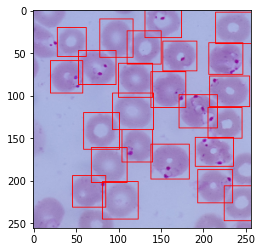

In [225]:
img = cv2.imread(imgs_name[max(max_parasitized.items(), key=operator.itemgetter(1))[0]], cv2.IMREAD_COLOR)
list_bbxs = dict_bbxs[imgs_name[max(max_parasitized.items(), key=operator.itemgetter(1))[0]]]
img_with_box = bbv.draw_multiple_rectangles(img, [box.tolist()[:4] for box in list_bbxs], bbox_color = (255, 0, 0), thickness=1)
plt.imshow(img_with_box)

In [5]:
with open('../data/pickled/imgs_name.pkl', 'wb') as handle:
    pickle.dump(imgs_name, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/pickled/true_boxes.pkl', 'wb') as handle:
    pickle.dump(true_boxes, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/pickled/dict_bbxs.pkl', 'wb') as handle:
    pickle.dump(dict_bbxs, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/pickled/labels.pkl', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)    

NameError: name 'imgs_name' is not defined

## Polygon to rectangle

In [ ]:
filename =  'IMG_20150621_112043'
df_file = df[df['filename'] == filename]
df_file['position'].iloc[-1]

In [ ]:
rect = df_file['bbx']

In [ ]:
df_file['bbx'].tolist()

In [ ]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
img_with_box = bbv.draw_multiple_rectangles(img, df_file['bbx'].tolist(), bbox_color = (255, 0, 0), thickness=3)
plt.imshow(img_with_box)

# Convert to YOLO format

In [9]:
with open('../data/pickled/true_boxes.pkl', 'rb') as handle:
    true_boxes = pickle.load(handle)
with open('../data/pickled/dict_bbxs.pkl', 'rb') as handle:
    dict_bbxs = pickle.load(handle)
with open('../data/pickled/labels.pkl', 'rb') as handle:
    df = pickle.load(handle)    

### Test train split patient level

In [23]:
df.reset_index(drop=True, inplace = True)
df

Patient no - Cell no        cell     comment annotation_type  \
0                       3-1  Uninfected  No_comment         Polygon   
1                       3-2  Uninfected  No_comment         Polygon   
2                       3-3  Uninfected  No_comment         Polygon   
3                       3-4  Uninfected  No_comment         Polygon   
4                       3-5  Uninfected  No_comment         Polygon   
...                     ...         ...         ...             ...   
196929                5-200  Uninfected  No_Comment           Point   
196930                5-201  Uninfected  No_Comment           Point   
196931                5-202  Uninfected  No_Comment           Point   
196932                5-203  Uninfected  No_Comment           Point   
196933                5-204  Uninfected  No_Comment           Point   

       Number of points                                           position  \
0                    14  [(2934, 38), (2955, 33), (2992, 35), (3015, 44...   
1                    15  [(3013, 141), (2993, 144), (2972, 157), (2956,...   
2                    14  [(2730, 135), (2704, 144), (2672, 165), (2661,...   
3                    14  [(2379, 137), (2353, 149), (2334, 169), (2332,...   
4                    14  [(2575, 140), (2548, 145), (2522, 161), (2500,...   
...                 ...                                                ...   
196929                1                                      [(2080, 643)]   
196930                1                                      [(1790, 606)]   
196931                1                                      [(1757, 756)]   
196932                1                                      [(1860, 856)]   
196933                1                                      [(1623, 683)]   

                   filename  \
0       IMG_20150817_103139   
1       IMG_20150817_103139   
2       IMG_20150817_103139   
3       IMG_20150817_103139   
4       IMG_20150817_103139   
...                     ...   
196929  IMG_20151115_181859   
196930  IMG_20151115_181859   
196931  IMG_20151115_181859   
196932  IMG_20151115_181859   
196933  IMG_20151115_181859   

                                                 txt_path  \
0       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
...                                                   ...   
196929  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196930  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196931  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196932  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196933  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   

                                                 img_path  \
0       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4       ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
...                                                   ...   
196929  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196930  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196931  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196932  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   
196933  ../data/NIH-NLM-ThinBloodSmearsPf/Point Set/34...   

                           bbx  patient_n_path  \
0        [2905, 33, 3033, 131]              40   
1       [2951, 141, 3071, 272]              40   
2       [2658, 135, 2801, 276]              40   
3       [2332, 137, 2454, 265]              40   
4       [2499, 140, 2631, 272]              40   
...                        ...             ...   
196929  [2010, 573, 2150, 71

In [11]:
np.random.seed(2)
train_index = []
for patient_n in df['patient_n_path'].unique():
    df_patient = df.loc[df['patient_n_path'] == patient_n]
    mask = np.random.rand(len(df_patient)) < 0.8
    train_index.extend(df_patient[mask].index)
    print('patient: ', patient_n, ' length train_index: ', len(train_index), len(np.unique(train_index)))

patient:  40  length train_index:  618 618
patient:  13  length train_index:  1348 1348
patient:  89  length train_index:  2028 2028
patient:  201  length train_index:  3072 3072
patient:  202  length train_index:  3964 3964
patient:  47  length train_index:  4954 4954
patient:  148  length train_index:  5586 5586
patient:  16  length train_index:  6302 6302
patient:  87  length train_index:  6839 6839
patient:  203  length train_index:  7857 7857
patient:  121  length train_index:  8452 8452
patient:  50  length train_index:  9314 9314
patient:  138  length train_index:  10129 10129
patient:  60  length train_index:  10806 10806
patient:  204  length train_index:  11856 11856
patient:  3  length train_index:  12663 12663
patient:  10  length train_index:  13575 13575
patient:  205  length train_index:  14702 14702
patient:  206  length train_index:  15909 15909
patient:  83  length train_index:  16562 16562
patient:  207  length train_index:  17634 17634
patient:  95  length train_ind

patient:  44  length train_index:  143843 143843
patient:  19  length train_index:  144529 144529
patient:  79  length train_index:  145199 145199
patient:  84  length train_index:  145993 145993
patient:  91  length train_index:  146622 146622
patient:  57  length train_index:  147496 147496
patient:  85  length train_index:  148193 148193
patient:  109  length train_index:  149157 149157
patient:  107  length train_index:  150083 150083
patient:  23  length train_index:  150890 150890
patient:  117  length train_index:  152004 152004
patient:  244  length train_index:  153001 153001
patient:  61  length train_index:  153713 153713
patient:  43  length train_index:  154612 154612
patient:  128  length train_index:  155597 155597
patient:  11  length train_index:  156335 156335
patient:  17  length train_index:  156832 156832
patient:  119  length train_index:  157636 157636


In [12]:
df['train_test'] = 'test'
df.at[train_index, 'train_test'] = 'train'
df['train_test'].value_counts()

train    157636
test      39298
Name: train_test, dtype: int64

In [13]:
#sanity check
print('percentage train: ', len(df[df['train_test'] == 'train']) / len(df))

percentage train:  0.8004509124884479


In [14]:
#sanity check patient level
for patient_n in df['patient_n_path'].unique():
    df_patient = df.loc[df['patient_n_path'] == patient_n]
    percent_train = len(df_patient[df_patient['train_test'] == 'train']) / len(df_patient)
    print('patient: ', patient_n, ' percentage train: ', percent_train)

patient:  40  percentage train:  0.8015564202334631
patient:  13  percentage train:  0.7969432314410481
patient:  89  percentage train:  0.8095238095238095
patient:  201  percentage train:  0.7963386727688787
patient:  202  percentage train:  0.8221198156682028
patient:  47  percentage train:  0.7983870967741935
patient:  148  percentage train:  0.7959697732997482
patient:  16  percentage train:  0.798216276477146
patient:  87  percentage train:  0.7660485021398002
patient:  203  percentage train:  0.8085782366957903
patient:  121  percentage train:  0.7870370370370371
patient:  50  percentage train:  0.7959372114496768
patient:  138  percentage train:  0.8117529880478087
patient:  60  percentage train:  0.7974087161366313
patient:  204  percentage train:  0.8045977011494253
patient:  3  percentage train:  0.8037848605577689
patient:  10  percentage train:  0.792354474370113
patient:  205  percentage train:  0.7970297029702971
patient:  206  percentage train:  0.7940789473684211
patien

patient:  241  percentage train:  0.8140077821011673
patient:  242  percentage train:  0.7992565055762082
patient:  243  percentage train:  0.8102564102564103
patient:  59  percentage train:  0.8142250530785563
patient:  44  percentage train:  0.7914494264859229
patient:  19  percentage train:  0.7885057471264367
patient:  79  percentage train:  0.8072289156626506
patient:  84  percentage train:  0.8052738336713996
patient:  91  percentage train:  0.8105670103092784
patient:  57  percentage train:  0.7796610169491526
patient:  85  percentage train:  0.7965714285714286
patient:  109  percentage train:  0.8080469404861693
patient:  107  percentage train:  0.7761944677284157
patient:  23  percentage train:  0.7896281800391389
patient:  117  percentage train:  0.8020158387329014
patient:  244  percentage train:  0.7963258785942492
patient:  61  percentage train:  0.8008998875140607
patient:  43  percentage train:  0.7969858156028369
patient:  128  percentage train:  0.790529695024077
patie

### Test train split patient & img_level

In [15]:
seed_n = 2
random.seed(seed_n)
train_index = []
for patient_n in df['patient_n_path'].unique():
    list_filenames = df.loc[df['patient_n_path'] == patient_n, 'filename'].unique().tolist()
    perct_total = round(len(list_filenames) * 0.8)
    list_filenames_masked = random.sample(list_filenames, perct_total)
    train_index.extend(df.loc[(df['patient_n_path'] == patient_n) & (df['filename'].isin(list_filenames_masked))].index)
    perc_train = len(df.loc[(df['patient_n_path'] == patient_n) & (df['filename'].isin(list_filenames_masked))]) / len(df.loc[(df['patient_n_path'] == patient_n)])
    print('patient: ', patient_n, ' percentage train cells: ', str(perc_train))

patient:  40  percentage train cells:  0.7600518806744487
patient:  13  percentage train cells:  0.8187772925764192
patient:  89  percentage train cells:  0.8023809523809524
patient:  201  percentage train cells:  0.7879481311975591
patient:  202  percentage train cells:  0.7963133640552995
patient:  47  percentage train cells:  0.8032258064516129
patient:  148  percentage train cells:  0.8312342569269522
patient:  16  percentage train cells:  0.7692307692307693
patient:  87  percentage train cells:  0.7617689015691869
patient:  203  percentage train cells:  0.8093725178713265
patient:  121  percentage train cells:  0.8029100529100529
patient:  50  percentage train cells:  0.7839335180055401
patient:  138  percentage train cells:  0.8067729083665338
patient:  60  percentage train cells:  0.7879858657243817
patient:  204  percentage train cells:  0.8022988505747126
patient:  3  percentage train cells:  0.8057768924302788
patient:  10  percentage train cells:  0.8297132927888793
patient:

patient:  46  percentage train cells:  0.8009188361408882
patient:  35  percentage train cells:  0.8193891102257637
patient:  5  percentage train cells:  0.8043087971274686
patient:  102  percentage train cells:  0.8226059654631083
patient:  146  percentage train cells:  0.8119935170178282
patient:  129  percentage train cells:  0.8077777777777778
patient:  9  percentage train cells:  0.7528089887640449
patient:  137  percentage train cells:  0.8074277854195323
patient:  115  percentage train cells:  0.804945054945055
patient:  66  percentage train cells:  0.8169014084507042
patient:  42  percentage train cells:  0.7718780727630286
patient:  70  percentage train cells:  0.8104008667388949
patient:  36  percentage train cells:  0.816350710900474
patient:  105  percentage train cells:  0.7936404931862427
patient:  12  percentage train cells:  0.7365269461077845
patient:  120  percentage train cells:  0.8256130790190735
patient:  101  percentage train cells:  0.8161530286928799
patient:  

In [16]:
df['train_test'] = 'test'
df.at[train_index, 'train_test'] = 'train'
df['train_test'].value_counts()

train    157849
test      39085
Name: train_test, dtype: int64

In [17]:
#sanity check
print('percentage train: ', len(df[df['train_test'] == 'train']) / len(df))

percentage train:  0.8015324931195222


In [18]:
#sanity check patient level
for patient_n in df['patient_n_path'].unique():
    df_patient = df.loc[df['patient_n_path'] == patient_n]
    percent_train = len(df_patient[df_patient['train_test'] == 'train']) / len(df_patient)
    print('patient: ', patient_n, ' percentage train: ', percent_train)

patient:  40  percentage train:  0.7600518806744487
patient:  13  percentage train:  0.8187772925764192
patient:  89  percentage train:  0.8023809523809524
patient:  201  percentage train:  0.7879481311975591
patient:  202  percentage train:  0.7963133640552995
patient:  47  percentage train:  0.8032258064516129
patient:  148  percentage train:  0.8312342569269522
patient:  16  percentage train:  0.7692307692307693
patient:  87  percentage train:  0.7617689015691869
patient:  203  percentage train:  0.8093725178713265
patient:  121  percentage train:  0.8029100529100529
patient:  50  percentage train:  0.7839335180055401
patient:  138  percentage train:  0.8067729083665338
patient:  60  percentage train:  0.7879858657243817
patient:  204  percentage train:  0.8022988505747126
patient:  3  percentage train:  0.8057768924302788
patient:  10  percentage train:  0.8297132927888793
patient:  205  percentage train:  0.804101838755304
patient:  206  percentage train:  0.8111842105263158
patie

In [19]:
df.head()

Patient no - Cell no        cell     comment annotation_type  \
0                  3-1  Uninfected  No_comment         Polygon   
1                  3-2  Uninfected  No_comment         Polygon   
2                  3-3  Uninfected  No_comment         Polygon   
3                  3-4  Uninfected  No_comment         Polygon   
4                  3-5  Uninfected  No_comment         Polygon   

  Number of points                                           position  \
0               14  [(2934, 38), (2955, 33), (2992, 35), (3015, 44...   
1               15  [(3013, 141), (2993, 144), (2972, 157), (2956,...   
2               14  [(2730, 135), (2704, 144), (2672, 165), (2661,...   
3               14  [(2379, 137), (2353, 149), (2334, 169), (2332,...   
4               14  [(2575, 140), (2548, 145), (2522, 161), (2500,...   

              filename                                           txt_path  \
0  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
1  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
2  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
3  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   
4  IMG_20150817_103139  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   

                                            img_path                     bbx  \
0  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...   [2905, 33, 3033, 131]   
1  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2951, 141, 3071, 272]   
2  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2658, 135, 2801, 276]   
3  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2332, 137, 2454, 265]   
4  ../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/...  [2499, 140, 2631, 272]   

   patient_n_path                                  adjusted_position  \
0              40  [(1652, 29), (1673, 24), (1710, 26), (1733, 35...   
1              40  [(1731, 132), (1711, 135), (1690, 148), (1674,...   
2              40  [(1448, 126), (1422, 135), (1390, 156), (1379,...   
3              40  [(1097, 128), (1071, 140), (1052, 160), (1050,...   
4              40  [(1293, 131), (1266, 136), (1240, 152), (1218,...   

                                 img_path_fit2circle  \
0  ../data/fit_to_circle/cropped_P40_IMG_20150817...   
1  ../data/fit_to_circle/cropped_P40_IMG_20150817...   
2  ../data/fit_to_circle/cropped_P40_IMG_20150817...   
3  ../data/fit_to_circle/cropped_P40_IMG_20150817...   
4  ../data/fit_to_circle/cropped_P40_IMG_20150817...   

                                mask_path_fit2circle            adjusted_bbx  \
0  ../data/fit_to_circle/masks_cropped_P40_IMG_20...   [1623, 24, 1751, 122]   
1  ../data/fit_to_circle/masks_cropped_P40_IMG_20...  [1669, 132, 1789, 263]   
2  ../data/fit_to_circle/masks_cropped_P40_IMG_20...  [1376, 126, 1519, 267]   
3  ../data/fit_to_circle/masks_cropped_P40_IMG_20...  [1050, 128, 1172, 256]   
4  ../data/fit_to_circle/masks_cropped_P40_IMG_20...  [1217, 131, 1349, 263]   

                                    mask_path train_test  
0  ../data/masks/mask_IMG_20150817_103139.png      train  
1  ../data/masks/mask_IMG_20150817_103139.png      train  
2  ../data/masks/mask_IMG_20150817_103139.png      train  
3  ../data/masks/mask_IMG_20150817_103139.png      train  
4  ../data/masks/mask_IMG_20150817_103139.png      train

### Create test and train folders fit to circle

In [31]:
dict_img_path_fit2circle = dict(zip(df['img_path'], df['img_path_fit2circle']))
dict_mask_path_fit2circle = dict(zip(df['img_path'], df['mask_path_fit2circle']))
dict_patient_n = dict(zip(df['img_path'], df['patient_n_path']))
dict_filename = dict(zip(df['img_path'], df['filename']))

counter = 0
counter_train = 0
counter_test = 0
resize = 512

outdir_test = f'../data/fit_to_circle/test_512'
outdir_train = f'../data/fit_to_circle/train_512'
check_if_outdir_test = os.path.isdir(outdir_test)
check_if_outdir_train = os.path.isdir(outdir_train)
if not check_if_outdir_test:
    os.makedirs(outdir_test)
if not check_if_outdir_train:
    os.makedirs(outdir_train)

for img_path in df.loc[(df['annotation_type'] == 'Polygon'), 'img_path'].unique():
    counter += 1

    patient_n_path = dict_patient_n[img_path]
    filename = dict_filename[img_path]
    img_path_fit2circle = dict_img_path_fit2circle[img_path]
    mask_path_fit2circle = dict_mask_path_fit2circle[img_path]
    
    # copy to train folder
    if not df.loc[(df['annotation_type'] == 'Polygon') & (df['img_path'] == img_path) & (df['train_test'] == 'train'), 'img_path'].empty:
        counter_train += 1
        print('copy img to training: ', filename)
        img = cv2.imread(img_path_fit2circle, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (resize, resize))
        outname_img = os.path.join(outdir_train + '/cropped_P' +  str(patient_n_path) + '_' + filename + '.png')
        cv2.imwrite(outname_img, img)
        print('copy mask to training: ', filename)
        mask = cv2.imread(mask_path_fit2circle, cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(mask, (resize, resize))
        outname_mask = os.path.join(outdir_train + '/cropped_P' +  str(patient_n_path) + '_' + filename + '_masks.png')
        cv2.imwrite(outname_mask, mask)
        
    # copy to test folder
    if not df.loc[(df['annotation_type'] == 'Polygon') & (df['img_path'] == img_path) & (df['train_test'] == 'test'), 'img_path'].empty:
        counter_test +=1
        print('copy img to test: ', filename)
        img = cv2.imread(img_path_fit2circle, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (resize, resize))
        outname_img = os.path.join(outdir_test + '/cropped_P' +   str(patient_n_path) + '_' + filename + '.png')
        cv2.imwrite(outname_img, img)
        print('copy mask to test: ', filename)
        mask = cv2.imread(mask_path_fit2circle, cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(mask, (resize, resize))
        outname_mask = os.path.join(outdir_test + '/cropped_P' +   str(patient_n_path) + '_' + filename + '_masks.png')
        cv2.imwrite(outname_mask, mask)
        
print('len counter: ', counter)
print('len counter_train: ', counter_train)
print('len counter_test: ', counter_test)


copy img to training:  IMG_20150817_103139
copy mask to training:  IMG_20150817_103139
copy img to training:  IMG_20150817_103303
copy mask to training:  IMG_20150817_103303
copy img to test:  IMG_20150817_102702
copy mask to test:  IMG_20150817_102702
copy img to training:  IMG_20150817_102823
copy mask to training:  IMG_20150817_102823
copy img to training:  IMG_20150817_103901
copy mask to training:  IMG_20150817_103901
copy img to training:  IMG_20150725_123938
copy mask to training:  IMG_20150725_123938
copy img to training:  IMG_20150725_125213
copy mask to training:  IMG_20150725_125213
copy img to training:  IMG_20150725_125847
copy mask to training:  IMG_20150725_125847
copy img to test:  IMG_20150725_124606
copy mask to test:  IMG_20150725_124606
copy img to training:  IMG_20150725_124830
copy mask to training:  IMG_20150725_124830
copy img to training:  IMG_20151004_130810
copy mask to training:  IMG_20151004_130810
copy img to test:  IMG_20151004_130408
copy mask to test:  

copy img to test:  IMG_20151002_144341
copy mask to test:  IMG_20151002_144341
copy img to training:  IMG_20151002_144855
copy mask to training:  IMG_20151002_144855
copy img to training:  IMG_20151002_145014
copy mask to training:  IMG_20151002_145014
copy img to training:  IMG_20151002_145330
copy mask to training:  IMG_20151002_145330
copy img to training:  IMG_20151112_131255
copy mask to training:  IMG_20151112_131255
copy img to test:  IMG_20151112_131622
copy mask to test:  IMG_20151112_131622
copy img to training:  IMG_20151112_131546
copy mask to training:  IMG_20151112_131546
copy img to training:  IMG_20151112_131408
copy mask to training:  IMG_20151112_131408
copy img to training:  IMG_20151112_131731
copy mask to training:  IMG_20151112_131731
copy img to training:  IMG_20151005_121656
copy mask to training:  IMG_20151005_121656
copy img to training:  IMG_20151005_121425
copy mask to training:  IMG_20151005_121425
copy img to test:  IMG_20151005_121554
copy mask to test:  

In [30]:
dict_img_path_fit2circle = dict(zip(df['img_path'], df['img_path_fit2circle']))
dict_mask_path_fit2circle = dict(zip(df['img_path'], df['mask_path_fit2circle']))
dict_patient_n = dict(zip(df['img_path'], df['patient_n_path']))
dict_filename = dict(zip(df['img_path'], df['filename']))

counter = 0
counter_train = 0
counter_test = 0
resize = 512

outdir_test_img = f'../data/fit_to_circle/test_img'
outdir_train_img = f'../data/fit_to_circle/train_img'
outdir_test_mask = f'../data/fit_to_circle/test_mask'
outdir_train_mask = f'../data/fit_to_circle/train_mask'
check_if_outdir_test_img = os.path.isdir(outdir_test_img)
check_if_outdir_train_img = os.path.isdir(outdir_train_img)
check_if_outdir_test_mask = os.path.isdir(outdir_test_mask)
check_if_outdir_train_mask = os.path.isdir(outdir_train_mask)
if not check_if_outdir_test_img:
    os.makedirs(outdir_test_img)
if not check_if_outdir_train_img:
    os.makedirs(outdir_train_img)
if not check_if_outdir_test_mask:
    os.makedirs(outdir_test_mask)
if not check_if_outdir_train_mask:
    os.makedirs(outdir_train_mask)
    

for img_path in df.loc[(df['annotation_type'] == 'Polygon'), 'img_path'].unique():
    counter += 1

    patient_n_path = dict_patient_n[img_path]
    filename = dict_filename[img_path]
    img_path_fit2circle = dict_img_path_fit2circle[img_path]
    mask_path_fit2circle = dict_mask_path_fit2circle[img_path]
    
    # copy to train folder
    if not df.loc[(df['annotation_type'] == 'Polygon') & (df['img_path'] == img_path) & (df['train_test'] == 'train'), 'img_path'].empty:
        counter_train += 1
        print('copy img to training: ', filename)
        img = cv2.imread(img_path_fit2circle, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (resize, resize))
        outname_img_train = os.path.join(outdir_train_img + '/cropped_P' + str(patient_n_path) + '_' + filename + '.png')
        cv2.imwrite(outname_img_train, img)
        print('copy mask to training: ', filename)
        mask = cv2.imread(mask_path_fit2circle, cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(mask, (resize, resize))
        outname_mask_train = os.path.join(outdir_train_mask + '/cropped_P' + str(patient_n_path) + '_' + filename + '.png')
        cv2.imwrite(outname_mask_train, mask)
        
    # copy to test folder
    if not df.loc[(df['annotation_type'] == 'Polygon') & (df['img_path'] == img_path) & (df['train_test'] == 'test'), 'img_path'].empty:
        counter_test +=1
        print('copy img to test: ', filename)
        img = cv2.imread(img_path_fit2circle, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (resize, resize))
        outname_img_test = os.path.join(outdir_test_img + '/cropped_P' + str(patient_n_path) + '_' + filename + '.png')
        cv2.imwrite(outname_img_test, img)
        print('copy mask to test: ', filename)
        mask = cv2.imread(mask_path_fit2circle, cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(mask, (resize, resize))
        outname_mask_test = os.path.join(outdir_test_mask + '/cropped_P' + str(patient_n_path) + '_' + filename + '.png')
        cv2.imwrite(outname_mask_test, mask)
        
print('len counter: ', counter)
print('len counter_train: ', counter_train)
print('len counter_test: ', counter_test)


copy img to training:  IMG_20150817_103139
copy mask to training:  IMG_20150817_103139
copy img to training:  IMG_20150817_103303
copy mask to training:  IMG_20150817_103303
copy img to test:  IMG_20150817_102702
copy mask to test:  IMG_20150817_102702
copy img to training:  IMG_20150817_102823
copy mask to training:  IMG_20150817_102823
copy img to training:  IMG_20150817_103901
copy mask to training:  IMG_20150817_103901
copy img to training:  IMG_20150725_123938
copy mask to training:  IMG_20150725_123938
copy img to training:  IMG_20150725_125213
copy mask to training:  IMG_20150725_125213
copy img to training:  IMG_20150725_125847
copy mask to training:  IMG_20150725_125847
copy img to test:  IMG_20150725_124606
copy mask to test:  IMG_20150725_124606
copy img to training:  IMG_20150725_124830
copy mask to training:  IMG_20150725_124830
copy img to training:  IMG_20151004_130810
copy mask to training:  IMG_20151004_130810
copy img to test:  IMG_20151004_130408
copy mask to test:  

copy img to test:  IMG_20151002_144341
copy mask to test:  IMG_20151002_144341
copy img to training:  IMG_20151002_144855
copy mask to training:  IMG_20151002_144855
copy img to training:  IMG_20151002_145014
copy mask to training:  IMG_20151002_145014
copy img to training:  IMG_20151002_145330
copy mask to training:  IMG_20151002_145330
copy img to training:  IMG_20151112_131255
copy mask to training:  IMG_20151112_131255
copy img to test:  IMG_20151112_131622
copy mask to test:  IMG_20151112_131622
copy img to training:  IMG_20151112_131546
copy mask to training:  IMG_20151112_131546
copy img to training:  IMG_20151112_131408
copy mask to training:  IMG_20151112_131408
copy img to training:  IMG_20151112_131731
copy mask to training:  IMG_20151112_131731
copy img to training:  IMG_20151005_121656
copy mask to training:  IMG_20151005_121656
copy img to training:  IMG_20151005_121425
copy mask to training:  IMG_20151005_121425
copy img to test:  IMG_20151005_121554
copy mask to test:  

### Save Polygon to YOLO for Poly Yolo

In [21]:
# produce textfiles for all elements in the train and validation dataset
# FORMAT:
# path_to\image1.jpg x1,y1,x2,y2,class,p1x,p1y,pnx,pny x1,y1,x2,y2,class,p1x,p1y,pnx,pny
previous_row = '1'
file = open('../data/fit_to_circle/poly_yolo_train.txt',"w+")
for img_path_fit_to_circle in df.loc[(df['annotation_type'] == 'Polygon') &  
                                        (df['train_test'] == 'train'), 'img_path_fit2circle'].unique():
    #print(img_path_fit_to_circle)
    file.write(str(img_path_fit_to_circle) + ' ')
    for index, row in df[df['img_path_fit2circle'] == img_path_fit_to_circle].iterrows():
        if row is not previous_row:
            file.write(str(row['adjusted_bbx'][0]) + ',' +
                       str(row['adjusted_bbx'][1]) + ',' +
                       str(row['adjusted_bbx'][2]) + ',' +
                       str(row['adjusted_bbx'][3]) + ',' +
                       str(row['cell']) + ','  +
                        ''.join(str(str(poly[0]) + ',' + str(poly[1]) + ',') for poly in row['adjusted_position'])                        + ' ')
    file.write('\n')
    previous_row = row
file.close()

In [22]:
# produce textfiles for all elements in the train and validation dataset
# FORMAT:
# path_to\image1.jpg x1,y1,x2,y2,class,p1x,p1y,pnx,pny x1,y1,x2,y2,class,p1x,p1y,pnx,pny
previous_row = '1'
file = open('../data/fit_to_circle/poly_yolo_test.txt',"w+")
for img_path_fit_to_circle in df.loc[(df['annotation_type'] == 'Polygon') &  
                                        (df['train_test'] == 'test'), 'img_path_fit2circle'].unique():
    #print(img_path_fit_to_circle)
    file.write(str(img_path_fit_to_circle) + ' ')
    for index, row in df[df['img_path_fit2circle'] == img_path_fit_to_circle].iterrows():
        if row is not previous_row:
            file.write(str(row['adjusted_bbx'][0]) + ',' +
                       str(row['adjusted_bbx'][1]) + ',' +
                       str(row['adjusted_bbx'][2]) + ',' +
                       str(row['adjusted_bbx'][3]) + ',' +
                       str(row['cell']) + ','  +
                        ''.join(str(str(poly[0]) + ',' + str(poly[1]) + ',') for poly in row['adjusted_position'])                        + ' ')
    file.write('\n')
    previous_row = row
file.close()